In [1]:
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps
from utils.combine_tools import apply_qc
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
import statsmodels.api as sm
from aind_ephys_utils import align
import k3d
warnings.filterwarnings('ignore')

%matplotlib inline

# Load data

In [2]:
criteria_name = 'beh_all'
beh_criteria = 'beh_all_beh'
version = 'PrL_S1'

In [3]:
def to_str_intlike(x):
    """
    Convert any integer-like or numeric-like value to a clean string without '.0'.

    Examples:
        297       → '297'
        '297.0'   → '297'
        297.0     → '297'
        np.int64(297) → '297'
        'abc'     → 'abc'   (unchanged)
        np.nan    → np.nan   (kept as NaN)
    """
    if pd.isna(x):
        return np.nan  # or return '' if you prefer empty string for NaN

    # Try to convert to float first (handles both numeric and numeric-like strings)
    try:
        val = float(x)
        # If it's a whole number like 297.0 → cast to int and then str
        if val.is_integer():
            return str(int(val))
        else:
            # Keep decimals if not an integer-like number
            return str(val)
    except (ValueError, TypeError):
        # Non-numeric string: return as-is
        return str(x)


In [4]:
# load waveforms
waveform_criteria = 'waveform_all'
waveform_type = '_raw'
wf_folder  = os.path.join('/root/capsule/scratch/combined/wf_plots', waveform_criteria, waveform_type)
wf_feature_file = os.path.join(wf_folder, 'wf_features_combined.pkl')
with open(wf_feature_file, 'rb') as f:
    wf_features = pickle.load(f)
wf_features.rename(columns={'unit': 'unit_id'}, inplace=True)
wf_features['unit_id'] = wf_features['unit_id'].apply(to_str_intlike)
wf_features.drop(columns=['probe'], inplace=True)

In [5]:
# load basic ephys
be_criteria = 'basic_ephys'
be_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', be_criteria)
be_file = os.path.join(be_folder, f'basic_ephys.pkl')
with open(be_file, 'rb') as f:
    basic_ephys_df = pickle.load(f)
filter = basic_ephys_df['be_filter'].values
filter = np.array(filter, dtype=bool)
basic_ephys_df['be_filter'] = filter
basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
basic_ephys_df['unit_id'] = basic_ephys_df['unit_id'].apply(to_str_intlike)

In [6]:
# load basic constraints and data (unit + behavior)
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
# behavior 
with open(os.path.join('/root/capsule/scratch/combined/combined_session_tbl', 'combined_beh_sessions.pkl'), 'rb') as f:
    combined_session_qc = pickle.load(f)
combined_session_qc.drop(columns=['probe'], inplace=True, errors='ignore')
combined_tagged_units = combined_tagged_units.merge(combined_session_qc, on='session', how='left')

# antidromic data
antidromic_file = f'/root/capsule/scratch/combined/beh_plots/basic_ephys_low/{version}/combined_antidromic_results.pkl'
with open(antidromic_file, 'rb') as f:
    antidromic_df = pickle.load(f)

antidromic_df.rename(columns={'unit': 'unit_id'}, inplace=True)
antidromic_df['unit_id'] = antidromic_df['unit_id'].apply(to_str_intlike)
antidromic_df = antidromic_df[['unit_id', 'session', 'p_auto_inhi', 't_auto_inhi',
       'p_collision', 't_collision', 'p_antidromic', 't_antidromic', 'tier_1',
       'tier_2', 'tier_1_long', 'tier_2_long']].copy()
combined_tagged_units = combined_tagged_units.merge(antidromic_df, on=['session', 'unit_id'], how='left')
combined_tagged_units['tier_1'].fillna(False, inplace=True)
combined_tagged_units['tier_2'].fillna(False, inplace=True)
combined_tagged_units['tier_1_long'].fillna(False, inplace=True)
combined_tagged_units['tier_2_long'].fillna(False, inplace=True)

with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{beh_criteria}.json'), 'r') as f:
    beh_constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

Applying conditional bounds for isi_violations
 - isi_violations: 18301 -> 8350 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8350 -> 5877 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5877 -> 5854 units passed
Applying items for in_df: [True]
 - in_df: 5854 -> 4220 units passed
Applying conditional bounds for y_loc
 - y_loc: 4220 -> 2957 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 2957 -> 2943 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 322
Number of non-opto units after filtering: 2943


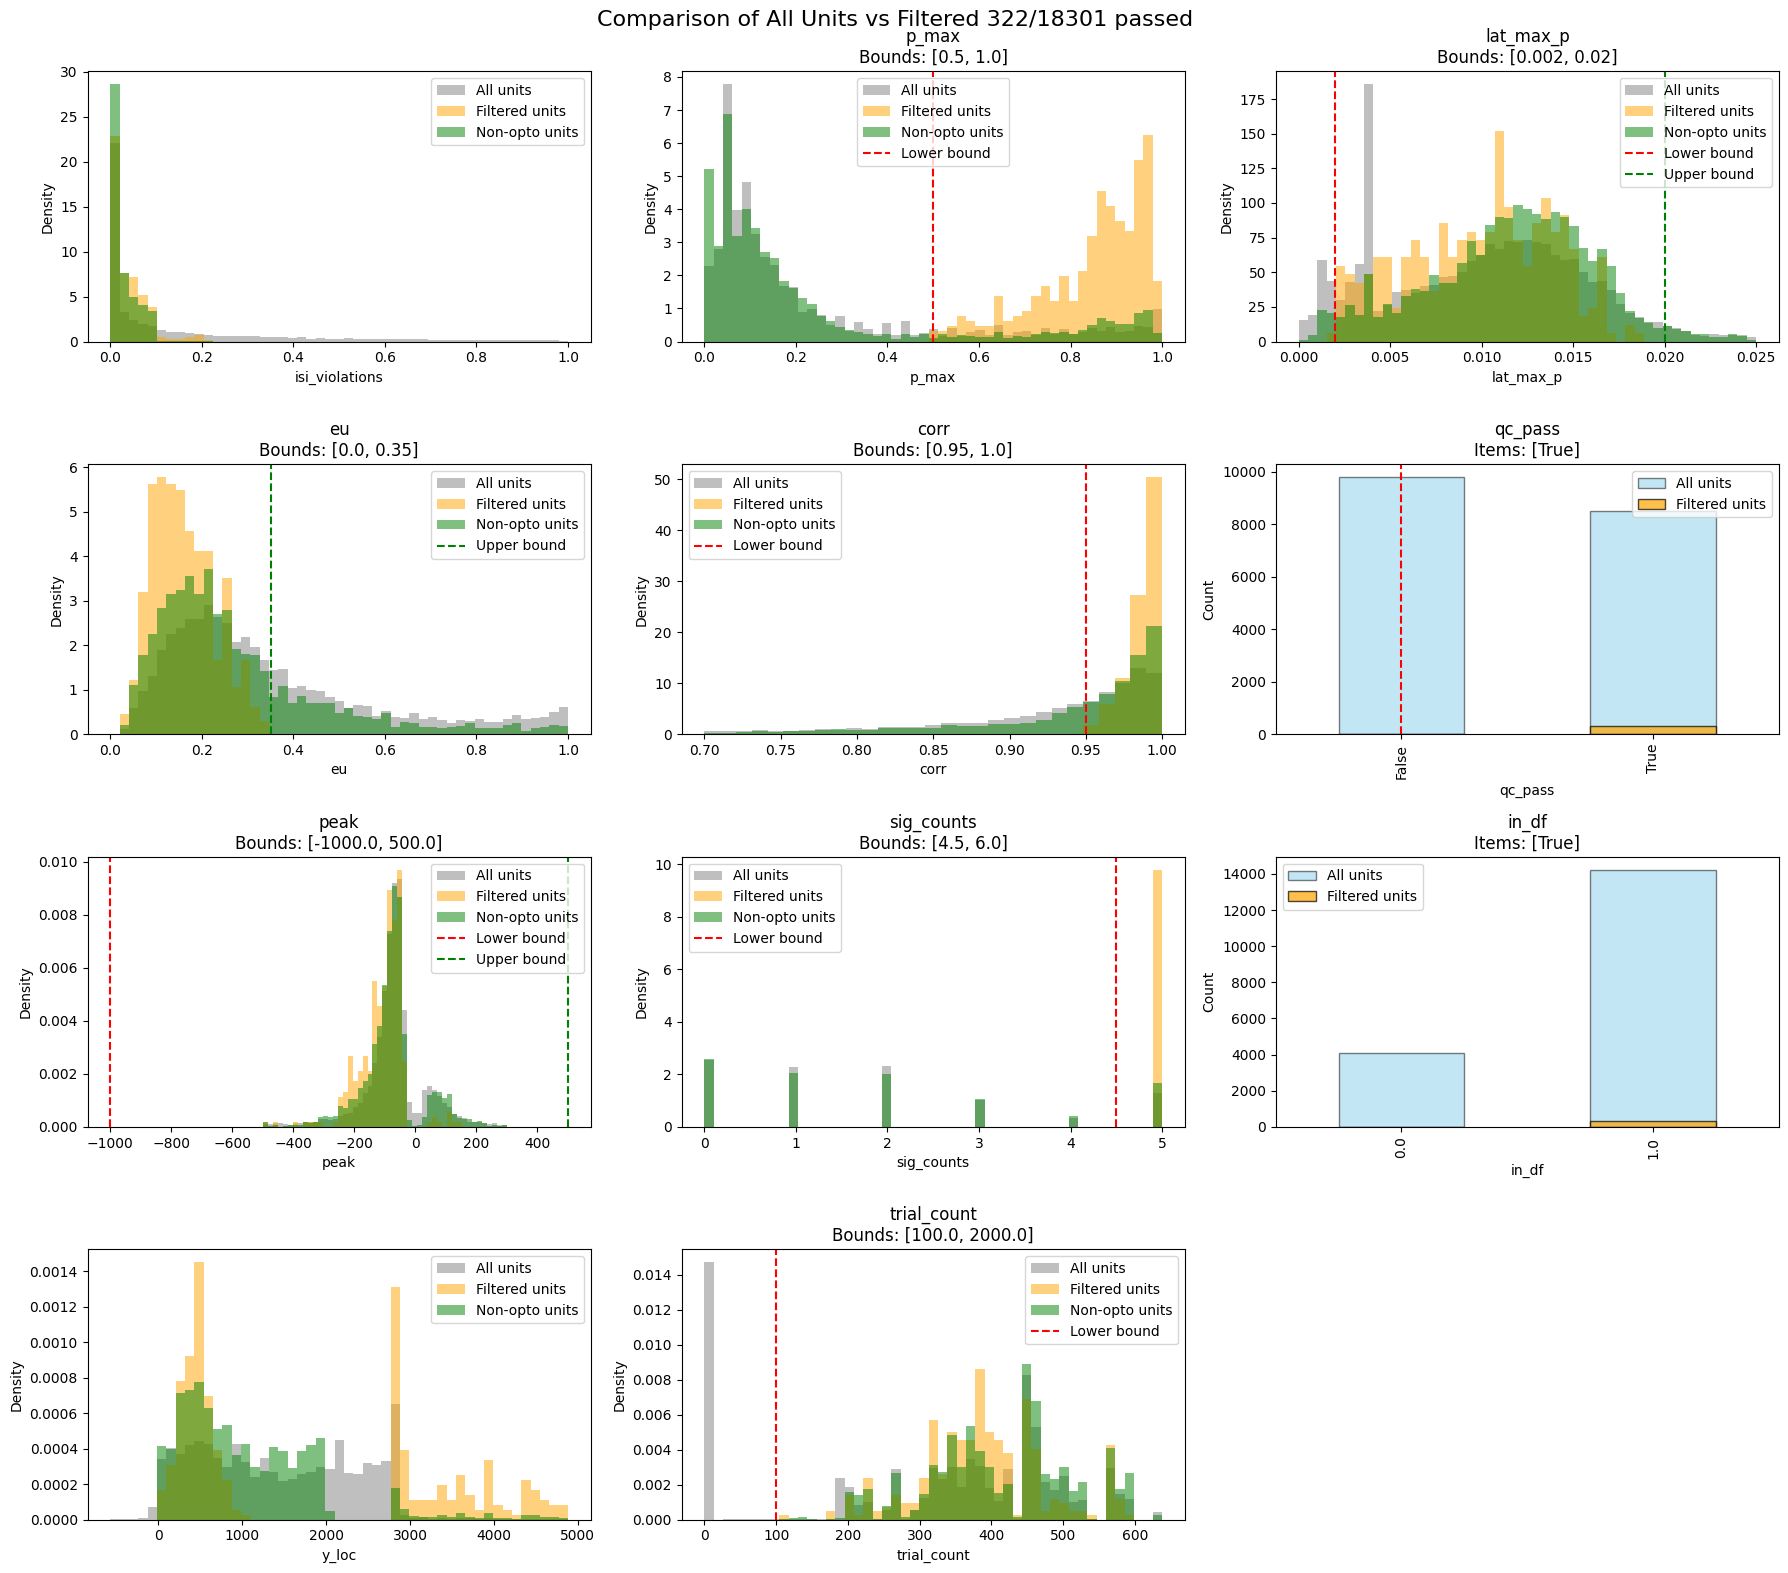

In [7]:
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
combined_tagged_units_filtered.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units_filtered['unit_id'] = combined_tagged_units_filtered['unit_id'].apply(to_str_intlike)

Applying bounds for isi_violations: [0.0, 0.1]
 - isi_violations: 18301 -> 8323 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8323 -> 5850 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5850 -> 5827 units passed
Applying items for in_df: [True]
 - in_df: 5827 -> 4195 units passed
Applying conditional bounds for y_loc
 - y_loc: 4195 -> 2932 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 2932 -> 2920 units passed
Applying bounds for session_len: [100, 2000]
 - session_len: 2920 -> 2771 units passed
Applying bounds for p_sw_L: [0.05, 1]
 - p_sw_L: 2771 -> 2657 units passed
Applying bounds for aN: [0.05, 1.0]
 - aN: 2657 -> 2655 units passed
Applying bounds for diff_1: [0, 'nan']
 - diff_1: 2655 -> 2655 units passed
Applying bounds for intercept: [-3, 3]
 - intercept: 2655 -> 2606 units passed
Applying bounds for sw_bias: [-1, 1]
 - sw_bias: 2606 -> 2606 units passed
Applying items for lick_bias: [False]
 - lick_bias: 2606 -> 2021 unit

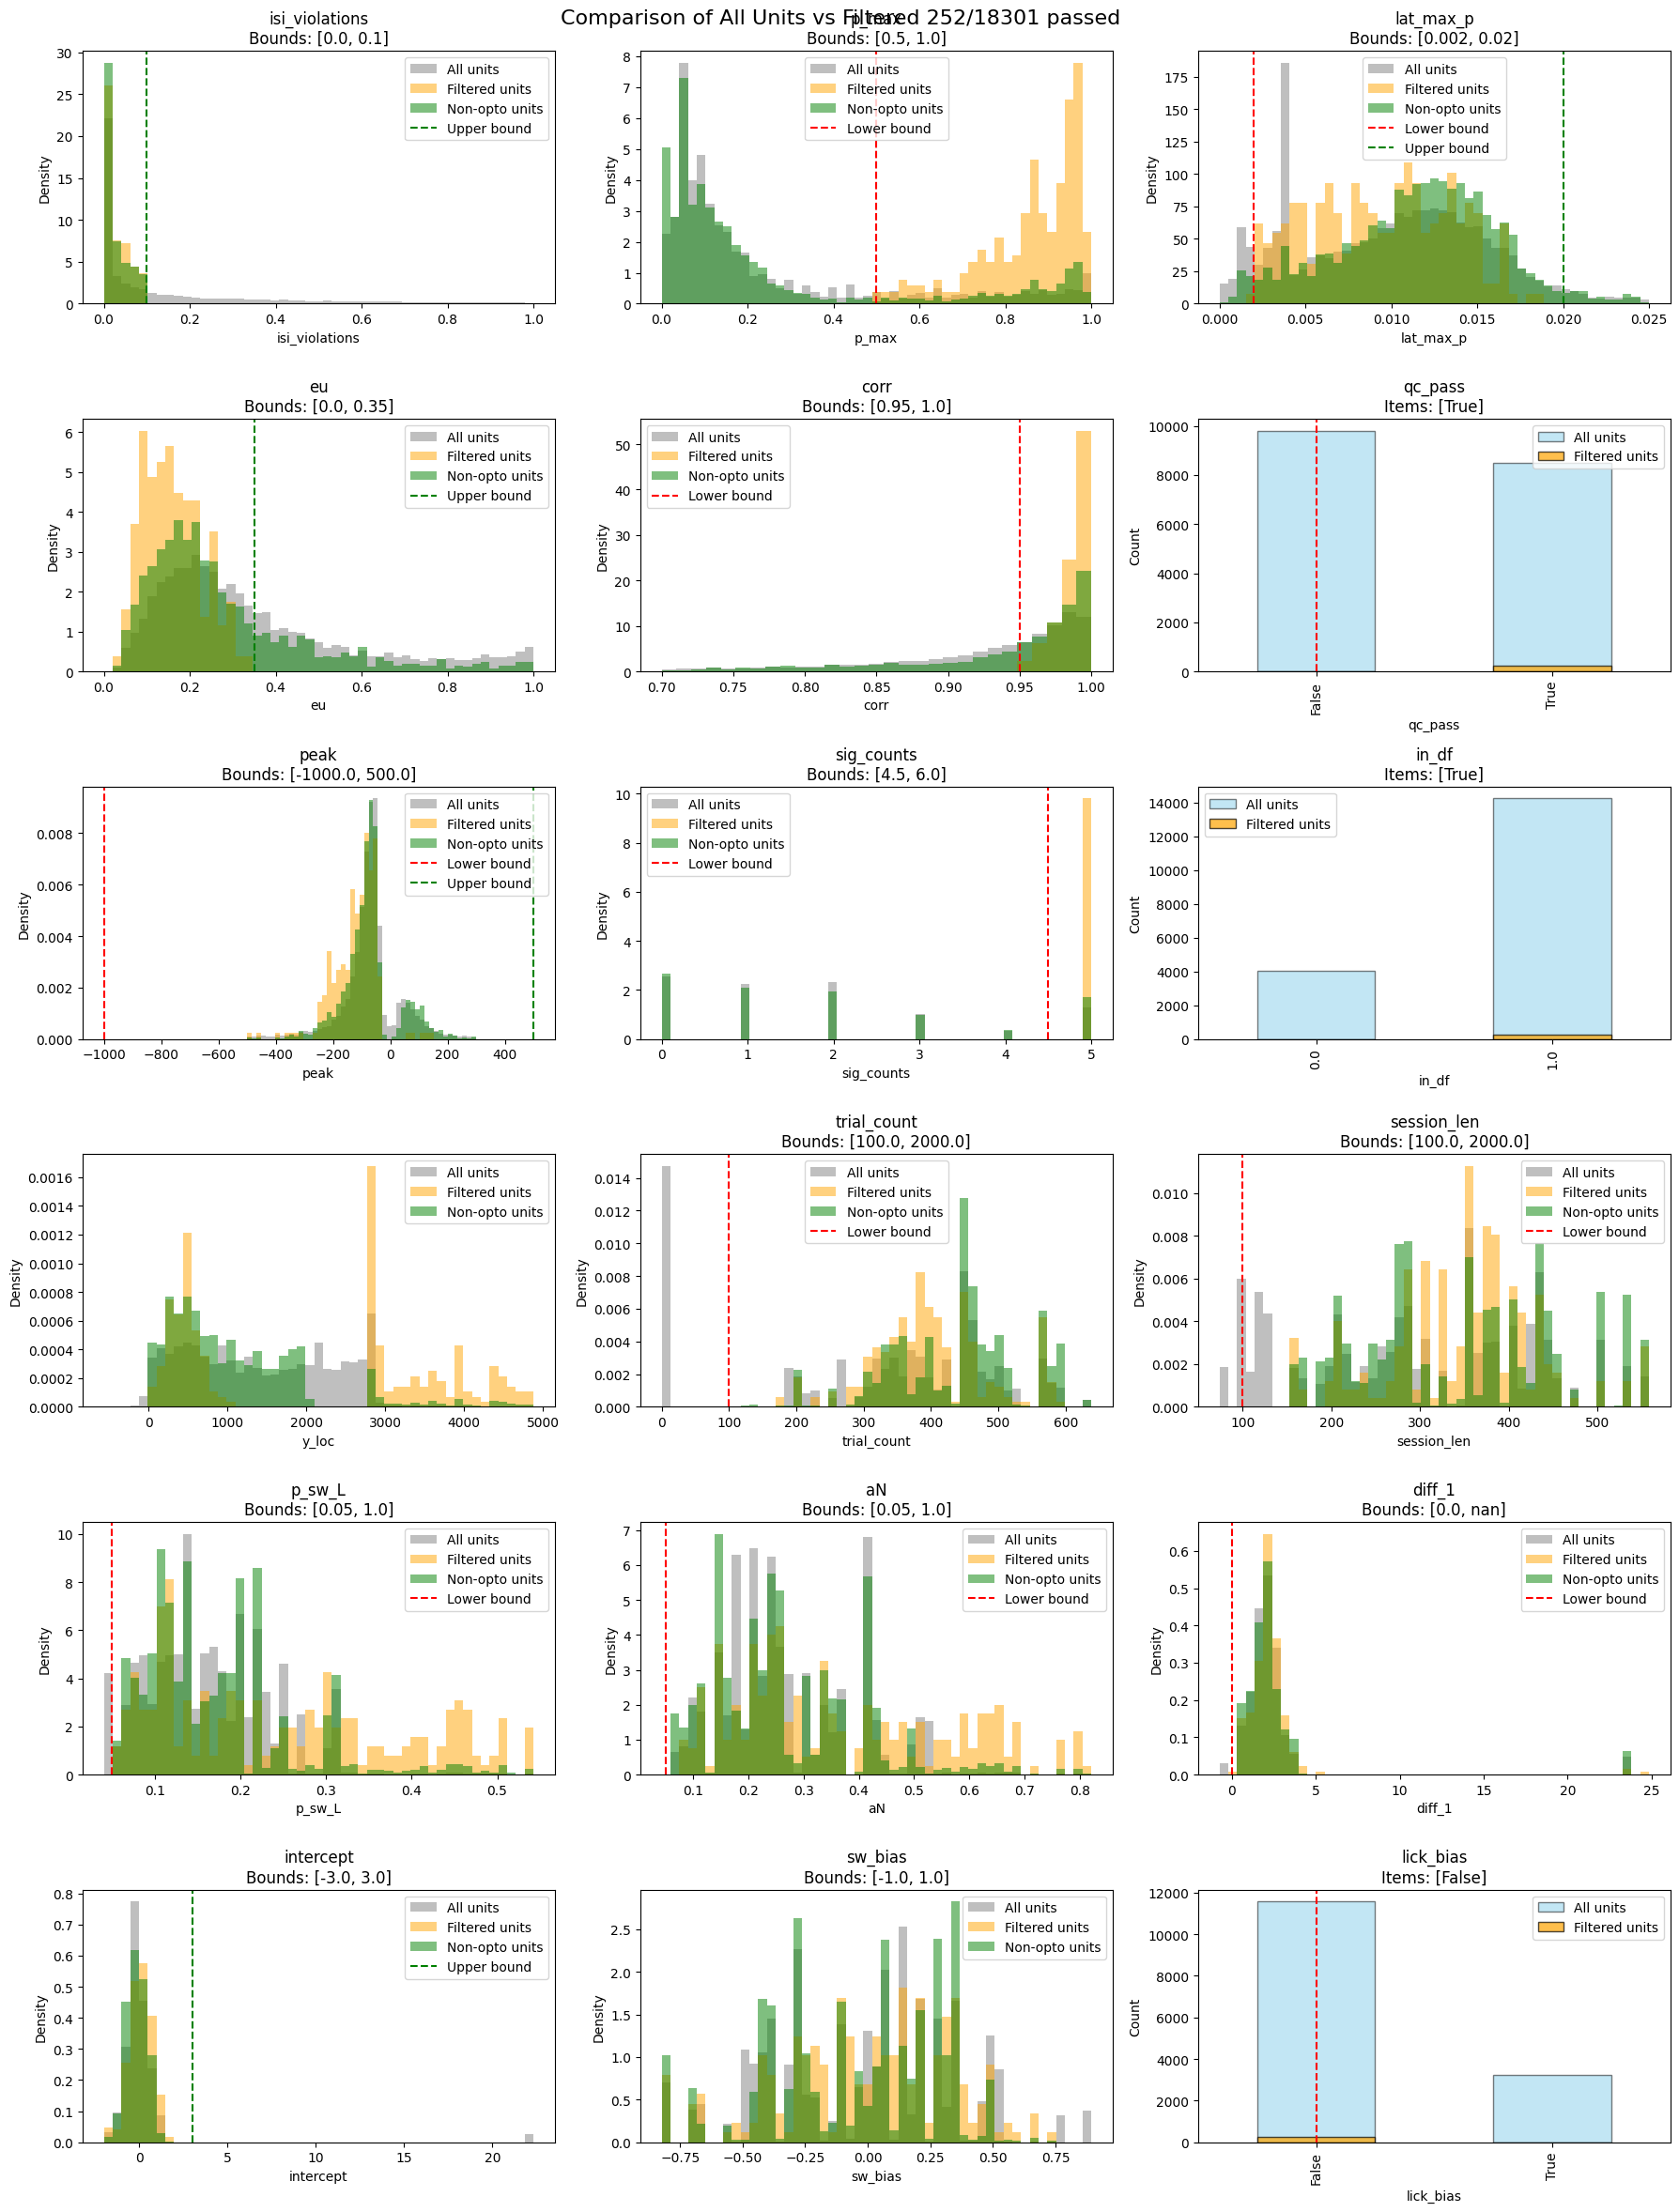

In [8]:
combined_tagged_units_filtered_beh, combined_tagged_units_beh, fig = apply_qc(combined_tagged_units, beh_constraints)

In [9]:
# # put all behavior into 1 folder
# all_pdf_dir = os.path.join(beh_folder, 'all_pdfs')
# beh_response_pdf_folder = os.path.join(all_pdf_dir, 'response')
# beh_go_cue_pdf_folder = os.path.join(all_pdf_dir, 'go_cue')
# opto_pdf_folder = os.path.join(all_pdf_dir, 'opto')
# drift_pdf_folder = os.path.join(all_pdf_dir, 'drift')
# # remove all current ones:
# shutil.rmtree(all_pdf_dir, ignore_errors=True)
# # make folders
# os.makedirs(beh_response_pdf_folder, exist_ok=True)
# os.makedirs(beh_go_cue_pdf_folder, exist_ok=True)
# os.makedirs(opto_pdf_folder, exist_ok=True)
# os.makedirs(drift_pdf_folder, exist_ok=True)
# for ind, row in combined_tagged_units_filtered_beh.iterrows():
#     session = row['session']
#     unit_id = row['unit_id']
#     unit_str = f'{unit_id}'
#     session_dir = session_dirs(session)
#     # opto
#     opto_pdfs= os.listdir(session_dir['opto_dir_fig_curated'])
#     opto_pdf = [opto_pdf for opto_pdf in opto_pdfs if opto_pdf.startswith(f'unit_{unit_str}_' ) and opto_pdf.endswith('opto_tagging.pdf')]
#     if len(opto_pdf) == 0:
#         opto_pdf = [opto_pdf for opto_pdf in opto_pdfs if opto_pdf.startswith(f'unit_{unit_str}.0_' ) and opto_pdf.endswith('opto_tagging.pdf')]
#     if len(opto_pdf) > 0:
#         opto_pdf = os.path.join(session_dir['opto_dir_fig_curated'], opto_pdf[0])
#         # copy
#         shutil.copy(opto_pdf, os.path.join(opto_pdf_folder, f'{session}_unit_{unit_str}_opto.pdf'))
#     else:
#         print(f'No opto pdf for session {session}, unit {unit_str}') 

#     # drift
#     if not os.path.exists(os.path.join(session_dir['opto_dir_curated'], 'drift')):
#         print(f'No drift folder for session {session}, unit {unit_str}')
#         continue
#     else:
#         drift_pdfs= os.listdir(os.path.join(session_dir['opto_dir_curated'], 'drift'))
#         drift_pdf = [drift_pdf for drift_pdf in drift_pdfs if drift_pdf.startswith(f'{unit_str}_' ) and drift_pdf.endswith('drift.pdf')]
#         if len(drift_pdf) == 0:
#             drift_pdf = [drift_pdf for drift_pdf in drift_pdfs if drift_pdf.startswith(f'{unit_str}.0_' ) and drift_pdf.endswith('drift.pdf')]
#         if len(drift_pdf) > 0:
#             drift_pdf = os.path.join(session_dir['opto_dir_curated'], 'drift', drift_pdf[0])
#             # copy
#             shutil.copy(drift_pdf, os.path.join(drift_pdf_folder, f'{session}_{os.path.basename(drift_pdf)}'))
#         else:
#             print(f'No drift pdf for session {session}, unit {unit_str}')

#     # go cue
#     if not os.path.exists(os.path.join(session_dir['ephys_fig_dir_curated'], 'go_cue')):
#         print(f'No go cue folder for session {session}, unit {unit_str}')
#     else:
#         beh_go_cue_pdfs= os.listdir(os.path.join(session_dir['ephys_fig_dir_curated'], 'go_cue'))
#         beh_go_cue_pdf = [pdf for pdf in beh_go_cue_pdfs if pdf.startswith(f'unit_{unit_str}_' ) and pdf.endswith('.pdf')]
#         if len(beh_go_cue_pdf) == 0:
#             beh_go_cue_pdf = [pdf for pdf in beh_go_cue_pdfs if pdf.startswith(f'unit_{unit_str}.0_' ) and pdf.endswith('.pdf')]
#         if len(beh_go_cue_pdf) > 0:
#             beh_go_cue_pdf = os.path.join(session_dir['ephys_fig_dir_curated'], 'go_cue', beh_go_cue_pdf[0])
#             # copy
#             shutil.copy(beh_go_cue_pdf, os.path.join(beh_go_cue_pdf_folder, f'{session}_{os.path.basename(beh_go_cue_pdf)}'))
#         else:
#             print(f'No go cue pdf for session {session}, unit {unit_str}')
#     # response
#     if not os.path.exists(os.path.join(session_dir['ephys_fig_dir_curated'], 'response')):
#         print(f'No response folder for session {session}, unit {unit_str}')
#     else:
#         beh_response_pdfs= os.listdir(os.path.join(session_dir['ephys_fig_dir_curated'], 'response'))
#         beh_response_pdf = [pdf for pdf in beh_response_pdfs if pdf.startswith(f'unit_{unit_str}_' ) and pdf.endswith('.pdf')]
#         if len(beh_response_pdf) == 0:
#             beh_response_pdf = [pdf for pdf in beh_response_pdfs if pdf.startswith(f'unit_{unit_str}.0_' ) and pdf.endswith('.pdf')]
#         if len(beh_response_pdf) > 0:
#             beh_response_pdf = os.path.join(session_dir['ephys_fig_dir_curated'], 'response', beh_response_pdf[0])
#             # copy use original filename to avoid overwriting
#             shutil.copy(beh_response_pdf, os.path.join(beh_response_pdf_folder, f'{session}_{os.path.basename(beh_response_pdf)}'))
#         else:
#             print(f'No response pdf for session {session}, unit {unit_str}')


#     # if os.path.exists(beh_response_pdf):
#     #     shutil.copy(beh_response_pdf, os.path.join(beh_response_pdf_folder, f'{session}_unit_{unit_str}_response.pdf'))
#     # if os.path.exists(beh_go_cue_pdf):
#     #     shutil.copy(beh_go_cue_pdf, os.path.join(beh_go_cue_pdf_folder, f'{session}_unit_{unit_str}_go_cue.pdf'))
#     # if os.path.exists(opto_pdf):
#     #     shutil.copy(opto_pdf, os.path.join(opto_pdf_folder, f'{session}_unit_{unit_str}_opto.pdf'))


In [10]:
combined_tagged_units_beh.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units_beh['unit_id'] = combined_tagged_units_beh['unit_id'].apply(to_str_intlike)

In [11]:
# load and add model variables
model_combined = pd.read_csv(os.path.join(beh_folder, 'figures_in_generation', f'model_combined_{criteria_name}.csv'), index_col=0)
model_combined['theta'] = model_combined['theta'] - 0.5
model_combined['unit_id'] = model_combined['unit_id'].apply(to_str_intlike)

versions = ['e', 'l', 'com']
for version in versions:
    all_vec = np.column_stack((
        model_combined[f'coef_outcome_{version}_mc'],
        model_combined[f'coef_Qchosen_{version}_ori']
    ))
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
    bound_1, bound_2, bound_3 = -(1 / 4) * np.pi, np.pi, -np.pi
    theta_scaled_dis = np.zeros_like(theta)
    for ind, angle_curr in enumerate(theta):
        if bound_1 < angle_curr <= bound_2:
            theta_scaled_dis[ind] = (angle_curr - bound_1) / (bound_2 - bound_1)
        else:
            theta_scaled_dis[ind] = (bound_1 - angle_curr) / (bound_1 - bound_3)
    theta_scaled_dis_all = 1 - theta_scaled_dis - 0.5
    model_combined[f'theta_{version}'] = theta_scaled_dis_all

# derived features
model_combined['coef_outcome|(|coef_outcome| + |coef_Q|)'] = (
    model_combined['coef_outcome_com_mc'] /
    (np.abs(model_combined['coef_outcome_com_mc']) + np.abs(model_combined['coef_Qchosen_com_mc']))
)
model_combined['outcome_ipsi'] = (
    model_combined['coef_outcome_com_mc'] + model_combined['coef_outcome:ipsi_com_mc']
)
model_combined['outcome_contra'] = (
    model_combined['coef_outcome_com_mc'] - model_combined['coef_outcome:ipsi_com_mc']
)
model_combined = model_combined.merge(combined_tagged_units_beh[['session', 'unit_id', 'selected']], on=['session', 'unit_id'], how='left')
# model_combined = model_combined[model_combined['selected']]

In [12]:
# Combine all features
features_combined = pd.merge(model_combined, wf_features, on=['session', 'unit_id'], suffixes=('', '_wf'), how='outer')
features_combined = pd.merge(features_combined, basic_ephys_df, on=['session', 'unit_id'], suffixes=('', '_be'), how='outer')
response_tbl = pd.read_csv(f'/root/capsule/scratch/combined/beh_plots/beh_all/response_ratio_beh_all_go_cue.csv')
response_tbl['unit_id'] = response_tbl['unit'].apply(to_str_intlike)
features_combined = features_combined.merge(response_tbl, on=['session', 'unit_id'], how='outer')

# features_combined = features_combined.merge(antidromic_df, on=['session', 'unit_id'], how='outer')
features_combined = features_combined.merge(combined_tagged_units[['session', 'unit_id', 'probe', 'x_ccf', 'y_ccf', 'z_ccf', 'tier_1', 'tier_2', 'isi_violations']], on=['session', 'unit_id'], how='left')
features_combined['be_filter'].fillna(False, inplace=True)
features_combined['selected'].fillna(False, inplace=True)

# Behavior and spatial 

## Scatter and polar

In [14]:
# scatter and polar of 'outcome' and 'Qchosen'
period = 'l'
verion = 'mc'  # 'ori' or 'mc'

curr_p_int = model_combined[f'p_outcome:ipsi_{period}_{verion}'].values
curr_coefs_int = model_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 


curr_coefs_outcome = model_combined[f'coef_outcome_{period}_{verion}'].values
curr_coefs_q = model_combined[f'coef_Qchosen_{period}_{verion}'].values

curr_T_outcome = model_combined[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_T_q = model_combined[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
curr_p_outcome = model_combined[f'p_outcome_{period}_{verion}'].values  # get the p-values for the reward outcome

# curr_T_outcome = all_Tm[:, outcome_ind]  # get the T-statistics for the reward outcome
# curr_T_q = all_Tm[:, q_ind]  # get the T-statistics for the Qchosen
# curr_p_outcome = all_pm[:, outcome_ind]  # get the p-values for the reward outcome


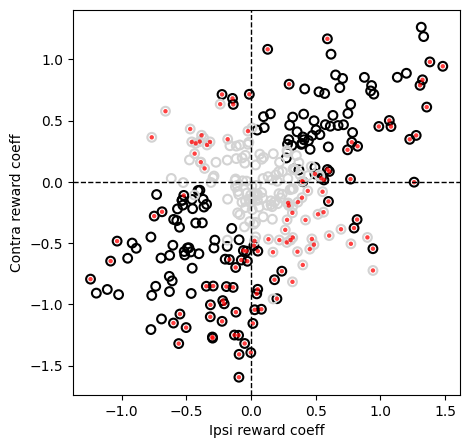

<Figure size 640x480 with 0 Axes>

In [131]:
# compare ipsi vs contra responses
ipsi_reward_coeff = curr_coefs_outcome + curr_coefs_int
contra_reward_coeff = curr_coefs_outcome - curr_coefs_int

# scatter
plt.figure(figsize=(5, 5))
plt.scatter(ipsi_reward_coeff[curr_p_outcome<0.05], contra_reward_coeff[curr_p_outcome<0.05], 
            alpha=1, edgecolors='k', color='none', s=40, linewidths=1.5)
plt.scatter(ipsi_reward_coeff[curr_p_outcome>=0.05], contra_reward_coeff[curr_p_outcome>=0.05],
            alpha=1, edgecolors='lightgray', color='none', s=40, linewidths=1.5)
mask = curr_p_int<0.05
plt.scatter(ipsi_reward_coeff[mask], contra_reward_coeff[mask],
            alpha=0.75, edgecolors='none', color='red', s=10)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Ipsi reward coeff')
plt.ylabel('Contra reward coeff')
plt.show()
plt.savefig(os.path.join(beh_folder, f'ipsi_vs_contra_reward_coeff_{criteria_name}.pdf'), bbox_inches='tight')

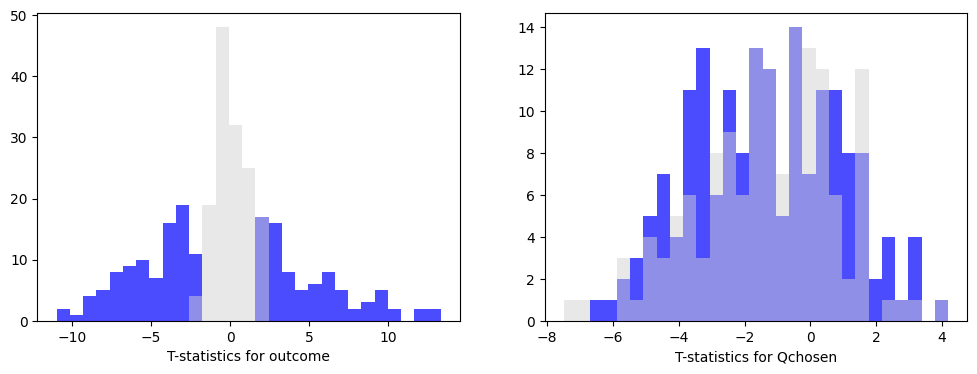

In [132]:
# histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
bins = np.linspace(np.nanmin(curr_T_outcome)-0.01, np.nanmax(curr_T_outcome)+0.01, 30)
plt.hist(curr_T_outcome[curr_p_outcome<0.05], bins=bins, color='blue', alpha=0.7, edgecolor='none')
plt.hist(curr_T_outcome[curr_p_outcome>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
plt.xlabel('T-statistics for outcome')

plt.subplot(1, 2, 2)
bins = np.linspace(np.nanmin(curr_T_q)-0.01, np.nanmax(curr_T_q)+0.01, 30)
plt.hist(curr_T_q[curr_p_outcome<0.05], bins=bins, color='blue', alpha=0.7, edgecolor='none')
plt.hist(curr_T_q[curr_p_outcome>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
plt.xlabel('T-statistics for Qchosen')
plt.savefig(os.path.join(beh_folder, f'T_statistics_outcome_Qchosen_focus_wind_{criteria_name}.pdf'), bbox_inches='tight')


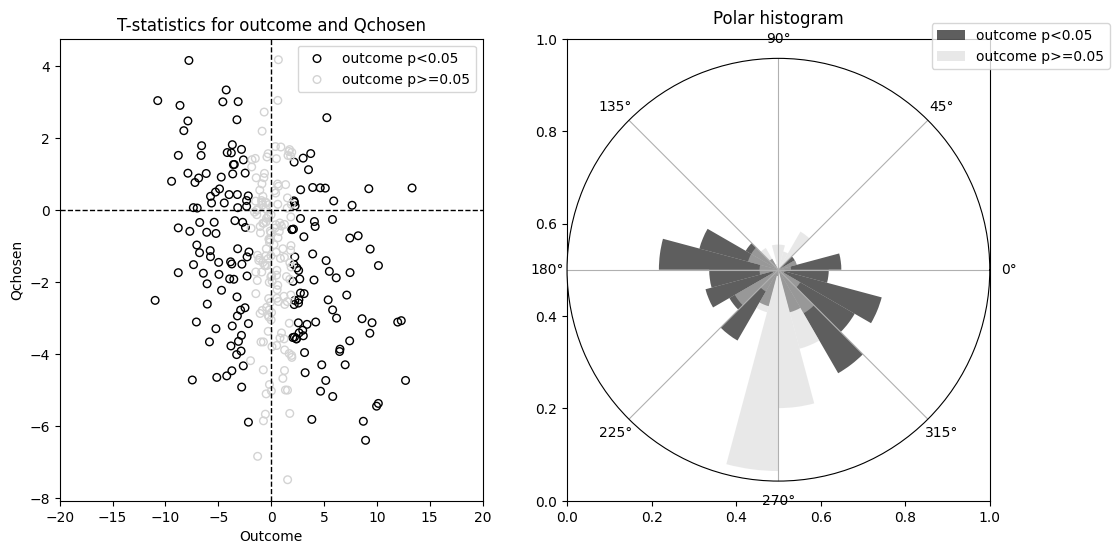

In [135]:
# scatter of outcome and Qchosen coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(curr_T_outcome[curr_p_outcome<0.05], curr_T_q[curr_p_outcome<0.05], color='none', edgecolors='k', s=30, label = 'outcome p<0.05')
axes[0].scatter(curr_T_outcome[curr_p_outcome>=0.05], curr_T_q[curr_p_outcome>=0.05], color='none', edgecolors='lightgray', s=30, label = 'outcome p>=0.05')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Qchosen')
axes[0].set_title('T-statistics for outcome and Qchosen')
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].legend()
axes[0].set_xlim([-20, 20])

# polar
thresh = 0.05
all_vec = np.column_stack((curr_coefs_outcome[curr_p_outcome<thresh], curr_coefs_q[curr_p_outcome<thresh]))  # combine the coefficients for the reward outcome and Qchosen
all_vec = all_vec.astype(float)
all_vec_low = np.column_stack((curr_coefs_outcome[curr_p_outcome>=thresh], curr_coefs_q[curr_p_outcome>=thresh]))
all_vec_low = all_vec_low.astype(float)
# Convert Cartesian coordinates to polar coordinates
theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
theta_low, rho_low = np.arctan2(all_vec_low[:, 1], all_vec_low[:, 0]), np.hypot(all_vec_low[:, 1], all_vec_low[:, 0])
# Define histogram edges (bins) from -π to π
edges = np.linspace(-np.pi, np.pi, 4*6+1)
# Create polar histogram
axes[1] = fig.add_subplot(122, polar=True)
axes[1].hist(theta, bins=edges, color=[0.1, 0.1, 0.1], alpha=0.7, edgecolor='none', density=False, label='outcome p<0.05')
axes[1].hist(theta_low, bins=edges, color='lightgray', alpha=0.5, edgecolor='none', density=False, label='outcome p>=0.05')
axes[1].set_yticks([])
axes[1].set_title('Polar histogram')
axes[1].legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
# plt.suptitle('Outcome and Qchosen coefficients', fontsize=16)
plt.savefig(os.path.join(beh_folder, f'Summary_outcome_Qchosen_coeffs_{criteria_name}.pdf'), bbox_inches='tight')

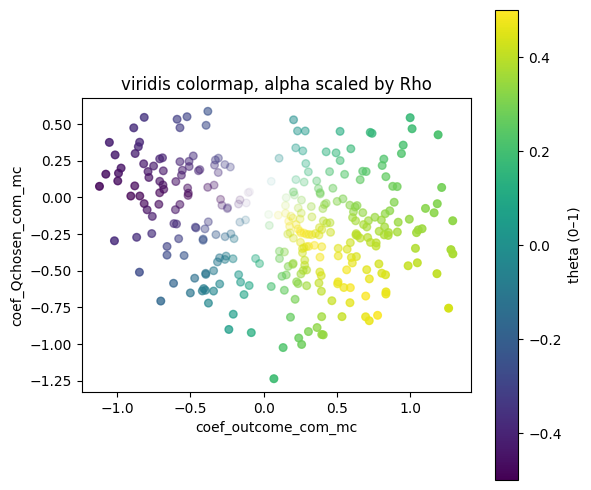

In [27]:
import matplotlib.pyplot as plt
import numpy as np

theta = model_combined['theta'].values

# Define viridis colormap and normalization
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=-0.5, vmax=0.5)

# Alpha = distance from 0.5 → scaled to 0–1 range
alpha_scale = np.sqrt(model_combined['rho'])
alpha_scale = np.clip(alpha_scale, 0, 1.2)
alpha_scale = (alpha_scale - np.min(alpha_scale)) / (np.max(alpha_scale) - np.min(alpha_scale))

# Map θ → viridis colors, then inject alpha per point
colors = cmap(norm(theta))
colors[:, -1] = alpha_scale  # assign alpha channel

# Create scatter using facecolors directly (so alpha is preserved)
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(
    model_combined['coef_outcome_com_mc'],
    model_combined['coef_Qchosen_com_mc'],
    facecolors=colors,
    edgecolors=None,
    s=30,
    marker='o'
)

# Create a standalone ScalarMappable for the colorbar
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# Attach colorbar to this axis
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("theta (0–1)")

ax.set_xlabel("coef_outcome_com_mc")
ax.set_ylabel("coef_Qchosen_com_mc")
ax.set_title("viridis colormap, alpha scaled by Rho")
ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()


In [18]:
# load
# model_combined = pd.read_csv(os.path.join(beh_folder, f'model_combined_{criteria_name}.csv'))
# model_combined_anti = pd.read_csv('/root/capsule/scratch/combined/beh_plots/beh_all_anti/model_combined_beh_all_anti.csv')


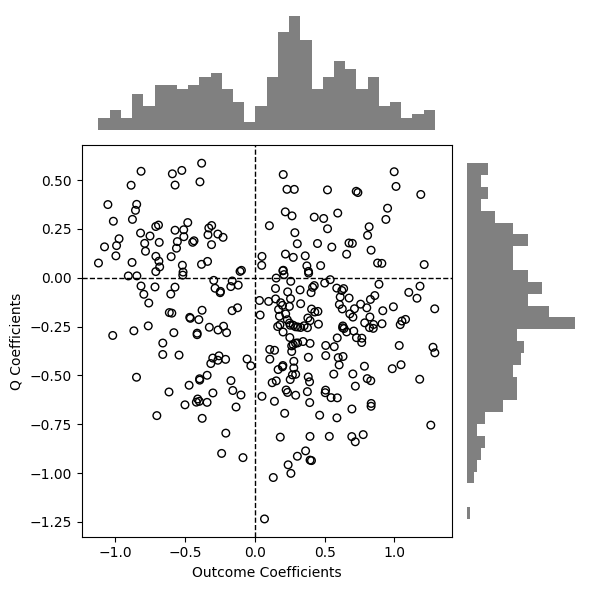

In [28]:
# scatter and polar of 'outcome' and 'Qchosen'
c_or_t = 'T'

curr_p_int = model_combined[f'p_outcome:ipsi_{period}_{verion}'].values
curr_coefs_int = model_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 


curr_coefs_outcome = model_combined[f'coef_outcome_{period}_{verion}'].values
curr_coefs_q = model_combined[f'coef_Qchosen_{period}_{verion}'].values

curr_T_outcome = model_combined[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_T_q = model_combined[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
curr_p_outcome = model_combined[f'p_outcome_{period}_{verion}'].values  # get the p-values for the reward outcome


# curr_T_outcome = all_Tm[:, outcome_ind]  # get the T-statistics for the reward outcome
# curr_T_q = all_Tm[:, q_ind]  # get the T-statistics for the Qchosen
# curr_p_outcome = all_pm[:, outcome_ind]  # get the p-values for the reward outcome

# curr_T_outcome = model_combined['outcome_T'].values  # get the T-statistics for the reward outcome
# curr_T_q = model_combined['Qchosen_T'].values  # get the T-statistics for the Qchosen
# curr_p_outcome = model_combined['outcome_p'].values  # get the p-values for the reward outcome

# curr_coefs_outcome = model_combined['outcome_coef'].values  # get the coefficients for the reward outcome
# curr_coefs_q = model_combined['Qchosen_coef'].values  # get the coefficients for the Qchosen
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Example data
# curr_coefs_outcome = ...
# curr_coefs_int = ...

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(curr_coefs_outcome, curr_coefs_q, color='none', edgecolors='k', s=30, label='outcome p<0.05')
ax_scatter.axhline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.axvline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.set_xlabel('Outcome Coefficients')
ax_scatter.set_ylabel('Q Coefficients')

# Histogram for X-axis
ax_histx.hist(curr_coefs_outcome, bins=30, color='gray')
ax_histx.axis('off')  # hide ticks and labels

# Histogram for Y-axis (horizontal)
ax_histy.hist(curr_coefs_q, bins=30, color='gray', orientation='horizontal')
ax_histy.axis('off')  # hide ticks and labels

plt.tight_layout()
plt.show()


# plot behavior coeffs in space

In [21]:
from matplotlib.colors import Normalize
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

norm = Normalize(vmin=0, vmax=1)
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
mesh_vertices_mm[:, ml] = -mesh_vertices_mm[:, ml]
blue_white_red = LinearSegmentedColormap.from_list(
    'blue_white_red',
    [(0, 'red'), (0.5, 'white'), (1.0, 'blue')]
)

features_beh = model_combined.columns.tolist()
features_beh.remove('session')
features_beh.remove('unit_id')
# drop all features ending with '_p'
features_beh = [f for f in features_beh if not f.startswith('p_') and not f.endswith('_p')]
# features_beh.append('T')
features_beh.remove('selected')

In [22]:
features_resp = response_tbl.columns.tolist()
features_resp = [f for f in features_resp if ('T_' in f) and ('Intercept' not in f) and ('amp' not in f)]
features_resp.append('bl_response_corr')

## Spatial distribution of values, face

In [23]:
features_to_plot = ['outcome_contra', 'outcome_ipsi', 'theta_com',
                    't_outcome|(|t_outcome| + |t_Q|)', 'coef_outcome|(|coef_outcome| + |coef_Q|)',
                    'T', 'coef_ipsi_com_mc', 'coef_ipsi_l_ori', 'coef_Qchosen_l_ori',
                    'T_ipsi_e_mc', 'T_ipsi_l_mc']

In [24]:
def project_to_plane(verts, plane_axes, pitch=0.02, margin=0.5):
    """Project 3D mesh vertices to a 2D binary mask and return contours in mm."""
    X, Y = plane_axes
    pts = verts[:, [X, Y]]

    # Grid setup
    mins = pts.min(axis=0) - margin
    maxs = pts.max(axis=0) + margin
    res = np.ceil((maxs - mins) / pitch).astype(int)

    mask = np.zeros(res[::-1], dtype=bool)
    # convert coordinates to pixel indices
    ij = ((pts - mins) / pitch).astype(int)
    ij = ij[(ij[:, 0] >= 0) & (ij[:, 1] >= 0) &
            (ij[:, 0] < res[0]) & (ij[:, 1] < res[1])]
    mask[ij[:, 1], ij[:, 0]] = True
    mask = binary_dilation(mask, iterations=2)

    # extract contours and convert to mm coordinates
    contours = find_contours(mask.astype(float), 0.5)
    contour_mm = []
    for c in contours:
        x_mm = c[:, 1] * pitch + mins[0]
        y_mm = c[:, 0] * pitch + mins[1]
        contour_mm.append(np.column_stack((x_mm, y_mm)))
    return contour_mm


In [27]:
pip install scikit-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 128.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-image] [scikit-image]
Note: you may need to restart the kernel to use updated packages.


In [28]:
# precompute mesh contours for each plane (for speed)
from scipy.stats import rankdata
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}

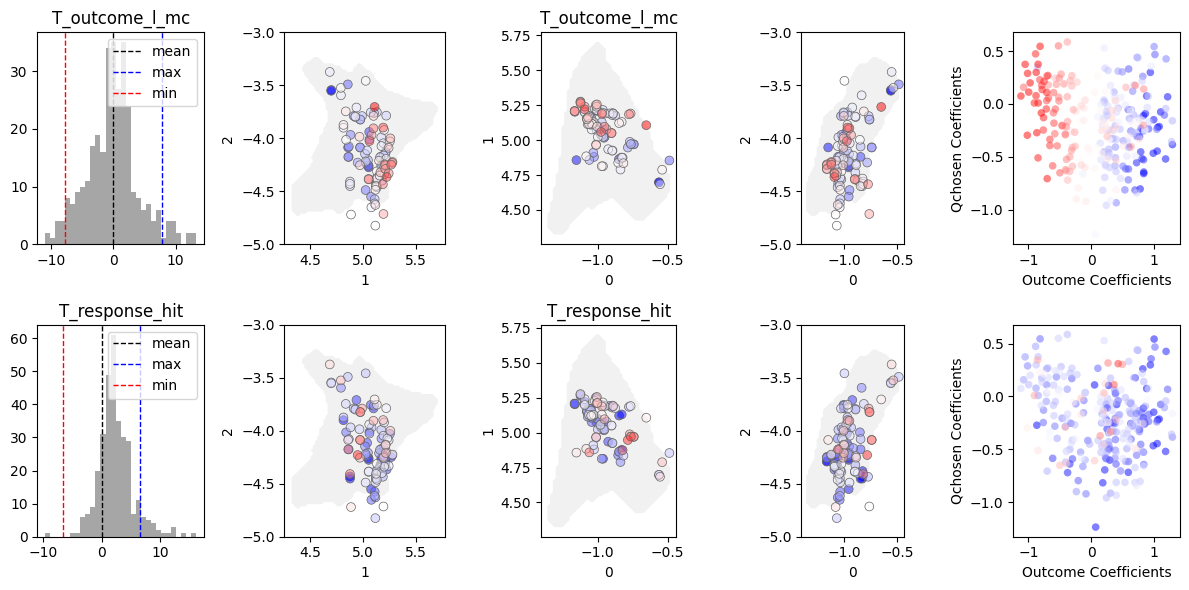

In [34]:
p_curr = features_combined['p_outcome_com_mc'].values
mask = p_curr < 1
mask = mask & features_combined['be_filter'].values
# mask = mask & features_combined['selected'].values
# features_to_plot = ['t_outcome|(|t_outcome| + |t_Q|)', 'theta_e', 'theta_l', 'theta_com', 'outcome_ipsi', 'coef_outcome|(|coef_outcome| + |coef_Q|)']
features_to_plot = ['T_outcome_l_mc', 'T_response_hit']
fig, axes = plt.subplots(len(features_to_plot), 5, figsize=(12, 3 * len(features_to_plot)))
axes = np.atleast_2d(axes)

# --- 3D anatomical points ---
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for ind, feature in enumerate(features_to_plot):
    color = features_combined[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize colors to 0–1 ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.92)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        center_line = 0
        upper_limit = amp_cut
        lower_limit = -amp_cut
        # color_reg[~np.isnan(color_reg)] = rankdata(color_reg[~np.isnan(color_reg)]) / len(color_reg[~np.isnan(color_reg)])
        # === Colormap ===
        custom_cmap = LinearSegmentedColormap.from_list(
            'blue_white_red', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
        # custom_cmap = LinearSegmentedColormap.from_list('white_red', [(0.0, 'white'), (1.0, 'black')])

    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.min(color_reg))/(amp_cut - np.min(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        center_line = np.nanmean(color)
        lower_limit = np.nanmin(np.abs(color)) * np.sign(center_line)
        upper_limit = amp_cut * np.sign(center_line)
        # === Colormap ===
        custom_cmap = LinearSegmentedColormap.from_list('white_red', [(0.0, 'white'), (1.0, 'red')])

    # color_reg[np.isnan(color_reg)] = 0.5

    # === Histogram of feature values ===
    ax_hist = axes[ind, 0]
    ax_hist.hist(features_combined[feature].values, bins=30, color='gray', alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color='k', linestyle='--', linewidth=1, label='mean')
    ax_hist.axvline(upper_limit, color='blue', linestyle='--', linewidth=1, label = 'max')
    ax_hist.axvline(lower_limit, color='red', linestyle='--', linewidth=1, label = 'min')
    ax_hist.legend()

    # === Compute alpha scaling from rho ===
    alpha_scale = features_combined['rho'].values[mask]
    alpha_scale = np.sqrt(alpha_scale)               # soften scaling
    alpha_scale = np.clip(alpha_scale, 0.2, 0.8)     # prevent extremes

    # === Sort and filter ===
    sort_ind = np.argsort(color_reg[mask])[::-1]
    ccfs_plot = ccfs[mask][sort_ind]
    color_reg_plot = color_reg[mask][sort_ind]
    alpha_scale_plot = alpha_scale[sort_ind]

    # === Precompute RGBA facecolors ===
    rgba_colors = custom_cmap(color_reg_plot)
    # rgba_colors[:, -1] = alpha_scale_plot  # inject alpha per point
    rgba_colors[:, -1] = 0.5  # fixed alpha

    # === 2D plane projections ===
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # background mesh outline
        # ax.scatter(
        #     mesh_vertices_mm[:, planes[plane][0]],
        #     mesh_vertices_mm[:, planes[plane][1]],
        #     color='k', alpha=0.4, s=0.05, edgecolors='none'
        # )
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # scatter the points (alpha-scaled)
        sc = ax.scatter(
            ccfs_plot[:, planes[plane][0]],
            ccfs_plot[:, planes[plane][1]],
            facecolors=rgba_colors,
            edgecolors=[0.4, 0.4, 0.4],
            s=40,
            linewidths=0.5,
        )

        if plane == 'hor':
            ax.set_title(feature)
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

        if planes[plane][1] == dv:
            ax.set_ylim([-5, -3])
    
    if len(feature.split("_"))>=2:
        if feature.split("_")[1] in ['e', 'l', 'com']:
            period = feature.split("_")[1]
        else:
            period = 'com'
    else:
        period = 'com'
    ax = axes[ind, -1]
    ax.scatter(
        features_combined[f'coef_outcome_{period}_mc'][mask].values[sort_ind],
        features_combined[f'coef_Qchosen_{period}_mc'][mask].values[sort_ind],
        color=rgba_colors, edgecolors='none', s=30,
    )
    ax.set_xlabel('Outcome Coefficients')
    ax.set_ylabel('Qchosen Coefficients')

plt.tight_layout()
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(os.path.join(beh_folder, f'model_combined_spatial_{criteria_name}.{ext}'),
                bbox_inches='tight', dpi=300)
# plt.close()


## Spatial distribution of values, edge

IndexError: boolean index did not match indexed array along axis 0; size of axis is 318 but size of corresponding boolean axis is 311

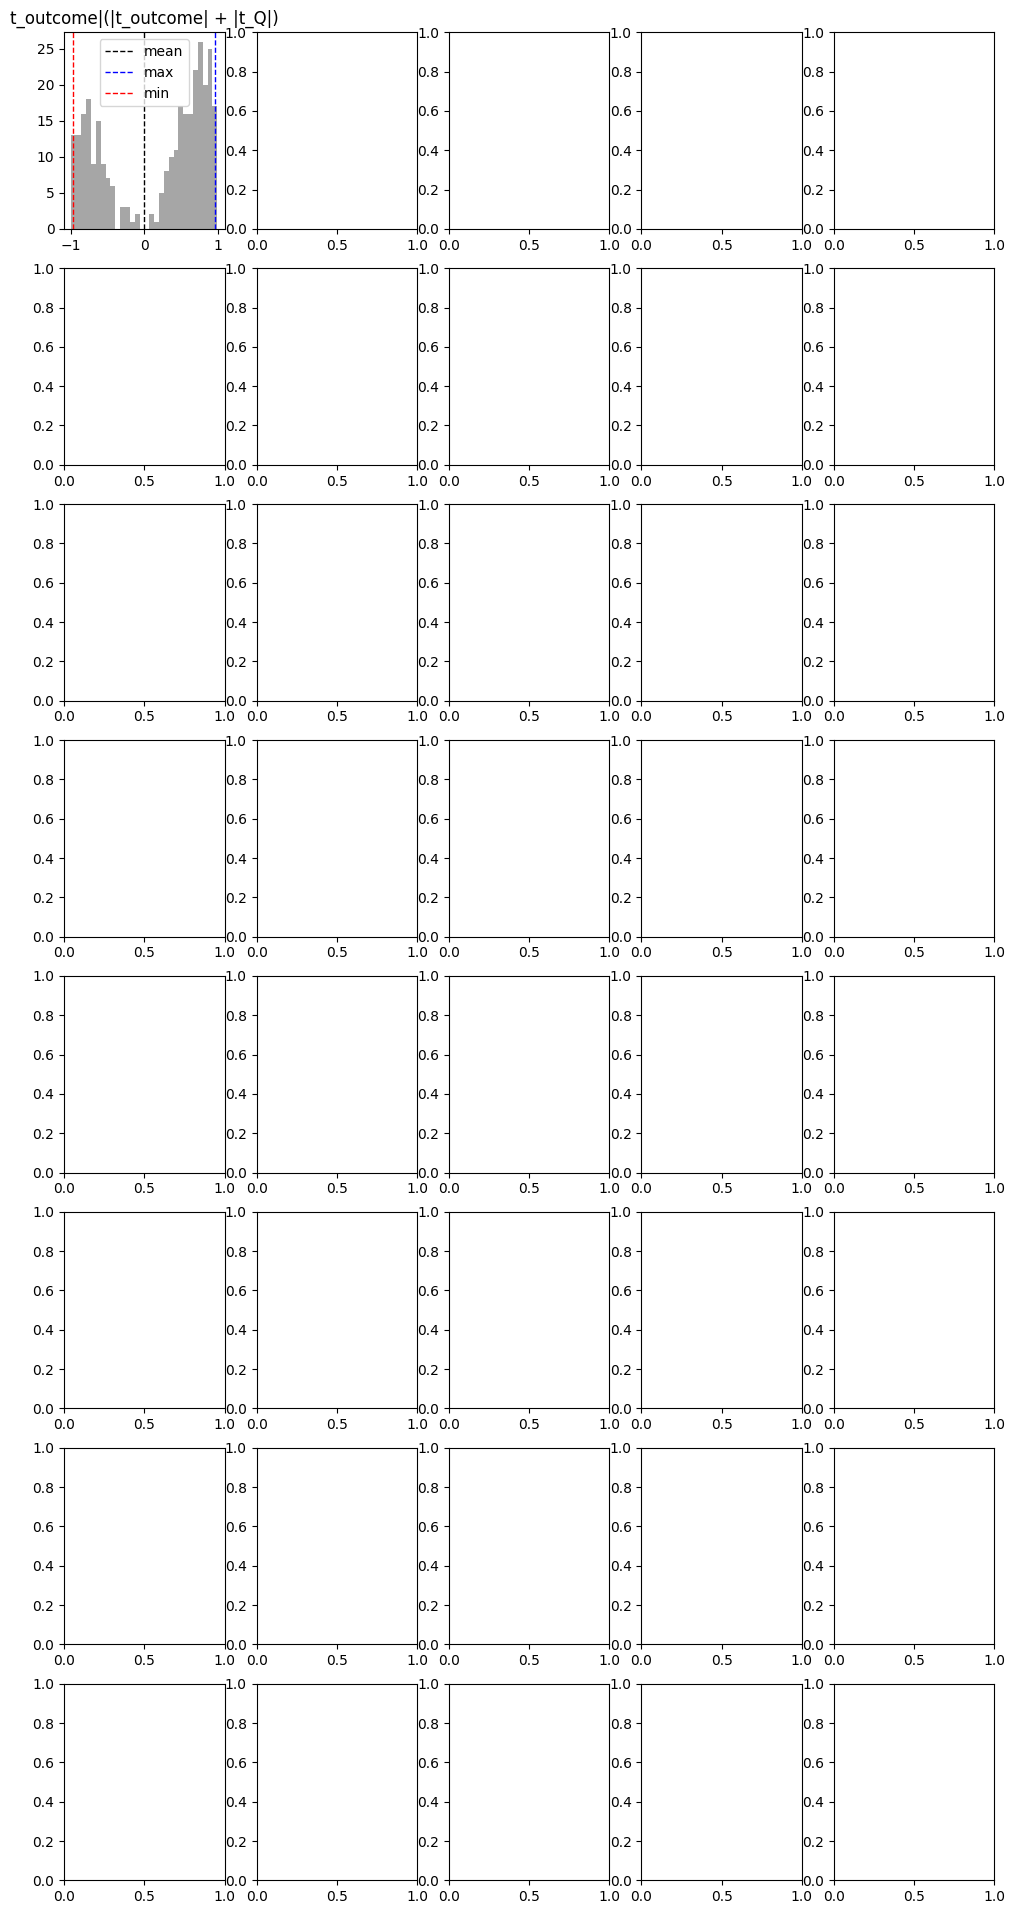

In [31]:
p_curr = model_combined['p_outcome_com_mc'].values
mask = (p_curr < 1)
features_to_plot = [
    't_outcome|(|t_outcome| + |t_Q|)',
    'theta_e', 'theta_l', 'theta_com', 'theta', 'outcome_contra',
    'outcome_ipsi', 'coef_outcome|(|coef_outcome| + |coef_Q|)'
]
# features_to_plot = ['theta']

versions = ['e', 'l', 'com']
for version in versions:
    all_vec = np.column_stack((
        model_combined[f'coef_outcome_{version}_mc'],
        model_combined[f'coef_Qchosen_{version}_ori']
    ))
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
    bound_1, bound_2, bound_3 = -(1 / 4) * np.pi, np.pi, -np.pi
    theta_scaled_dis = np.zeros_like(theta)
    for ind, angle_curr in enumerate(theta):
        if bound_1 < angle_curr <= bound_2:
            theta_scaled_dis[ind] = (angle_curr - bound_1) / (bound_2 - bound_1)
        else:
            theta_scaled_dis[ind] = (bound_1 - angle_curr) / (bound_1 - bound_3)
    theta_scaled_dis_all = 1 - theta_scaled_dis - 0.5
    model_combined[f'theta_{version}'] = theta_scaled_dis_all

# derived features
model_combined['coef_outcome|(|coef_outcome| + |coef_Q|)'] = (
    model_combined['coef_outcome_com_mc'] /
    (np.abs(model_combined['coef_outcome_com_mc']) + np.abs(model_combined['coef_Qchosen_com_mc']))
)
model_combined['outcome_ipsi'] = (
    model_combined['coef_outcome_com_mc'] + model_combined['coef_outcome:ipsi_com_mc']
)
model_combined['outcome_contra'] = (
    model_combined['coef_outcome_com_mc'] - model_combined['coef_outcome:ipsi_com_mc']
)

# --- setup figure grid ---
fig, axes = plt.subplots(len(features_to_plot), 5, figsize=(12, 3 * len(features_to_plot)))
axes = np.atleast_2d(axes)

# --- anatomical coordinates ---
ccfs = combined_tagged_units_filtered[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for ind, feature in enumerate(features_to_plot):
    color = model_combined[feature].values.astype(float)
    color_reg = color.copy()

    # === normalize color range ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        center_line = 0
        upper_limit = amp_cut
        lower_limit = -amp_cut
        custom_cmap = LinearSegmentedColormap.from_list(
            'blue_white_red',
            [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.min(color_reg)) / (amp_cut - np.min(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        center_line = np.nanmean(color)
        lower_limit = np.nanmin(np.abs(color)) * np.sign(center_line)
        upper_limit = amp_cut * np.sign(center_line)
        custom_cmap = LinearSegmentedColormap.from_list(
            'white_red', [(0.0, 'white'), (1.0, 'red')]
        )

    color_reg[np.isnan(color_reg)] = 0.5

    # === histogram ===
    ax_hist = axes[ind, 0]
    ax_hist.hist(model_combined[feature].values, bins=30, color='gray', alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color='k', linestyle='--', linewidth=1, label='mean')
    ax_hist.axvline(upper_limit, color='blue', linestyle='--', linewidth=1, label='max')
    ax_hist.axvline(lower_limit, color='red', linestyle='--', linewidth=1, label='min')
    ax_hist.legend()

    # === alpha scaling (rho) ===
    alpha_scale = model_combined['rho'].values[mask]
    # alpha_scale = np.sqrt(alpha_scale)
    alpha_scale = np.clip(alpha_scale, 0.2, 1)

    # === sorting ===
    sort_ind = np.argsort(color_reg[mask])[::-1]
    ccfs_plot = ccfs[mask][sort_ind]
    color_reg_plot = color_reg[mask][sort_ind]
    alpha_scale_plot = alpha_scale[sort_ind]

    # === map color to edge RGBA ===
    edge_rgba = custom_cmap(color_reg_plot)
    # edge_rgba[:, -1] = alpha_scale_plot  # add per-point alpha

    # === 2D projections ===
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        ax.scatter(
            mesh_vertices_mm[:, planes[plane][0]],
            mesh_vertices_mm[:, planes[plane][1]],
            color='k', alpha=0.3, s=0.05, edgecolors='none'
        )

        # main scatter: edge gradient only
        ax.scatter(
            ccfs_plot[:, planes[plane][0]],
            ccfs_plot[:, planes[plane][1]],
            facecolors='none',
            edgecolors=edge_rgba,
            linewidths=1.5,
            s=30
        )

        if plane == 'hor':
            ax.set_title(feature)
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

        if planes[plane][1] == dv:
            ax.set_ylim([-5, -3])
    
    if len(feature.split("_"))>=2:
        if feature.split("_")[1] in ['e', 'l', 'com']:
            period = feature.split("_")[1]
        else:
            period = 'com'
    else:
        period = 'com'
    ax = axes[ind, -1]
    ax.scatter(
        model_combined[f'coef_outcome_{period}_mc'][mask].values[sort_ind],
        model_combined[f'coef_Qchosen_{period}_mc'][mask].values[sort_ind],
        color='none', edgecolors=edge_rgba, s=30
    )
    ax.set_xlabel('Outcome Coefficients')
    ax.set_ylabel('Qchosen Coefficients')

plt.tight_layout()
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(
        os.path.join(beh_folder, f'model_combined_spatial_edge_{criteria_name}.{ext}'),
        bbox_inches='tight', dpi=300
    )
# plt.close()


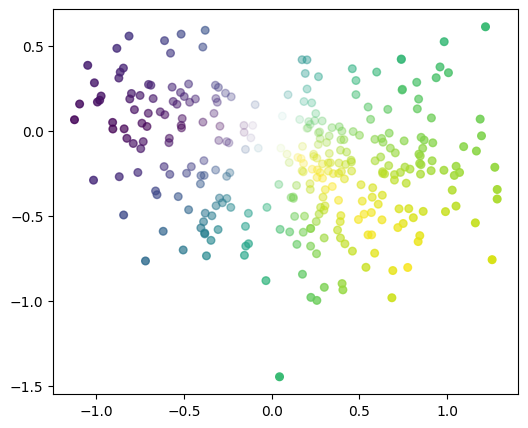

In [107]:
# Define viridis colormap and normalization
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=-0.5, vmax=0.5)

# Alpha = distance from 0.5 → scaled to 0–1 range
alpha_scale = np.sqrt(model_combined['rho'])
alpha_scale = np.clip(alpha_scale, 0, 1.2)
alpha_scale = (alpha_scale - np.min(alpha_scale)) / (np.max(alpha_scale) - np.min(alpha_scale))

# === sorting ===
sort_ind = np.argsort(color_reg[mask])[::-1]
ccfs_plot = ccfs[mask][sort_ind]
color_reg_plot = color_reg[mask][sort_ind]
alpha_scale_plot = alpha_scale[sort_ind]

# Map θ → viridis colors, then inject alpha per point
colors = cmap(norm(model_combined['theta'].values))
colors[:, -1] = alpha_scale  # assign alpha channel

# Create scatter using facecolors directly (so alpha is preserved)
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(
    model_combined['coef_outcome_com_mc'],
    model_combined['coef_Qchosen_com_mc'],
    facecolors=colors,
    edgecolors=None,
    s=30,
    marker='o'
)

## 3D plots

In [48]:


# --- Prepare mask and derived features ---
p_curr = features_combined['p_outcome_com_mc'].values
mask = p_curr < 1
mask = mask & features_combined['be_filter'].values
mask = mask & features_combined['selected'].values
# features_to_plot = ['t_outcome|(|t_outcome| + |t_Q|)', 'theta', 'test', 'T_outcome_com_ori']
# features_to_plot = features_beh
# model_combined['test'] = (
#     model_combined['coef_outcome_com_mc'] /
#     (np.abs(model_combined['coef_outcome_com_mc']) + np.abs(model_combined['coef_Qchosen_com_mc']))
# )

# --- Anatomical coordinates ---
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ml = 0
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for feature in features_to_plot:
    color = features_combined[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize color range to [0, 1] ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.9)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        custom_cmap = LinearSegmentedColormap.from_list(
            'bwr_custom', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.nanmin(color_reg)) / (amp_cut - np.nanmin(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        custom_cmap = LinearSegmentedColormap.from_list('wr_custom', [(0.0, 'white'), (1.0, 'red')])

    color_reg[np.isnan(color_reg)] = 0.5

    # === Alpha scaling (from rho) ===
    alpha_scale = features_combined['rho'].values[mask]
    alpha_scale = np.sqrt(alpha_scale)
    alpha_scale = np.clip(alpha_scale, 0.2, 0.9)

    # === Sort for proper rendering ===
    sort_ind = np.argsort(color_reg[mask])[::-1]
    ccfs_plot = ccfs[mask][sort_ind]
    color_reg_plot = color_reg[mask][sort_ind]
    alpha_scale_plot = alpha_scale[sort_ind]

    # === Map to RGBA, inject alpha ===
    rgba = custom_cmap(color_reg_plot)
    rgba[:, -1] = alpha_scale_plot
    rgb = (rgba[:, :3] * 255).astype(np.uint32)
    colors = (rgb[:, 0] << 16) + (rgb[:, 1] << 8) + rgb[:, 2]

    # --- Create interactive K3D plot ---
    plt_3d = k3d.plot(
        camera_auto_fit=True,
        background_color=0x000000,
        grid_visible=False
    )

    # --- Optional: anatomical mesh if available ---
    if 'mesh_vertices_mm' in locals() and 'mesh' in locals():
        faces = np.array(mesh.faces).astype(np.uint32)
        plt_3d += k3d.mesh(
            mesh_vertices_mm.astype(np.float32),
            faces,
            color=0x888888,
            opacity=0.1
        )

    # # --- Scatter points with per-point alpha ---
    # pts = k3d.points(
    #     positions=ccfs_plot.astype(np.float32),
    #     colors=colors.astype(np.uint32),
    #     point_size=0.05,
    #     shader='3d',
    #     opacity=1.0
    # )

    for ind in range(len(ccfs_plot)):
        pt = k3d.points(
            positions=ccfs_plot[ind:ind+1].astype(np.float32),
            colors=np.array([colors[ind]]).astype(np.uint32),
            point_size=0.05,
            shader='3d',
            # opacity=alpha_scale_plot[ind]
            opacity = 0.6,
        )
        plt_3d += pt

    # --- Add colorbar (sample colormap directly) ---
    color_map_for_bar = np.array(
        [custom_cmap(i / 255)[:3] for i in range(256)],
        dtype=np.float32
    )

    # plt_3d += k3d.color_map.ColorMap(
    #     color_map=color_map_for_bar,
    #     color_range=[np.nanmin(color), np.nanmax(color)],
    #     label=feature,
    #     position_x=0.02,
    #     position_y=0.85,
    #     width=0.015,
    #     height=0.5
    # )

    # --- Save to HTML ---
    html_path = os.path.join(beh_folder, '3D_links',f'k3d_{feature}_3D.html')
    os.makedirs(os.path.dirname(html_path), exist_ok=True)
    with open(html_path, 'w') as f:
        f.write(plt_3d.get_snapshot())

    print(f"✅ Saved interactive plot: {html_path}")


✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_ratio_hit_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_baseline_hit_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_response_hit_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_ratio_amp_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_baseline_amp_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_response_amp_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_ratio_svs_3D.html


✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_baseline_svs_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_response_svs_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_ratio_ipsi_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_baseline_ipsi_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_response_ipsi_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_ratio_Intercept_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_baseline_Intercept_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_response_Intercept_3D.html


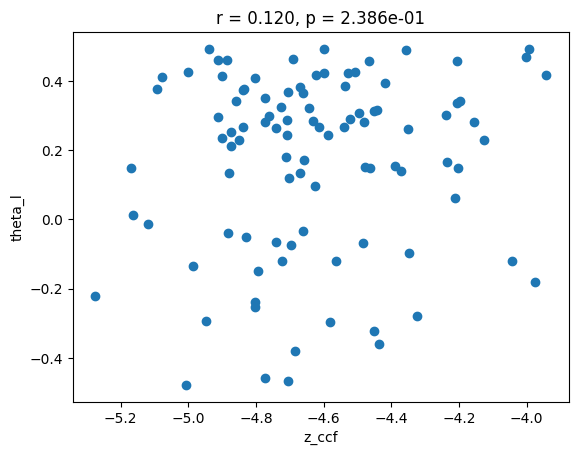

In [29]:
from scipy.stats import pearsonr
x_feature = 'z_ccf' 
y_feature = 'theta_l'
if x_feature == 'x_ccf':
    x = np.abs(combined_tagged_units_filtered[x_feature] + bregma_points_mm[2])
else:
    x = combined_tagged_units_filtered[x_feature]
y = model_combined[y_feature]
z = combined_tagged_units_filtered['z_ccf']

# Remove NaNs from both x and y
mask = ~(np.isnan(x) | np.isnan(y)) & (z<-3.5)
x = x[mask]
y = y[mask]

plt.scatter(x, y)

# correlation and p-value
corr, p = pearsonr(x, y)

plt.title(f"r = {corr:.3f}, p = {p:.3e}")
plt.xlabel(x_feature)
plt.ylabel(y_feature)

plt.savefig(os.path.join(beh_folder, f'correlation_{x_feature}_vs_{y_feature}_{criteria_name}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(beh_folder, f'correlation_{x_feature}_vs_{y_feature}_{criteria_name}.svg'), bbox_inches='tight')
plt.show()


In [192]:
# pca in basic ephys features
focus_features = ['T_baseline_hit', 'T_response_hit',
                'T_baseline_svs', 'T_response_svs',
                'T_baseline_ipsi', 'T_response_ipsi']
target_folder = os.path.join(beh_folder, 'response_spatial_features')

focus_features = ['T_Qchosen_e_mc',
                'T_ipsi_e_mc', 'T_ipsi_com_mc',
                'T_outcome:ipsi_e_mc',
                'T_outcome_l_mc',
                'T_ipsi_l_mc', 'T_outcome_com_mc',
                'T_Qchosen_com_mc', 't_outcome|(|t_outcome| + |t_Q|)',
                # 'coef_outcome|(|coef_outcome| + |coef_Q|)',
                'outcome_contra', 'outcome_ipsi']
target_folder = os.path.join(beh_folder, 'outcome_spatial_features')

focus_features = ['T_outcome:ipsi_e_mc',
                'T_outcome_l_mc',
                'T_outcome_com_mc',
                'T_ipsi_e_mc',
                # 'T_ipsi_com_mc',
                'T_baseline_hit',
                'T_response_hit',
                'T_baseline_svs',
                'T_response_svs']

target_folder = os.path.join(beh_folder, 'outcome_response_spatial_features')

focus_features = ['T_outcome:ipsi_e_mc',
                'T_outcome_l_mc',
                'T_outcome_com_mc',
                'T_ipsi_e_mc',
                # 'T_ipsi_com_mc',
                # 'T_baseline_hit',
                # 'T_response_hit',
                # 'T_baseline_svs',
                # 'T_response_svs', 
                # 'T_ratio_svs',
                'T_Qchosen_com_mc',
                ]

target_folder = os.path.join(beh_folder, 'outcome_response_Q_spatial_features')
filter = features_combined['be_filter'].values
os.makedirs(target_folder, exist_ok=True)

In [193]:
print(features_combined.columns.tolist())

['session', 'unit_id', 'T_Qchosen_e_ori', 'T_outcome_e_ori', 'T_ipsi_e_ori', 'T_outcome:ipsi_e_ori', 'T_amp_abs_e_ori', 'T_Qchosen_l_ori', 'T_outcome_l_ori', 'T_ipsi_l_ori', 'T_outcome:ipsi_l_ori', 'T_amp_abs_l_ori', 'T_Qchosen_com_ori', 'T_outcome_com_ori', 'T_ipsi_com_ori', 'T_outcome:ipsi_com_ori', 'T_amp_abs_com_ori', 'T_Qchosen_e_mc', 'T_outcome_e_mc', 'T_ipsi_e_mc', 'T_outcome:ipsi_e_mc', 'T_amp_abs_e_mc', 'T_Qchosen_l_mc', 'T_outcome_l_mc', 'T_ipsi_l_mc', 'T_outcome:ipsi_l_mc', 'T_amp_abs_l_mc', 'T_Qchosen_com_mc', 'T_outcome_com_mc', 'T_ipsi_com_mc', 'T_outcome:ipsi_com_mc', 'T_amp_abs_com_mc', 'p_Qchosen_e_ori', 'p_outcome_e_ori', 'p_ipsi_e_ori', 'p_outcome:ipsi_e_ori', 'p_amp_abs_e_ori', 'p_Qchosen_l_ori', 'p_outcome_l_ori', 'p_ipsi_l_ori', 'p_outcome:ipsi_l_ori', 'p_amp_abs_l_ori', 'p_Qchosen_com_ori', 'p_outcome_com_ori', 'p_ipsi_com_ori', 'p_outcome:ipsi_com_ori', 'p_amp_abs_com_ori', 'p_Qchosen_e_mc', 'p_outcome_e_mc', 'p_ipsi_e_mc', 'p_outcome:ipsi_e_mc', 'p_amp_abs_e_mc

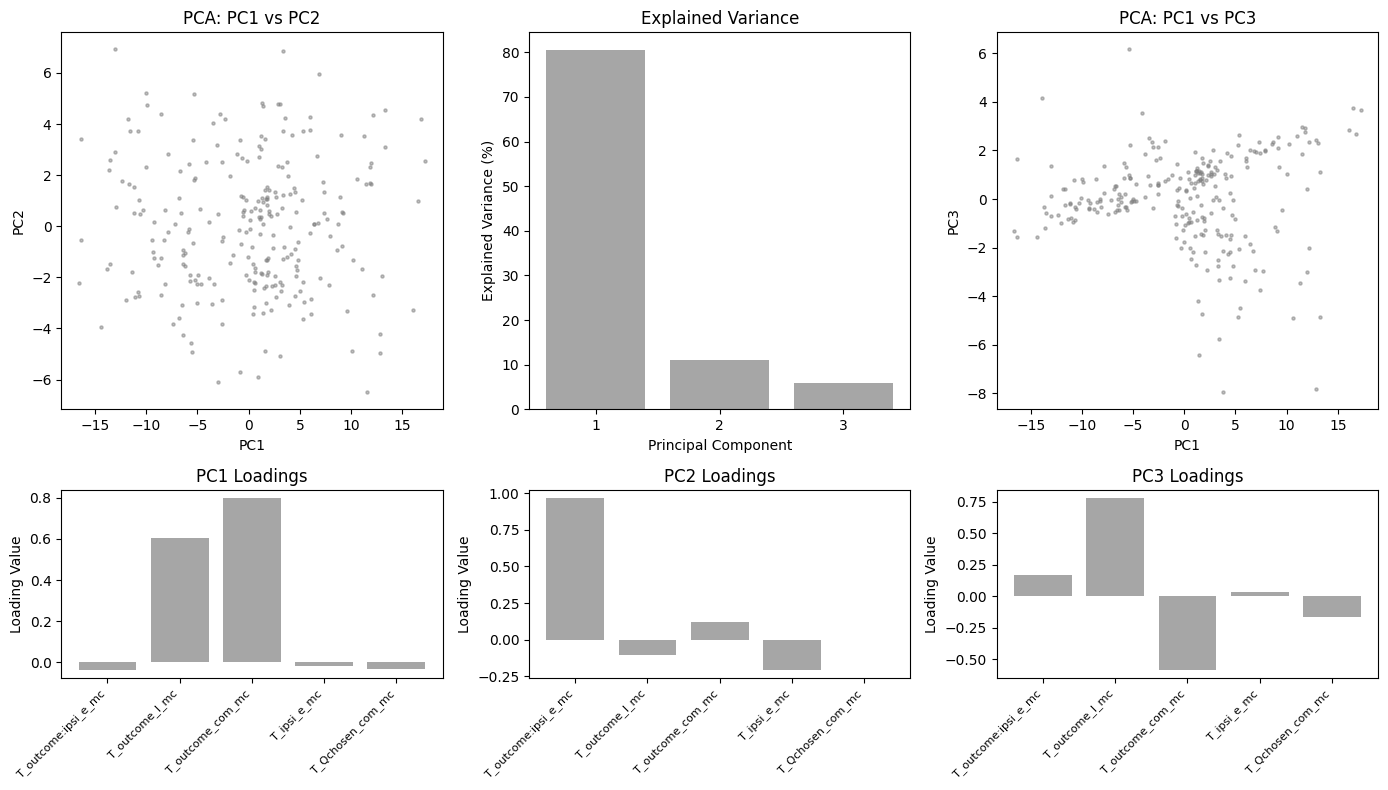

In [195]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import zscore

# --- Prepare data ---
feature_mat = features_combined[focus_features].values[filter]
nan_ind = np.isnan(feature_mat).any(axis=1)
feature_mat = feature_mat[~nan_ind]

# z-score (standardize features)
feature_mat[:, -2:] = zscore(feature_mat[:, -2:], axis=0, nan_policy='omit')

# --- Run PCA ---
pca = PCA(n_components=3)
pca_result = pca.fit_transform(feature_mat)
explained_var = pca.explained_variance_ratio_
components = pca.components_

# --- Create one big figure ---
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 3, height_ratios=[2, 1])  # top: scatter+var, bottom: loadings

# (1) PC1 vs PC2 scatter
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(pca_result[:, 0], pca_result[:, 1], c='gray', alpha=0.5, s=5)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PCA: PC1 vs PC2')

# (2) explained variance ratio
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(range(1, len(explained_var)+1), explained_var*100, color='gray', alpha=0.7)
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Explained Variance (%)')
ax2.set_title('Explained Variance')
ax2.set_xticks(range(1, len(explained_var)+1))

# (3) PC1 vs PC3 scatter (optional global pattern)
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(pca_result[:, 0], pca_result[:, 2], c='gray', alpha=0.5, s=5)
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC3')
ax3.set_title('PCA: PC1 vs PC3')

# (4) feature loadings for first 3 PCs
for i in range(3):
    ax = fig.add_subplot(gs[1, i])
    ax.bar(focus_features, components[i], color='gray', alpha=0.7)
    ax.set_title(f'PC{i+1} Loadings')
    ax.set_ylabel('Loading Value')
    ax.set_xticks(range(len(focus_features)))
    ax.set_xticklabels(focus_features, rotation=45, ha='right', fontsize=8)

fig.tight_layout()
fig.savefig(os.path.join(target_folder, 'PCA_basic_ephys_features_summary.pdf'), bbox_inches='tight')
plt.show()


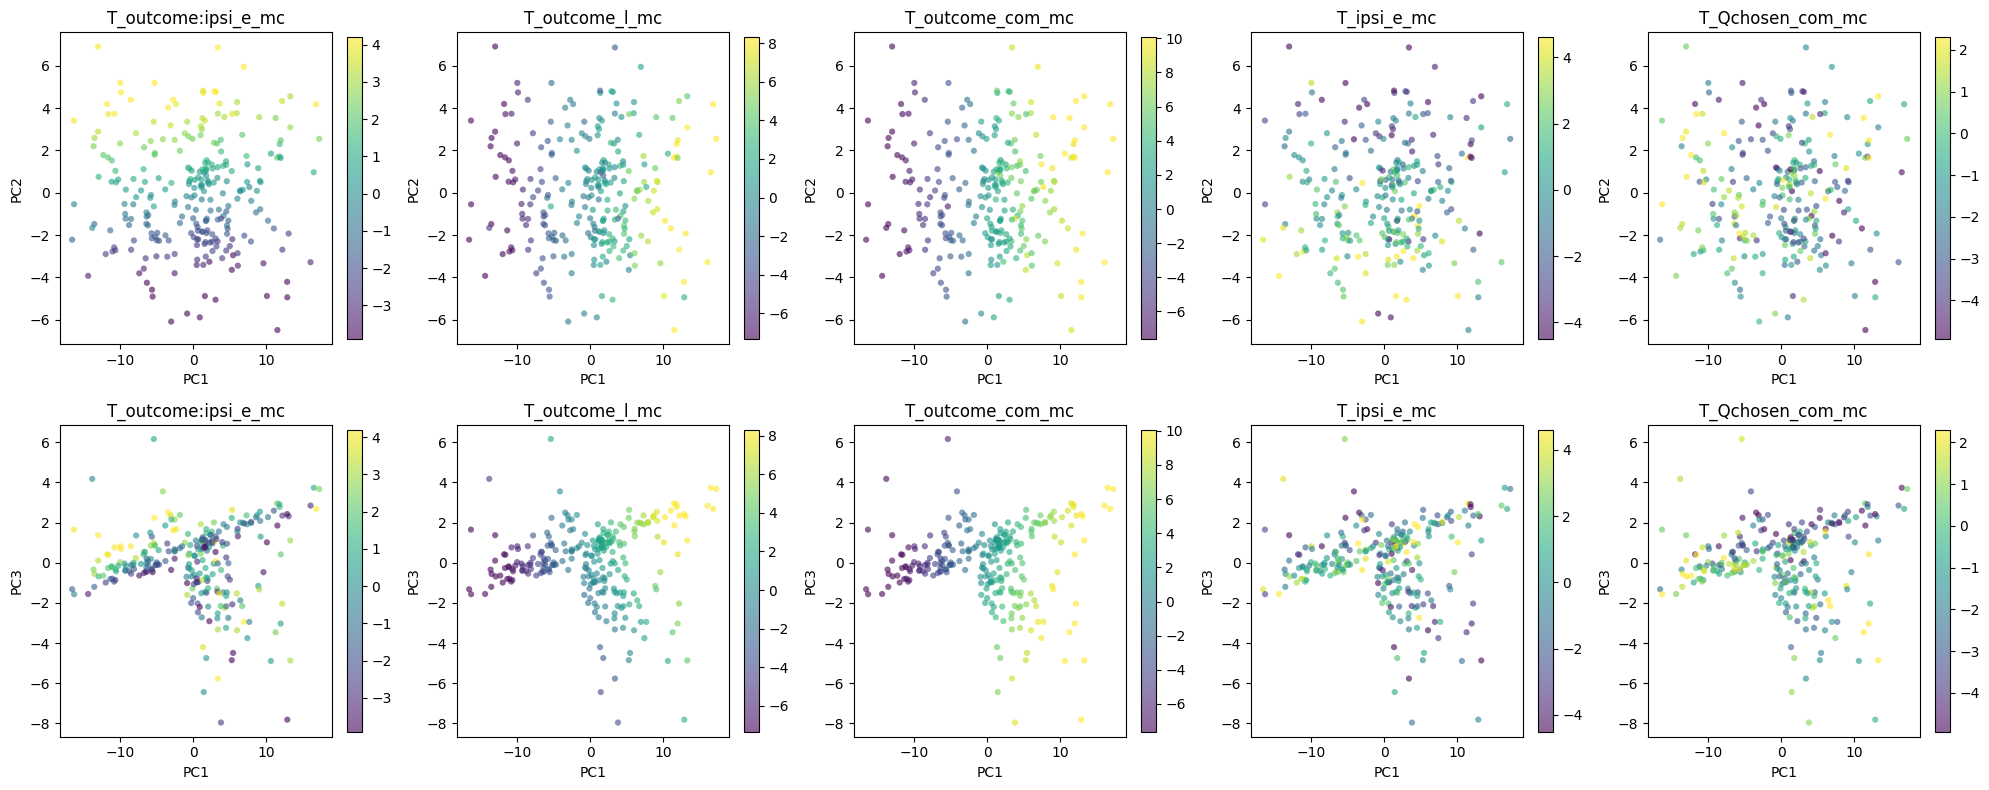

In [196]:
# plot focus features in pc space

fig, axes = plt.subplots(2, len(focus_features), figsize=(4*len(focus_features), 8))
for i, feature in enumerate(focus_features):
    ax = axes[0, i]
    color_code_filtered = features_combined[feature].values[filter]
    # if it is boolean, convert to float
    if np.issubdtype(color_code_filtered.dtype, np.bool_):
        color_code_filtered = color_code_filtered.astype(float)
    # remove nan
    color_code_filtered = color_code_filtered[~nan_ind]
    # clip to 2.5-97.5 percentile
    top_90 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.95)
    bottom_10 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.05)
    color_code_filtered[color_code_filtered > top_90] = top_90
    color_code_filtered[color_code_filtered < bottom_10] = bottom_10
    # color_code_filtered = (color_code_filtered - bottom_10) / (top_90 - bottom_10)  # Normalize color code to [0, 1] using 10-90% quantiles

    sc = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=color_code_filtered, cmap='viridis', s=20, edgecolor='none', alpha=0.6)
    ax.set_title(feature)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)

    ax = axes[1, i]
    sc = ax.scatter(pca_result[:, 0], pca_result[:, 2], c=color_code_filtered, cmap='viridis', s=20, edgecolor='none', alpha=0.6)
    ax.set_title(feature)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC3')
    fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
fig.tight_layout()
fig.savefig(os.path.join(target_folder, 'PCA_features_by_beh_feature.pdf'), bbox_inches='tight')

In [197]:
# append pc 
pc_filtered = np.full((np.sum(filter), 3), np.nan)
pc_filtered[~nan_ind] = pca_result
features_combined['beh_pc_1'] = np.nan
features_combined['beh_pc_2'] = np.nan
features_combined['beh_pc_3'] = np.nan
features_combined.loc[filter, 'beh_pc_1'] = pc_filtered[:, 0]
features_combined.loc[filter, 'beh_pc_2'] = pc_filtered[:, 1]
features_combined.loc[filter, 'beh_pc_3'] = pc_filtered[:, 2]

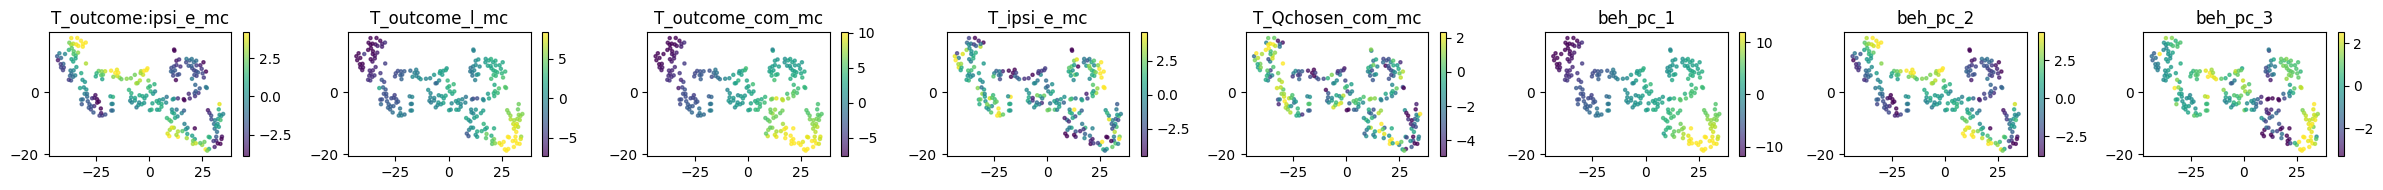

In [198]:
# try tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
tsne_result = tsne.fit_transform(feature_mat)
# plot focus features as color code
fig, axes = plt.subplots(1, len(focus_features)+3, figsize=(3*(len(focus_features)+3), 2))
for i, feature in enumerate(focus_features+['beh_pc_1', 'beh_pc_2', 'beh_pc_3']):
    ax = axes[i]
    color_code = features_combined[feature].values[filter]
    color_code = color_code[~nan_ind]
    # clip to 5-95 percentile
    top_90 = np.nanquantile(color_code, 0.95)
    bottom_10 = np.nanquantile(color_code, 0.05)
    color_code[color_code > top_90] = top_90
    color_code[color_code < bottom_10] = bottom_10
    sc = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c=color_code, cmap='viridis', s=5, alpha=0.7)
    ax.set_title(feature)
    plt.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(os.path.join(target_folder, 'TSNE_features_by_beh_feature.pdf'), bbox_inches='tight')


In [32]:
# try UMAP
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.2) #n_neighbors=30, min_dist=0.2
umap_result = reducer.fit_transform(feature_mat)
# plot focus features as color code
fig, axes = plt.subplots(1, len(focus_features)+3, figsize=(3*(len(focus_features)+3), 2))
for i, feature in enumerate(focus_features+['beh_pc_1', 'beh_pc_2', 'beh_pc_3']):
    ax = axes[i]
    color_code = features_combined[feature].values[filter]
    color_code = color_code[~nan_ind]
    # clip to 5-95 percentile
    top_90 = np.nanquantile(color_code, 0.95)
    bottom_10 = np.nanquantile(color_code, 0.05)
    color_code[color_code > top_90] = top_90
    color_code[color_code < bottom_10] = bottom_10
    sc = ax.scatter(umap_result[:, 0], umap_result[:, 1], c=color_code, cmap='viridis', s=5, alpha=0.7)
    ax.set_title(feature)
    plt.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(os.path.join(target_folder, 'UMAP_features_by_beh_feature.pdf'), bbox_inches='tight')

ModuleNotFoundError: No module named 'umap'

In [160]:
# add umap to basic_ephys_df
umap_filtered = np.full((np.sum(filter), 2), np.nan)
umap_filtered[~nan_ind] = umap_result
features_combined['beh_umap_1'] = np.nan
features_combined['beh_umap_2'] = np.nan
features_combined.loc[filter, 'beh_umap_1'] = umap_filtered[:, 0]
features_combined.loc[filter, 'beh_umap_2'] = umap_filtered[:, 1]


NameError: name 'umap_result' is not defined

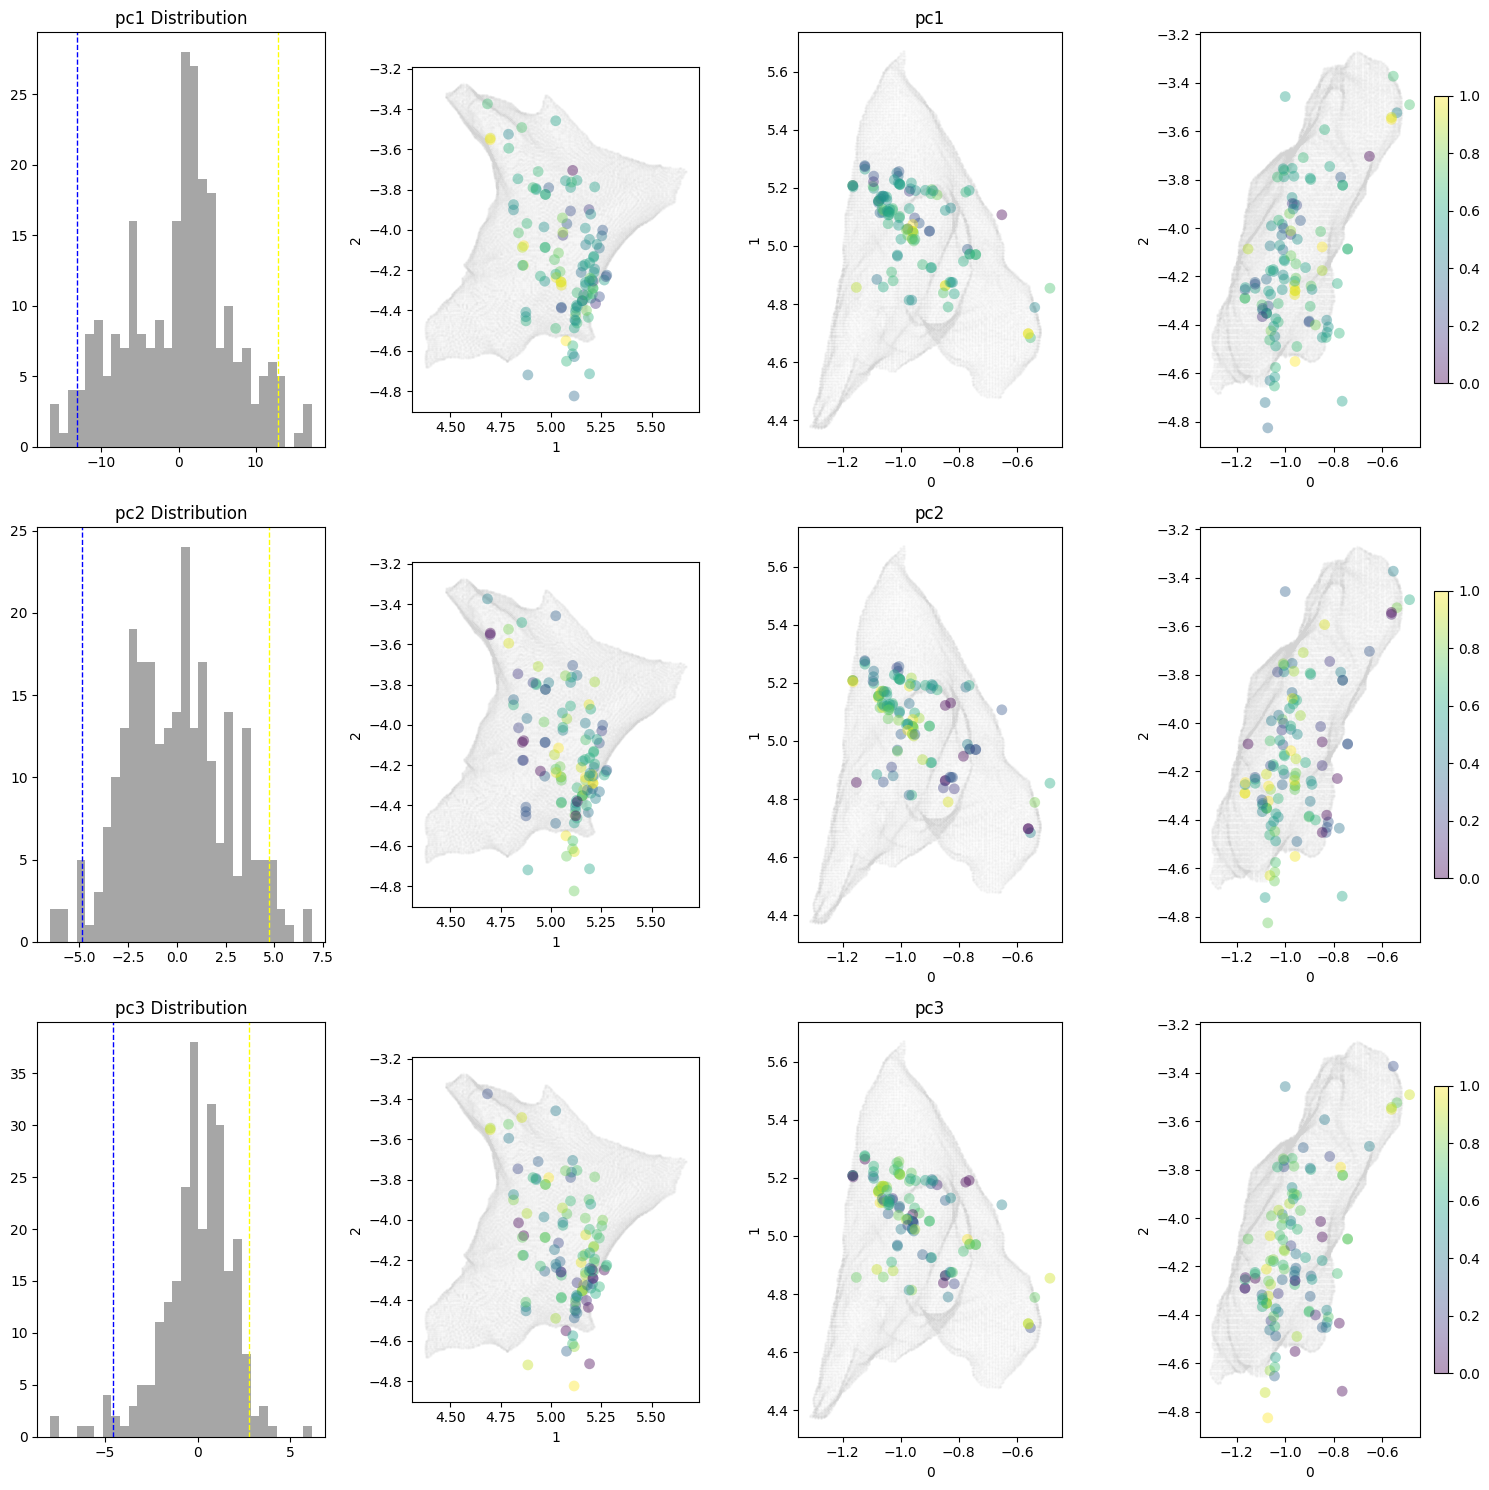

In [199]:
# plot pc values in 2D space using ccf locations as color code
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # Mirror ML to left
version = 'pc'
cmap = cm.viridis
for i in range(3):
    pc_values = features_combined[f'beh_{version}_{i+1}'].values[filter]
    # clip to 2.5-97.5 percentile
    top_90 = np.nanquantile(pc_values, 0.97)
    bottom_10 = np.nanquantile(pc_values, 0.03)
    pc_values_nl = np.clip(pc_values, bottom_10, top_90)
    pc_values_nl = (pc_values_nl - bottom_10) / (top_90 - bottom_10)
    pc_values_nl[np.isnan(pc_values_nl)] = 0.0
    # change to rank
    # pc_values_nl = rankdata(pc_values_nl) / len(pc_values_nl)

    rgba = cmap(pc_values_nl)
    rgb = (rgba[:, :3] * 255).astype(np.uint32)
    colors = (rgb[:, 0] << 16) + (rgb[:, 1] << 8) + rgb[:, 2]

    ax = axes[i, 0]
    ax.hist(pc_values, bins=30, color='gray', alpha=0.7)
    ax.set_title(f'{version}{i+1} Distribution')
    ax.axvline(top_90, color='yellow', linestyle='--', linewidth=1)
    ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)

    for j, plane in enumerate(planes.keys()):
        ax = axes[i, j+1]
        ax.scatter(mesh_vertices_lps[:, planes[plane][0]], mesh_vertices_lps[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.2)
        sc = ax.scatter(ccfs[:, planes[plane][0]], ccfs[:, planes[plane][1]], c=pc_values_nl, cmap='viridis', s=60, edgecolor='none', alpha=0.4)
        if plane == 'hor':
            ax.set_title(f'{version}{i+1}')
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')
        if plane == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'beh_{version}_in_space_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'beh_{version}_in_space_{criteria_name}.png'), dpi=300, bbox_inches='tight')



CCA CCF Component 1 Coefficients:
x_ccf: 0.5615
y_ccf: 0.6118
z_ccf: -0.5571
CCA CCF Component 2 Coefficients:
x_ccf: -0.6243
y_ccf: 0.7552
z_ccf: 0.2001
CCA CCF Component 3 Coefficients:
x_ccf: 0.5431
y_ccf: 0.2354
z_ccf: 0.8060


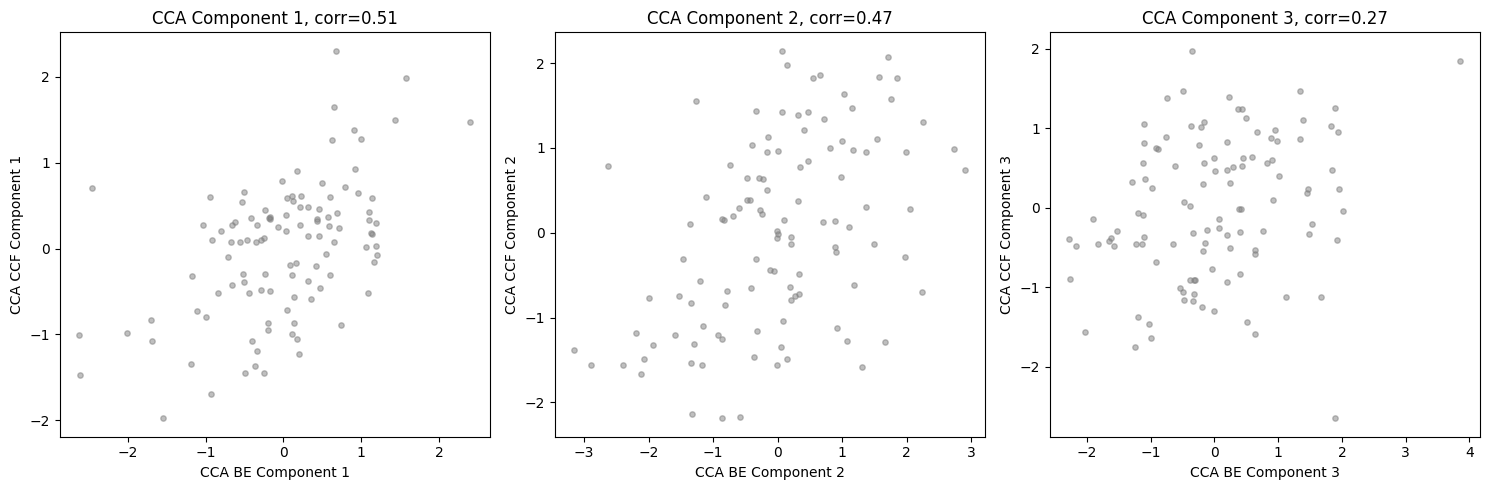

In [200]:
# cca in space
from sklearn.cross_decomposition import CCA
from scipy.stats import rankdata

focus_features_cca = focus_features
# focus_features_cca = focus_features+['beh_umap_1', 'beh_umap_2']
filter = features_combined['be_filter'].values
cca_be_mat = features_combined[focus_features_cca].values[filter]

bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = -np.abs(ccf_mat[:, ml])  # Mirror ML to left


# remove nan
nan_ind_cca = np.isnan(cca_be_mat).any(axis=1) | np.isnan(ccf_mat).any(axis=1)
cca_be_mat = cca_be_mat[~nan_ind_cca]
ccf_mat = ccf_mat[~nan_ind_cca]
# Convert to ranked values column-wise
ccf_mat_ranked = np.zeros_like(ccf_mat)
for i in range(ccf_mat.shape[1]):
    ccf_mat_ranked[:, i] = rankdata(ccf_mat[:, i], method='average')
ccf_mat = ccf_mat_ranked
# zscore
cca_be_mat = zscore(cca_be_mat, axis=0, nan_policy='omit')
# ccf_mat = zscore(ccf_mat, axis=0, nan_policy='omit')
cca = CCA(n_components=3)
cca_result_be, cca_result_ccf = cca.fit_transform(cca_be_mat, ccf_mat)
# plot cca result
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    ax.scatter(cca_result_be[:, i], cca_result_ccf[:, i], c='gray', alpha=0.5, s=15)
    ax.set_xlabel(f'CCA BE Component {i+1}')
    ax.set_ylabel(f'CCA CCF Component {i+1}')
    ax.set_title(f'CCA Component {i+1}, corr={np.corrcoef(cca_result_be[:, i], cca_result_ccf[:, i])[0, 1]:.2f}')
# # print coefficients
# cca_be_coeff = cca.x_weights_
# for i in range(3):
#     print(f'CCA BE Component {i+1} Coefficients:')
#     for j, feature in enumerate(focus_features):
#         print(f'  {feature}: {cca_be_coeff[j, i]:.4f}')
# print cca ccf coeff
cca_ccf_coeff = cca.y_weights_
for i in range(3):
    print(f'CCA CCF Component {i+1} Coefficients:')
    for j, axis in enumerate(['x_ccf', 'y_ccf', 'z_ccf']):
        print(f'{axis}: {cca_ccf_coeff[j, i]:.4f}')

fig.tight_layout()
fig.savefig(os.path.join(target_folder, 'CCA_beh_CCF_scatter.pdf'), bbox_inches='tight')


In [79]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# from sklearn.cross_decomposition import CCA

# # ==========================================================
# #   0. PREPARE ORIGINAL CCA FIT (assumes cca_be_mat, ccf_mat exist)
# # ==========================================================
# cca = CCA(n_components=2)
# cca_result_be, cca_result_ccf = cca.fit_transform(cca_be_mat, ccf_mat)

# xw = cca.x_weights_.copy()          # behavior weights
# yw = cca.y_weights_.copy()          # anatomical (CCF) weights

# n_samples = cca_be_mat.shape[0]
# n_features_be = cca_be_mat.shape[1]

# # Normalize original CCA anatomical vectors for plotting
# cca_vecs = yw / np.linalg.norm(yw, axis=0, keepdims=True)   # shape (3,2)


# # ==========================================================
# #   1. STRATIFIED 3D BOOTSTRAP IN CCF SPACE
# # ==========================================================

# coords = ccf_mat  # N × 3 anatomical coordinates
# alpha = 0.05
# # Number of bins per anatomical axis
# n_bins_xyz = (2, 2, 2)

# # Digitize coordinates into bins
# bins = [
#     np.linspace(coords[:, i].min(), coords[:, i].max(), n_bins_xyz[i] + 1)
#     for i in range(3)
# ]

# x_bin = np.digitize(coords[:, 0], bins[0]) - 1
# y_bin = np.digitize(coords[:, 1], bins[1]) - 1
# z_bin = np.digitize(coords[:, 2], bins[2]) - 1

# # Build voxel → list of datapoint indices
# from collections import defaultdict

# voxel_map = defaultdict(list)

# for i in range(len(coords)):
#     key = (x_bin[i], y_bin[i], z_bin[i])
#     voxel_map[key].append(i)

# # Only keep voxels that contain at least one datapoint
# valid_voxels = [v for v in voxel_map.keys() if len(voxel_map[v]) > 0]
# n_voxels = len(valid_voxels)
# sample_per_bin = np.ceil(n_samples / n_voxels).astype(int)

# # ==========================================================
# #   2. BOOTSTRAP LOOP (STRATIFIED SAMPLING)
# # ==========================================================

# n_boot = 1000
# rng = np.random.default_rng(0)

# boot_xw = np.zeros((n_boot, n_features_be, 2))
# boot_yw = np.zeros((n_boot, 3, 2))

# # Stratified bootstrap
# for b in range(n_boot):
#     indices = []

#     for voxel in valid_voxels:
#         actual_sample_bin = voxel_map[voxel].__len__()
#         picked = rng.choice(voxel_map[voxel], size=actual_sample_bin, replace=True)
#         indices.extend(picked)

#     indices = np.array(indices).flatten()

#     Xb = cca_be_mat[indices]
#     Yb = ccf_mat[indices]

#     cca_b = CCA(n_components=2)
#     cca_b.fit(Xb, Yb)

#     boot_xw[b] = cca_b.x_weights_
#     boot_yw[b] = cca_b.y_weights_

# # flip signs to align with original cca weights
# boot_yw_aligned = boot_yw.copy()
# boot_xw_aligned = boot_xw.copy()

# for comp in range(2):
#     ref = cca_ccf_coeff[:, comp]
#     for b in range(n_boot):
#         vec = boot_yw[b, :, comp]
#         if np.dot(vec, ref) < 0:
#             boot_yw_aligned[b, :, comp] *= -1
#             boot_xw_aligned[b, :, comp] *= -1
# boot_yw = boot_yw_aligned
# boot_xw = boot_xw_aligned
# # compute CI bounds
# xw_low  = np.percentile(boot_xw, 100 * alpha/2, axis=0)
# xw_high = np.percentile(boot_xw, 100 * (1 - alpha/2), axis=0)

# yw_low  = np.percentile(boot_yw, 100 * alpha/2, axis=0)
# yw_high = np.percentile(boot_yw, 100 * (1 - alpha/2), axis=0)

# # ================================================================
# #                   PRINT RESULTS WITH CI
# # ================================================================
# print("\n===== Behavior → CCA Weights (x_weights_) =====\n")
# for comp in range(2):
#     print(f"Component {comp+1}:")
#     for j, feat in enumerate(focus_features_cca):
#         mean_w = xw[j, comp]
#         lo = xw_low[j, comp]
#         hi = xw_high[j, comp]
#         print(f"  {feat:20s}  mean={mean_w:+.4f},  CI=({lo:+.4f}, {hi:+.4f})")
#     print()

# print("\n===== CCF → CCA Weights (y_weights_) =====\n")
# axes = ['x_ccf', 'y_ccf', 'z_ccf']
# for comp in range(2):
#     print(f"Component {comp+1}:")
#     for j, axname in enumerate(axes):
#         mean_w = yw[j, comp]
#         lo = yw_low[j, comp]
#         hi = yw_high[j, comp]
#         print(f"  {axname:10s}  mean={mean_w:+.4f},  CI=({lo:+.4f}, {hi:+.4f})")
#     print()


In [201]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cross_decomposition import CCA
from collections import defaultdict
alpha = 0.05
# ==========================================================
#   0. ORIGINAL CCA FIT
# ==========================================================
focus_features_cca = focus_features
# focus_features_cca = focus_features+['beh_umap_1', 'beh_umap_2']
filter = features_combined['be_filter'].values
cca_be_mat = features_combined[focus_features_cca].values[filter]

bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = -np.abs(ccf_mat[:, ml])  # Mirror ML to left

# remove nan
nan_ind_cca = np.isnan(cca_be_mat).any(axis=1) | np.isnan(ccf_mat).any(axis=1)
cca_be_mat = cca_be_mat[~nan_ind_cca]
ccf_mat = ccf_mat[~nan_ind_cca]

# Convert to ranked values column-wise
ccf_mat_ranked = np.zeros_like(ccf_mat)
for i in range(ccf_mat.shape[1]):
    ccf_mat_ranked[:, i] = rankdata(ccf_mat[:, i], method='average')
# ccf_mat = ccf_mat_ranked

cca = CCA(n_components=2)
cca_result_be, cca_result_ccf = cca.fit_transform(cca_be_mat, ccf_mat)

xw = cca.x_weights_.copy()
yw = cca.y_weights_.copy()

n_samples = cca_be_mat.shape[0]
n_features_be = cca_be_mat.shape[1]

# normalized anatomical CCA vectors
cca_vecs = yw / np.linalg.norm(yw, axis=0, keepdims=True)


# ==========================================================
#   1. BIN DATA INTO 3D VOXELS
# ==========================================================

coords = ccf_mat  # N×3 anatomical points

# choose bin counts
n_bins_xyz = (3, 3, 3)

bins = [
    np.linspace(coords[:, i].min()-0.1, coords[:, i].max()+0.1, n_bins_xyz[i] + 1)
    for i in range(3)
]

xbin = np.digitize(coords[:, 0], bins[0]) - 1
ybin = np.digitize(coords[:, 1], bins[1]) - 1
zbin = np.digitize(coords[:, 2], bins[2]) - 1

# voxel → sample indices
voxel_map = defaultdict(list)
for i in range(len(coords)):
    v = (xbin[i], ybin[i], zbin[i])
    voxel_map[v].append(i)

valid_voxels = [v for v in voxel_map if len(voxel_map[v]) > 0]

# number of points per voxel
counts = np.array([len(voxel_map[v]) for v in valid_voxels])
total_count = counts.sum()

# compute proportional sample counts per voxel
samples_per_voxel = np.maximum(
    1,  # ensure every voxel contributes
    np.floor((counts / total_count) * n_samples).astype(int)
)


# ==========================================================
#   2. BOOTSTRAP LOOP WITH PROPORTIONAL SAMPLING
# ==========================================================

n_boot = 1000
rng = np.random.default_rng(4)

boot_xw = np.zeros((n_boot, n_features_be, 2))
boot_yw = np.zeros((n_boot, 3, 2))

for b in range(n_boot):
    indices = []

    # sample proportionally from each voxel
    for vox_idx, voxel in enumerate(valid_voxels):
        n_draw = voxel_map[voxel].__len__()

        picked = rng.choice(
            voxel_map[voxel],
            size=n_draw,
            replace=True
        )
        indices.extend(picked)

    indices = np.array(indices)

    Xb = cca_be_mat[indices]
    Yb = ccf_mat[indices]

    cca_b = CCA(n_components=2)
    cca_b.fit(Xb, Yb)

    boot_xw[b] = cca_b.x_weights_
    boot_yw[b] = cca_b.y_weights_


# n_boot = 1000
# rng = np.random.default_rng(4)

# boot_xw = np.zeros((n_boot, n_features_be, 2))
# boot_yw = np.zeros((n_boot, 3, 2))

# for b in range(n_boot):
#     indices = []

#     # --- bootstrap sampling proportional to voxel size ---
#     for vox_idx, voxel in enumerate(valid_voxels):
#         n_draw = len(voxel_map[voxel])
#         picked = rng.choice(voxel_map[voxel], size=n_draw, replace=True)
#         indices.extend(picked)

#     indices = np.array(indices)

#     Xb = cca_be_mat[indices]
#     Yb = ccf_mat[indices]

#     # ====================================================
#     # 1️⃣ Fit first CCA component (normal)
#     # ====================================================
#     cca_b1 = CCA(n_components=1)
#     cca_b1.fit(Xb, Yb)

#     xw_1 = cca_b1.x_weights_[:, 0]
#     yw_1 = cca_b1.y_weights_[:, 0]

#     xw_1 /= np.linalg.norm(xw_1)
#     yw_1 /= np.linalg.norm(yw_1)

#     boot_xw[b, :, 0] = xw_1
#     boot_yw[b, :, 0] = yw_1

#     # ====================================================
#     # 2️⃣ Fit second component with fixed first axis
#     # ====================================================
#     # remove projections along the original fixed first axis
#     # (xw_ori, yw_ori are provided as fixed first-component weights)


#     # Normalize the first canonical axis only
#     xw_ori_1 = xw[:, 0]
#     yw_ori_1 = yw[:, 0]

#     xw_ori_1 = xw_ori_1 / np.linalg.norm(xw_ori_1)
#     yw_ori_1 = yw_ori_1 / np.linalg.norm(yw_ori_1)


#     Xb_res = Xb - (Xb @ xw_ori_1[:, None]) * xw_ori_1[None, :]
#     Yb_res = Yb - (Yb @ yw_ori_1[:, None]) * yw_ori_1[None, :]

#     # fit CCA on residuals for 2nd component
#     cca_b2 = CCA(n_components=1)
#     cca_b2.fit(Xb_res, Yb_res)

#     xw_2 = cca_b2.x_weights_[:, 0]
#     yw_2 = cca_b2.y_weights_[:, 0]

#     # xw_2 = xw_2 - np.dot(xw_2, xw_ori_1) * xw_ori_1
#     # yw_2 = yw_2 - np.dot(yw_2, yw_ori_1) * yw_ori_1

#     boot_xw[b, :, 1] = xw_2
#     boot_yw[b, :, 1] = yw_2


# ==========================================================
#  SIGN ALIGNMENT (recommended)
# ==========================================================

boot_yw_aligned = boot_yw.copy()
boot_xw_aligned = boot_xw.copy()

boot_yw_norm = (
    boot_yw_aligned /
    np.linalg.norm(boot_yw_aligned, axis=1, keepdims=True)
)

for comp in range(2):
    ref = cca_vecs[:, comp]
    for b in range(n_boot):
        if np.dot(boot_yw_norm[b, :, comp], ref) < 0:
            boot_yw_aligned[b, :, comp] *= -1
            boot_xw_aligned[b, :, comp] *= -1




boot_yw = boot_yw_aligned
boot_xw = boot_xw_aligned
# compute CI bounds
xw_low  = np.percentile(boot_xw, 100 * alpha/2, axis=0)
xw_high = np.percentile(boot_xw, 100 * (1 - alpha/2), axis=0)

yw_low  = np.percentile(boot_yw, 100 * alpha/2, axis=0)
yw_high = np.percentile(boot_yw, 100 * (1 - alpha/2), axis=0)

# ================================================================
#                   PRINT RESULTS WITH CI
# ================================================================
print("\n===== Behavior → CCA Weights (x_weights_) =====\n")
for comp in range(2):
    print(f"Component {comp+1}:")
    for j, feat in enumerate(focus_features_cca):
        mean_w = xw[j, comp]
        lo = xw_low[j, comp]
        hi = xw_high[j, comp]
        print(f"  {feat:20s}  mean={mean_w:+.4f},  CI=({lo:+.4f}, {hi:+.4f})")
    print()

print("\n===== CCF → CCA Weights (y_weights_) =====\n")
axes = ['x_ccf', 'y_ccf', 'z_ccf']
for comp in range(2):
    print(f"Component {comp+1}:")
    for j, axname in enumerate(axes):
        mean_w = cca_vecs[j, comp]
        lo = yw_low[j, comp]
        hi = yw_high[j, comp]
        print(f"  {axname:10s}  mean={mean_w:+.4f},  CI=({lo:+.4f}, {hi:+.4f})")
    print()


===== Behavior → CCA Weights (x_weights_) =====

Component 1:
  T_outcome:ipsi_e_mc   mean=+0.2122,  CI=(-0.5122, +0.7262)
  T_outcome_l_mc        mean=-0.5344,  CI=(-0.8145, -0.0037)
  T_outcome_com_mc      mean=-0.3642,  CI=(-0.6514, +0.1166)
  T_ipsi_e_mc           mean=-0.4375,  CI=(-0.7402, +0.1816)
  T_Qchosen_com_mc      mean=+0.5877,  CI=(+0.1258, +0.7034)

Component 2:
  T_outcome:ipsi_e_mc   mean=+0.8272,  CI=(+0.0007, +0.9347)
  T_outcome_l_mc        mean=-0.2893,  CI=(-0.7346, +0.4969)
  T_outcome_com_mc      mean=-0.0362,  CI=(-0.6660, +0.4890)
  T_ipsi_e_mc           mean=+0.3643,  CI=(-0.4812, +0.8027)
  T_Qchosen_com_mc      mean=-0.3129,  CI=(-0.7009, +0.3642)


===== CCF → CCA Weights (y_weights_) =====

Component 1:
  x_ccf       mean=+0.1427,  CI=(-0.7187, +0.6877)
  y_ccf       mean=+0.9590,  CI=(+0.2044, +0.9962)
  z_ccf       mean=-0.2446,  CI=(-0.7998, +0.3324)

Component 2:
  x_ccf       mean=-0.7242,  CI=(-0.9729, +0.2998)
  y_ccf       mean=+0.2697,  CI=(-0.

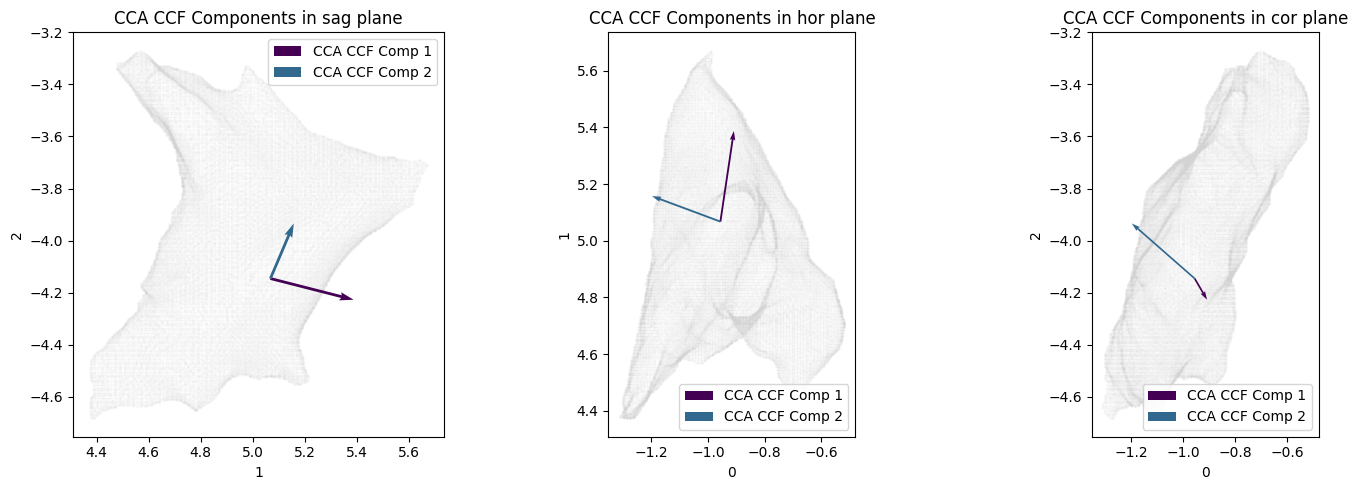

In [202]:
# plot cca ccf components weight in space as vector in ccf space with mesh
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = -np.abs(ccf_mat[:, ml])  # Mirror ML to left
for plane_ind, plane in enumerate(planes.keys()):
    ax = axes[plane_ind]
    ax.scatter(mesh_vertices_lps[:, planes[plane][0]], mesh_vertices_lps[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.2)
    for i in range(2):
        vec = cca_vecs[:, i]
        origin = np.nanmean(ccf_mat, axis=0)
        # origin = np.zeros(3)
        ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
                  vec[planes[plane][0]], vec[planes[plane][1]],
                  angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=cm.viridis(i/3))
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    ax.set_aspect('equal')
    ax.set_title(f'CCA CCF Components in {plane} plane')
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'CCA_CCF_components_in_space.pdf'), bbox_inches='tight')

In [203]:
boot_yw_norm = boot_yw_aligned / np.linalg.norm(boot_yw_aligned, axis=1, keepdims=True)
# boot_yw_norm = boot_yw_aligned
origin = np.nanmean(mesh_vertices_lps, axis=0)

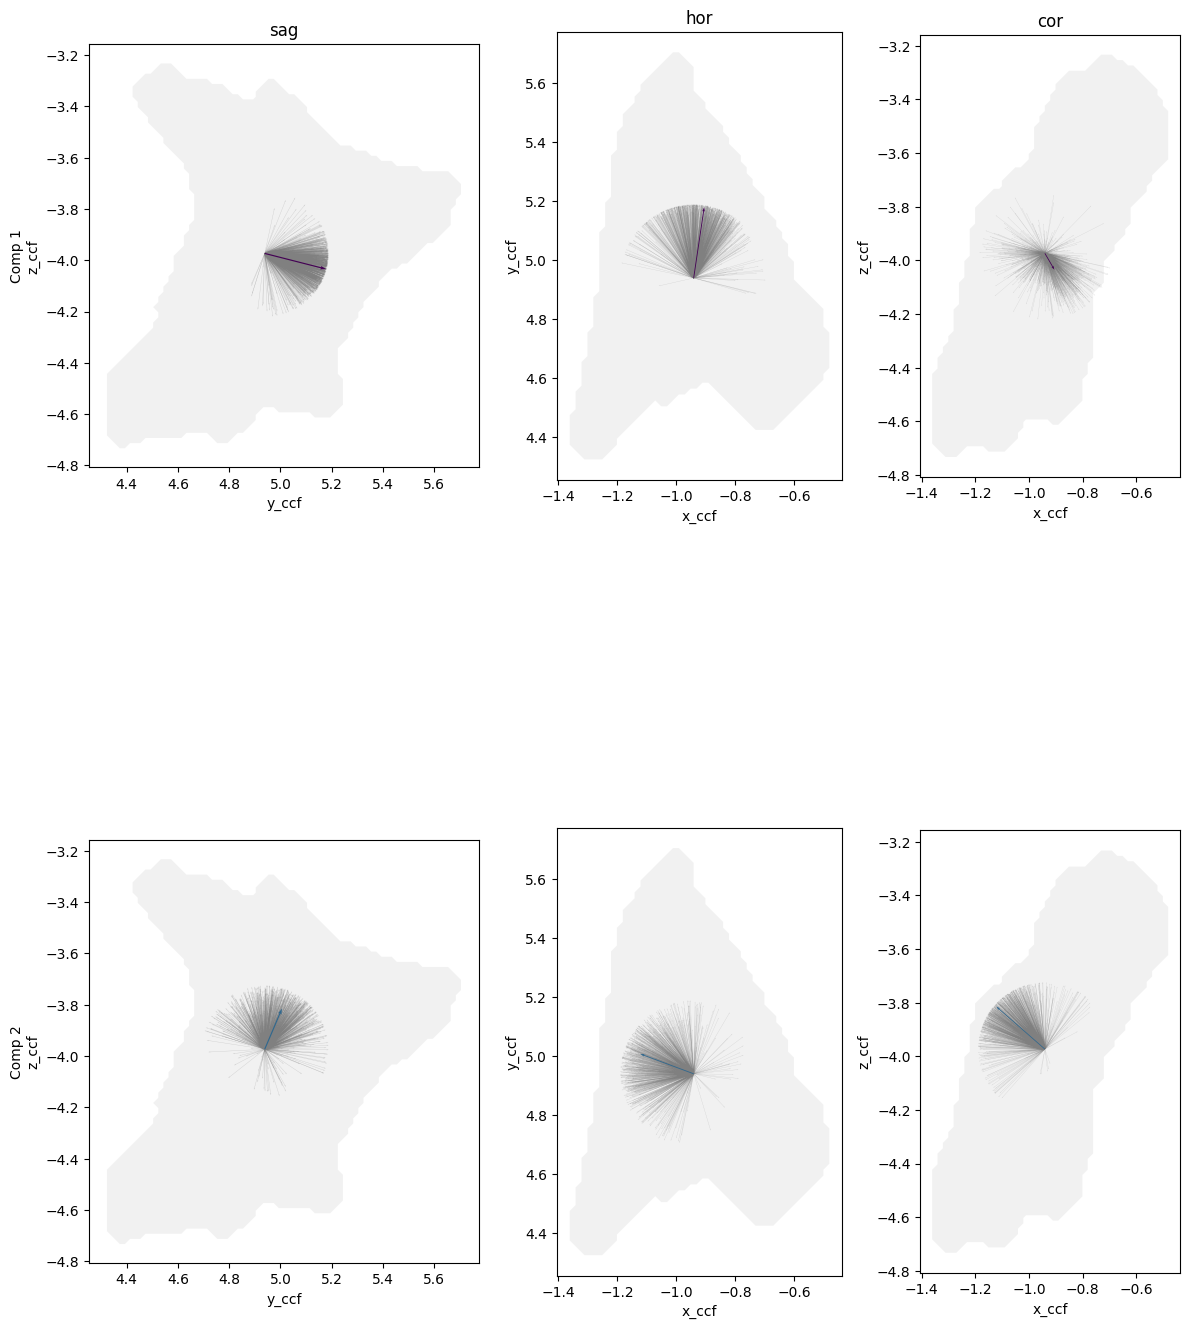

In [204]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# ----- Setup 3 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 18), width_ratios=[1.5, 1.1, 1])

# Extract and normalize CCA component vectors
# cca_vecs = cca_ccf_coeff.copy()
# cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

# Optional: mean of CCF as the origin
# origin = np.nanmean(ccf_mat, axis=0)

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']

for comp in range(2):   # row index → component number
    for plane_ind, plane in enumerate(planes.keys()):  # column index → plane
        ax = axes[comp, plane_ind]

        ix, iy = planes[plane]

        # anatomical mesh
        # ax.scatter(
        #     mesh_vertices_lps[:, ix],
        #     mesh_vertices_lps[:, iy],
        #     color='lightgray',
        #     alpha=0.1,
        #     s=0.2
        # )
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
        #     vec[planes[plane][0]], vec[planes[plane][1]],
        #     angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=cm.viridis(i/3))

        # ---------- BOOTSTRAP VECTOR CLOUD ----------
        for b in range(n_boot):
            vec = boot_yw_norm[b, :, comp]

            ax.quiver(
                origin[ix], origin[iy],
                vec[ix], vec[iy],
                angles='xy',
                scale_units='xy',
                scale=1/0.25,
                color=[0.5, 0.5, 0.5],
                alpha=0.3,      # transparent bootstrap vectors
                width=0.001,
                linewidth=0.01
            )

        # ---------- ORIGINAL CCA VECTOR (THICK) ----------
        vec0 = cca_vecs[:, comp]

        ax.quiver(
            origin[ix], origin[iy],
            vec0[ix], vec0[iy],
            angles='xy',
            scale_units='xy',
            scale=1/0.25,
            color=cm.viridis(comp / 3),
            width=0.003,
            linewidth=0.25,
            label=f'Comp {comp+1}'
        )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        # ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_CCF_components_bootstrap_3x3.pdf'),
    bbox_inches='tight'
)
plt.show()


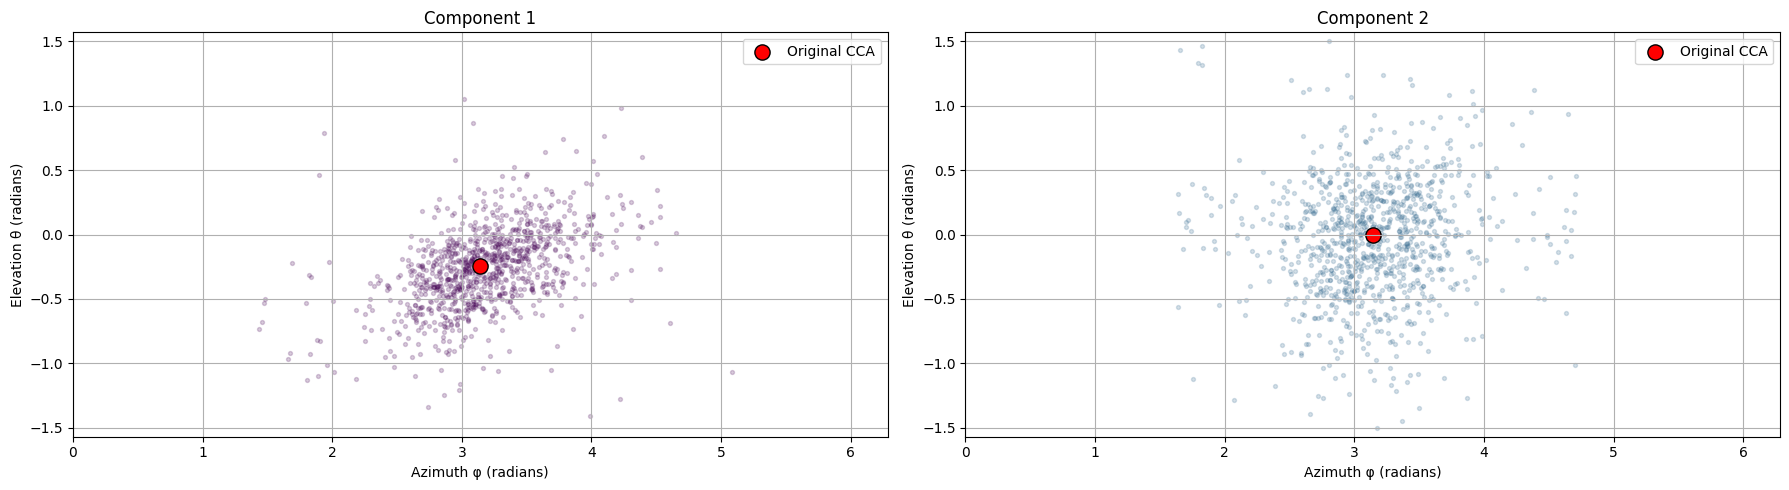

In [206]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ----- Convert vectors → spherical angles -----

# def vector_to_angles(v):
#     """Return (azimuth phi, elevation theta) for vector v."""
#     x, y, z = v
#     phi = np.arctan2(y, x)                     # horizontal angle
#     theta = np.arctan2(z, np.sqrt(x*x + y*y))  # vertical angle
#     return phi, theta


def vector_to_angles(v, off_set = 0.2):
    """Return (phi_new, theta) where φ=1 rad maps to φ_new=0."""
    x, y, z = v

    # raw azimuth φ in [0, 2π)
    phi = np.arctan2(y, x)
    if phi < 0:
        phi += 2 * np.pi

    # shift reference so φ=1 → φ_new=0
    phi_new = phi + off_set
    if phi_new < 0:
        phi_new += 2 * np.pi
    elif phi_new >= 2*np.pi:
        phi_new -= 2 * np.pi

    # elevation θ stays the same
    theta = np.arctan2(z, np.sqrt(x*x + y*y))

    return phi_new, theta

def express_in_basis(v, a):
    """
    Express vector v in a new coordinate system where:
      - z-axis is aligned with vector a
      - x- and y-axes are orthogonal to a (right-handed system)

    Returns:
        v_new : np.ndarray
            Coordinates of v in the new (x, y, z=a) basis
        R : np.ndarray
            3×3 rotation matrix (columns are the new basis vectors)
    """
    a = np.asarray(a, dtype=float)
    v = np.asarray(v, dtype=float)

    # Normalize z-axis (the reference direction)
    z_axis = a / np.linalg.norm(a)

    # Pick a stable arbitrary vector not parallel to z
    if abs(z_axis[0]) < 0.9:
        tmp = np.array([1, 0, 0])
    else:
        tmp = np.array([0, 1, 0])

    # Build x-axis orthogonal to z (Gram–Schmidt)
    x_axis = tmp - np.dot(tmp, z_axis) * z_axis
    x_axis /= np.linalg.norm(x_axis)

    # y-axis = z × x (right-handed system)
    y_axis = np.cross(z_axis, x_axis)
    y_axis /= np.linalg.norm(y_axis)

    # Rotation matrix: columns are new basis vectors
    R = np.column_stack([x_axis, y_axis, z_axis])

    # Express v in new basis
    v_new = R.T @ v

    return v_new, R

# Compute angles for bootstrap samples
phi_boot = np.zeros((n_boot, 2))
theta_boot = np.zeros((n_boot, 2))

# Compute angles for original CCA vectors
phi_orig = np.zeros(2)
theta_orig = np.zeros(2)
comp = 0
v0 = cca_vecs[:, comp]   # normalized
phi_orig[comp], theta_orig[comp] = vector_to_angles(v0, off_set=np.pi - np.arctan2(v0[1], v0[0]))
comp = 1
v1 = cca_vecs[:, comp]
v1_proj, R = express_in_basis(v1, cca_vecs[:, 0])
phi_orig[comp], theta_orig[comp] = vector_to_angles(v1_proj, off_set= -np.arctan2(v1_proj[1], v1_proj[0]) + np.pi)

# for component 0
comp = 0
for b in range(n_boot):
    v = boot_yw_norm[b, :, comp]
    phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v, off_set=np.pi - np.arctan2(v0[1], v0[0]))

# for component 1
comp = 1
for b in range(n_boot):
    v = boot_yw_norm[b, :, comp]
    # project v onto plane orthogonal to component 0
    v_proj, R = express_in_basis(v, cca_vecs[:, 0])
    # convert projected 2D vector to angles
    phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v_proj, off_set=-np.arctan2(v1_proj[1], v1_proj[0]) + np.pi)



# ----- PLOT -----
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

for comp in range(2):
    ax = axes[comp]
    
    ax.scatter(
        phi_boot[:, comp],
        theta_boot[:, comp],
        s=8, alpha=0.2,
        color=cm.viridis(comp/3)
    )
    
    # Plot original CCA direction
    ax.scatter(
        phi_orig[comp],
        theta_orig[comp],
        s=120, color='red', edgecolor='black', label='Original CCA'
    )

    ax.set_title(f'Component {comp+1}')
    ax.set_xlabel('Azimuth φ (radians)')
    ax.set_ylabel('Elevation θ (radians)')
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-np.pi/2, np.pi/2)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'CCA_direction_angle_scatter.pdf'),
            bbox_inches='tight')
plt.show()


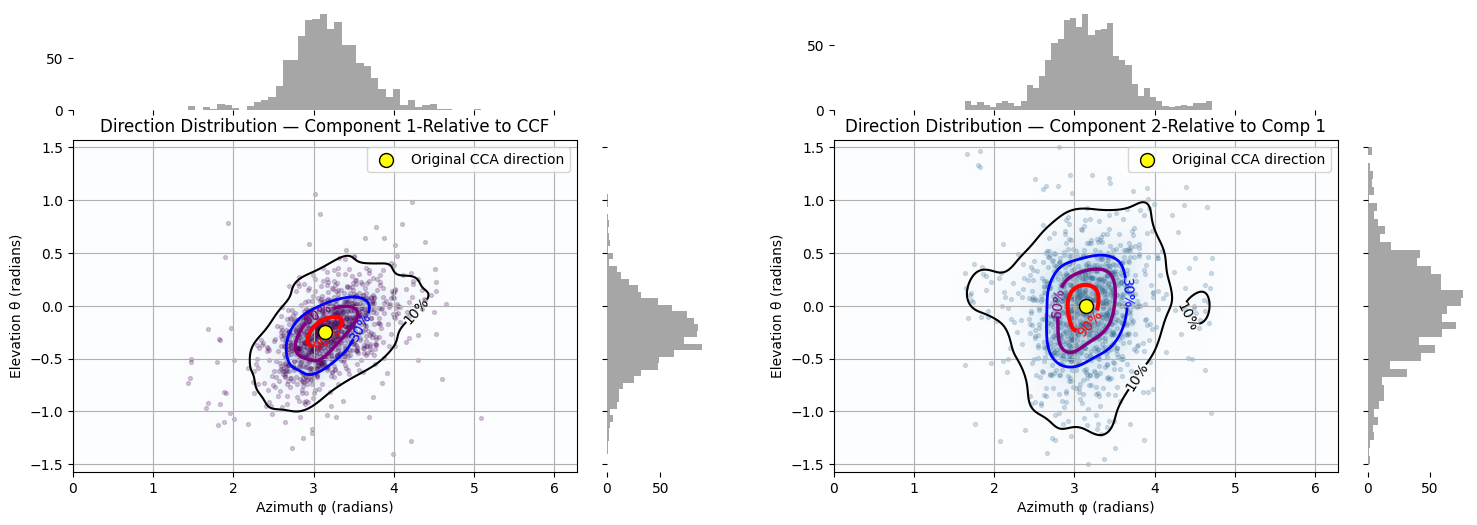

In [207]:
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

def kth_percentile_contour_levels(values, kde, xx, yy, levels=[0.1, 0.3, 0.5, 0.9]):
    """
    Convert percentile levels into actual KDE contour threshold values.

    Parameters
    ----------
    values : ndarray
        Flattened KDE values (e.g., kde(np.vstack([xx.ravel(), yy.ravel()]))).
    kde : gaussian_kde
        KDE object (not used in computation, kept for compatibility).
    xx, yy : ndarray
        Meshgrid arrays corresponding to evaluation grid (not used directly).
    levels : list of float
        Percentiles as fractions of total probability mass (e.g. [0.1, 0.3, 0.5, 0.9]).

    Returns
    -------
    contour_levels : list of float
        Density thresholds corresponding to requested cumulative probabilities.
    """
    # Sort KDE density values in descending order
    sorted_vals = np.sort(values)[::-1]

    # Compute normalized cumulative sum
    cumsum = np.cumsum(sorted_vals)
    cumsum /= cumsum[-1]  # normalize to 1

    contour_levels = []
    for p in levels:
        # smallest density threshold such that area above it = p
        # use interpolation for smoother results
        idx = np.searchsorted(cumsum, p)
        if idx >= len(sorted_vals):
            idx = len(sorted_vals) - 1
        contour_levels.append(sorted_vals[idx])

    return contour_levels

# -----------------------------------------------------------
# φ–θ DENSITY CONTOUR PLOT (10%, 30%, 50%, 90%) + marginals
# -----------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for comp in range(2):
    ax = axes[comp]

    # KDE over φ–θ samples
    data = np.vstack([phi_boot[:, comp], theta_boot[:, comp]])
    kde = gaussian_kde(data, bw_method=0.3)

    # grid for density evaluation
    phi_grid = np.linspace(0, 2*np.pi, 300)
    theta_grid = np.linspace(-np.pi/2, np.pi/2, 300)
    xx, yy = np.meshgrid(phi_grid, theta_grid)
    zz = kde(np.vstack([xx.flatten(), yy.flatten()]))
    zz_grid = zz.reshape(xx.shape)

    # scatter bootstraps
    ax.scatter(phi_boot[:, comp], theta_boot[:, comp],
               s=8, alpha=0.2, color=cm.viridis(comp/3))

    # percentile contour levels
    contour_levels = kth_percentile_contour_levels(
        zz, kde, xx, yy, levels=[0.10, 0.30, 0.50, 0.90]
    )
    contour_levels_sorted = np.sort(contour_levels)

    # density background
    ax.imshow(
        zz_grid, origin='lower',
        extent=[0, 2*np.pi, -np.pi/2, np.pi/2],
        aspect='auto', cmap='Blues', alpha=0.3
    )

    # main contours
    cs = ax.contour(
        xx, yy, zz_grid,
        levels=contour_levels_sorted,
        colors=["black", "blue", "purple", "red"],
        linewidths=[1.5, 2.0, 2.5, 3.0]
    )
    fmt = {val: label for val, label in zip(contour_levels_sorted, ["10%", "30%", "50%", "90%"])}
    ax.clabel(cs, inline=True, fontsize=10, fmt=fmt)

    # original CCA direction
    ax.scatter(phi_orig[comp], theta_orig[comp],
               s=100, color='yellow', edgecolor='black', zorder=5,
               label="Original CCA direction")

    # axis settings
    if comp == 0:
        ax.set_title(f'Direction Distribution — Component {comp+1}-Relative to CCF')
    else:
        ax.set_title(f'Direction Distribution — Component {comp+1}-Relative to Comp 1')
    ax.set_xlabel("Azimuth φ (radians)")
    ax.set_ylabel("Elevation θ (radians)")
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-np.pi/2, np.pi/2)
    ax.grid(True)
    ax.legend()

    # -------------------------------------------------------
    # MARGINAL HISTOGRAMS (top and right)
    # -------------------------------------------------------
    divider = make_axes_locatable(ax)
    ax_histx = divider.append_axes("top", size=1.0, pad=0.3, sharex=ax)
    ax_histy = divider.append_axes("right", size=1.0, pad=0.3, sharey=ax)

    # Hide tick labels on hist axes
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    plt.setp(ax_histy.get_yticklabels(), visible=False)

    # Plot histograms
    ax_histx.hist(phi_boot[:, comp], bins=40, color='gray', alpha=0.7)
    ax_histy.hist(theta_boot[:, comp], bins=40, orientation='horizontal', color='gray', alpha=0.7)

    # Match limits
    ax_histx.set_xlim(ax.get_xlim())
    ax_histy.set_ylim(ax.get_ylim())

    # Simplify look
    for spine in ax_histx.spines.values():
        spine.set_visible(False)
    for spine in ax_histy.spines.values():
        spine.set_visible(False)

# plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_direction_angle_density_contours_with_marginals.pdf'),
    bbox_inches='tight'
)
plt.show()

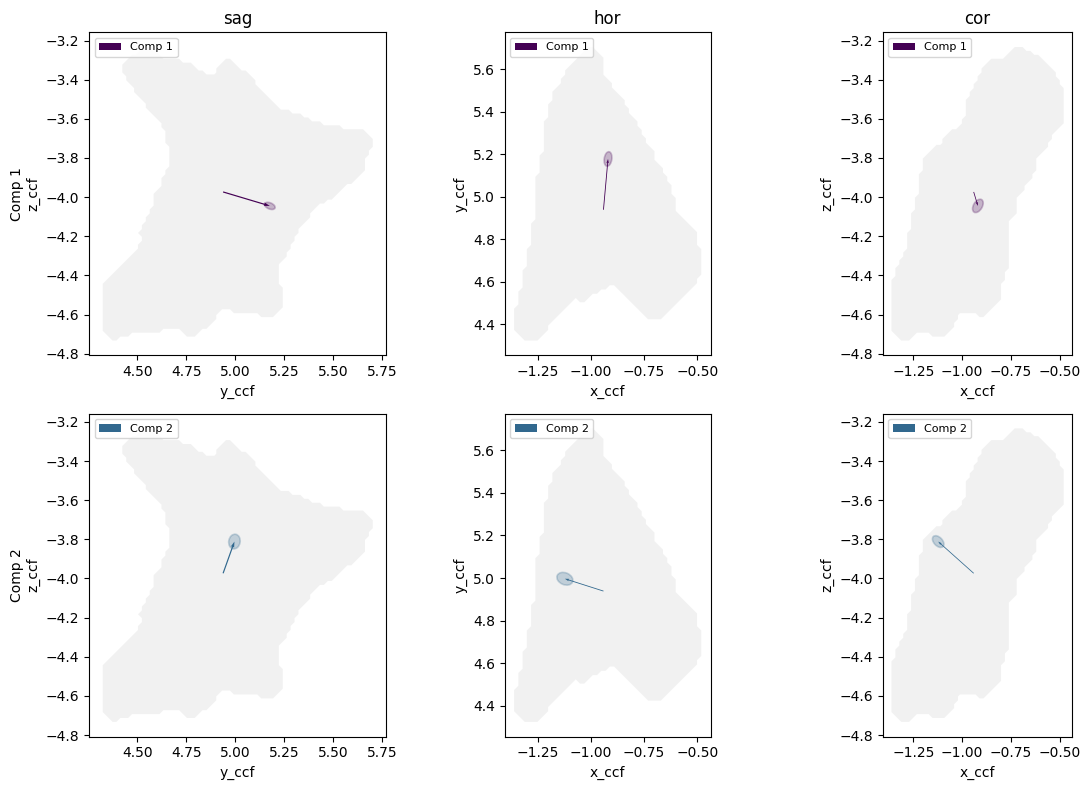

In [208]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Ellipse

# ----- Setup 2 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Normalize CCA vectors
cca_vecs = cca_ccf_coeff.copy()
cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']
n_se = 3  # 1 standard error ellipse
for comp in range(2):   # rows
    for plane_ind, plane in enumerate(planes.keys()):  # columns
        ax = axes[comp, plane_ind]
        ix, iy = planes[plane]

        # Draw anatomical background
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ----------------------------
        # BOOTSTRAP VECTOR VARIABILITY
        # ----------------------------
        # Collect bootstrap vectors for this component
        boot_vecs = boot_yw_norm[:, :, comp]
        # Mean vector
        mean_vec = np.nanmean(boot_vecs, axis=0)
        mean_vec /= np.linalg.norm(mean_vec)

        # Project all bootstrap vectors to the plane (ix, iy)
        vecs_2d = boot_vecs[:, [ix, iy]]
        mean_2d = mean_vec[[ix, iy]]

        # Compute 2D covariance for cone/ellipse (bootstrapped spread)
        cov = np.cov(vecs_2d.T)

        # Convert covariance to *standard error* ellipse
        eigvals, eigvecs = np.linalg.eigh(cov / n_boot)  # divide by n_boot for SE

        # Scale by desired number of SEs (e.g., 1 → 1 SE, 2 → 95% CI)
        width, height = 2 * n_se * np.sqrt(eigvals)
        angle = np.degrees(np.arctan2(*eigvecs[:, 1][::-1]))

        scale = 1/0.25  # scaling factor for arrow length
        end_x = origin[ix] + mean_2d[0] / scale
        end_y = origin[iy] + mean_2d[1] / scale

        # Ellipse centered at arrow tip
        ellipse = Ellipse(
            xy=(end_x, end_y),
            width=width, height=height, angle=angle,
            edgecolor=cm.viridis(comp / 3),
            facecolor=cm.viridis(comp / 3),
            alpha=0.25, lw=1.2
        )
        ax.add_patch(ellipse)

        # ----------------------------
        # MEAN VECTOR (CENTRAL AXIS)
        # ----------------------------
        ax.quiver(
            origin[ix], origin[iy],
            mean_2d[0], mean_2d[1],
            angles='xy', scale_units='xy', scale=scale,
            color=cm.viridis(comp / 3),
            width=0.004, linewidth=1.0,
            label=f'Comp {comp+1}'
        )

        # ----------------------------
        # OPTIONAL: TRUE CCA VECTOR
        # ----------------------------
        # true_vec = cca_vecs[:, comp]
        # ax.quiver(
        #     origin[ix], origin[iy],
        #     true_vec[ix], true_vec[iy],
        #     angles='xy', scale_units='xy', scale=1/0.25,
        #     color='black', width=0.002, linewidth=0.5,
        #     alpha=0.8, label='Original CCA'
        # )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_CCF_components_bootstrap_SE_cones.pdf'),
    bbox_inches='tight'
)
plt.show()


In [209]:
# re-plot CCA CCF components in 3D with standard errors as cones
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

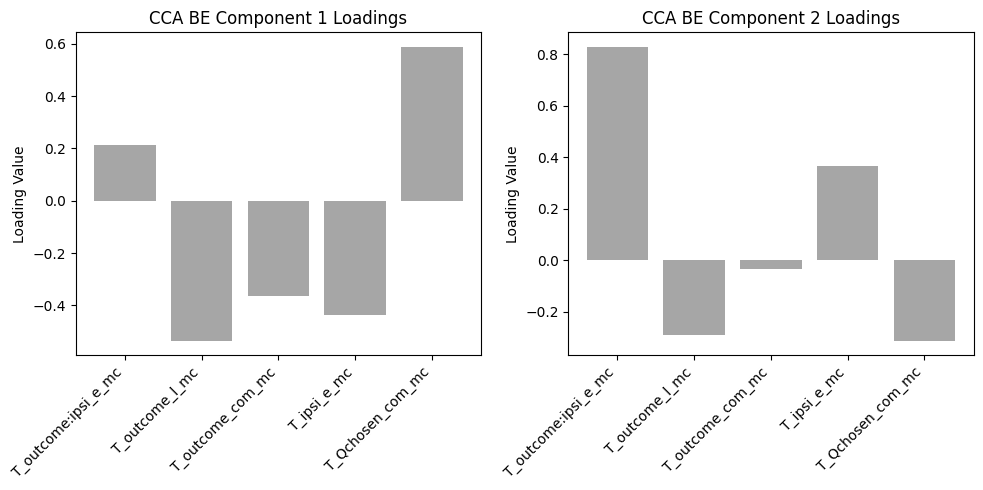

In [210]:
# plot contribution of each feature to cca components as bar plots
cca_be_coeff = cca.x_weights_
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    ax = axes[i]
    ax.bar(focus_features_cca, cca_be_coeff[:, i], color='gray', alpha=0.7)
    ax.set_title(f'CCA BE Component {i+1} Loadings')
    ax.set_ylabel('Loading Value')
    ax.set_xticklabels(focus_features_cca, rotation=45, ha='right')
fig.tight_layout()
fig.savefig(os.path.join(target_folder, 'CCA_beh_components_loadings.pdf'), bbox_inches='tight')
    

In [211]:
custom_cmap_1 = LinearSegmentedColormap.from_list(
    "black_red",
    [(0, 0, 0), (1, 0, 0)]
)
custom_cmap_0 = LinearSegmentedColormap.from_list(
    "cool_warm",
    [(0, 1, 1), (1, 0, 1)]
)
custom_cmap_2 = LinearSegmentedColormap.from_list(
    "blue_yellow",
    [(0, 0, 1), (1, 1, 0)]
)

custom_cmaps = [custom_cmap_0, custom_cmap_1, custom_cmap_2]

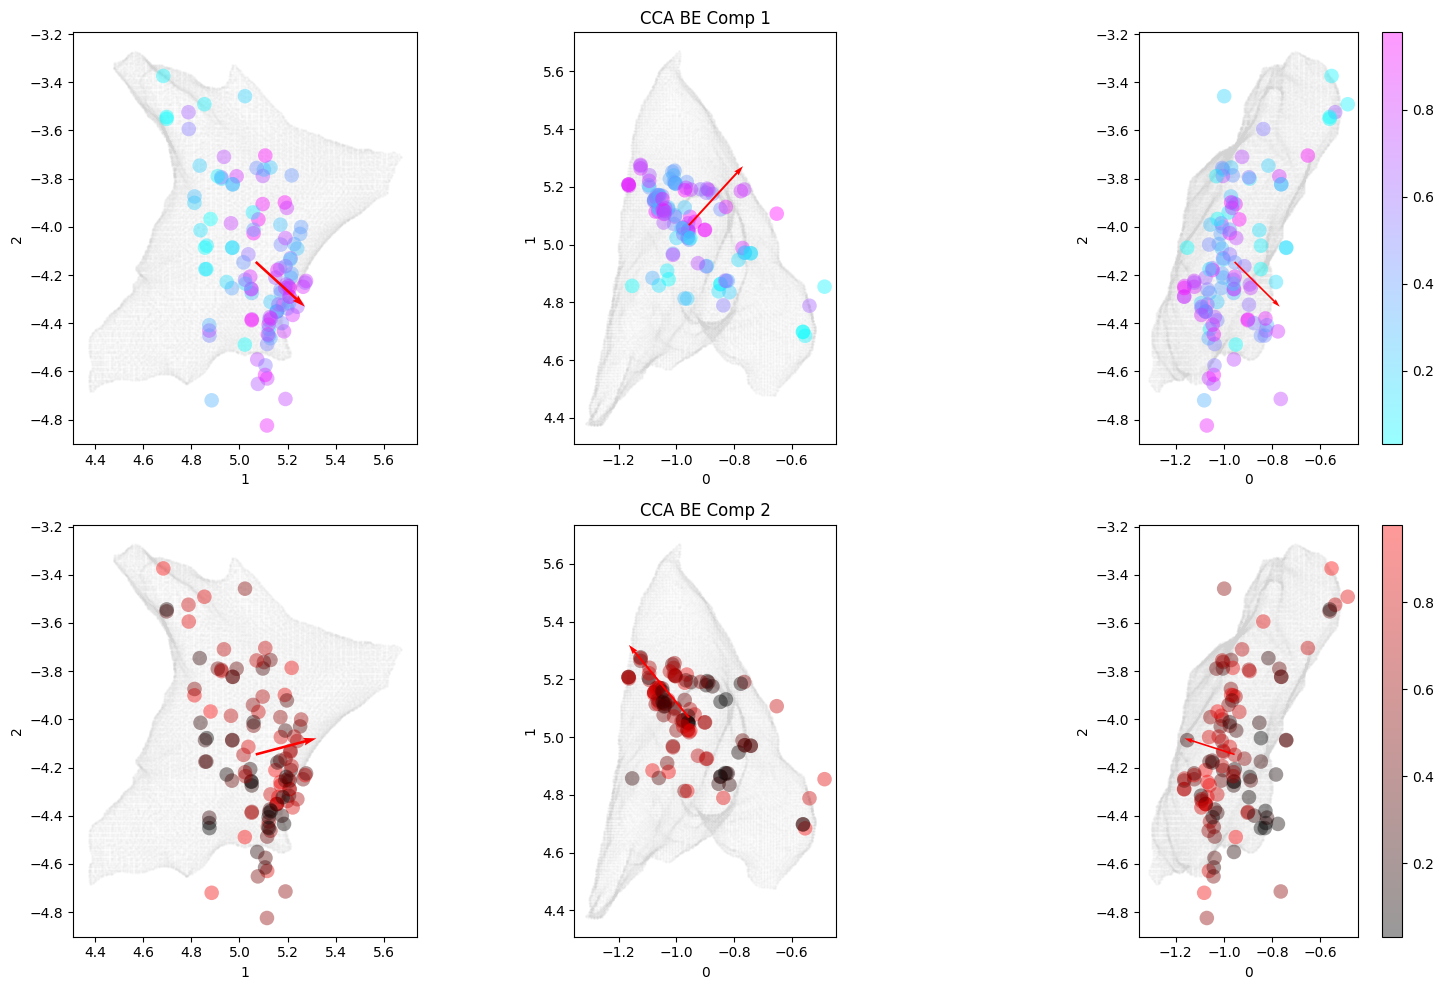

In [212]:
# plot cca be features in ccf space as color code
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter][~nan_ind_cca]
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # Mirror ML to left
for dim_ind in range(2):
    cca_values = cca_result_be[:, dim_ind]
    # clip to 2.5-97.5 percentile
    top_90 = np.nanquantile(cca_values, 0.95)
    bottom_10 = np.nanquantile(cca_values, 0.05)
    cca_values_nl = np.clip(cca_values, bottom_10, top_90)
    cca_values_nl = (cca_values_nl - bottom_10) / (top_90 - bottom_10)
    cca_values_nl[np.isnan(cca_values_nl)] = 0.0
    # change to rank
    cca_values_nl = rankdata(cca_values_nl) / len(cca_values_nl)

    for j, plane in enumerate(planes.keys()):
        ax = axes[dim_ind, j]
        ax.scatter(mesh_vertices_lps[:, planes[plane][0]], mesh_vertices_lps[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.2)
        sc = ax.scatter(ccfs[:, planes[plane][0]], ccfs[:, planes[plane][1]], c=cca_values_nl, cmap=custom_cmaps[dim_ind], s=110, edgecolor='none', alpha=0.4)
        if plane == 'hor':
            ax.set_title(f'CCA BE Comp {dim_ind+1}')
        vec = cca_ccf_coeff[:, dim_ind]
        origin = np.nanmean(ccfs, axis=0)
        # origin = np.zeros(3)
        ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
                  vec[planes[plane][0]], vec[planes[plane][1]],
                  angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {dim_ind+1}', color='r')
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')
        if plane == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'CCA_beh_in_space_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

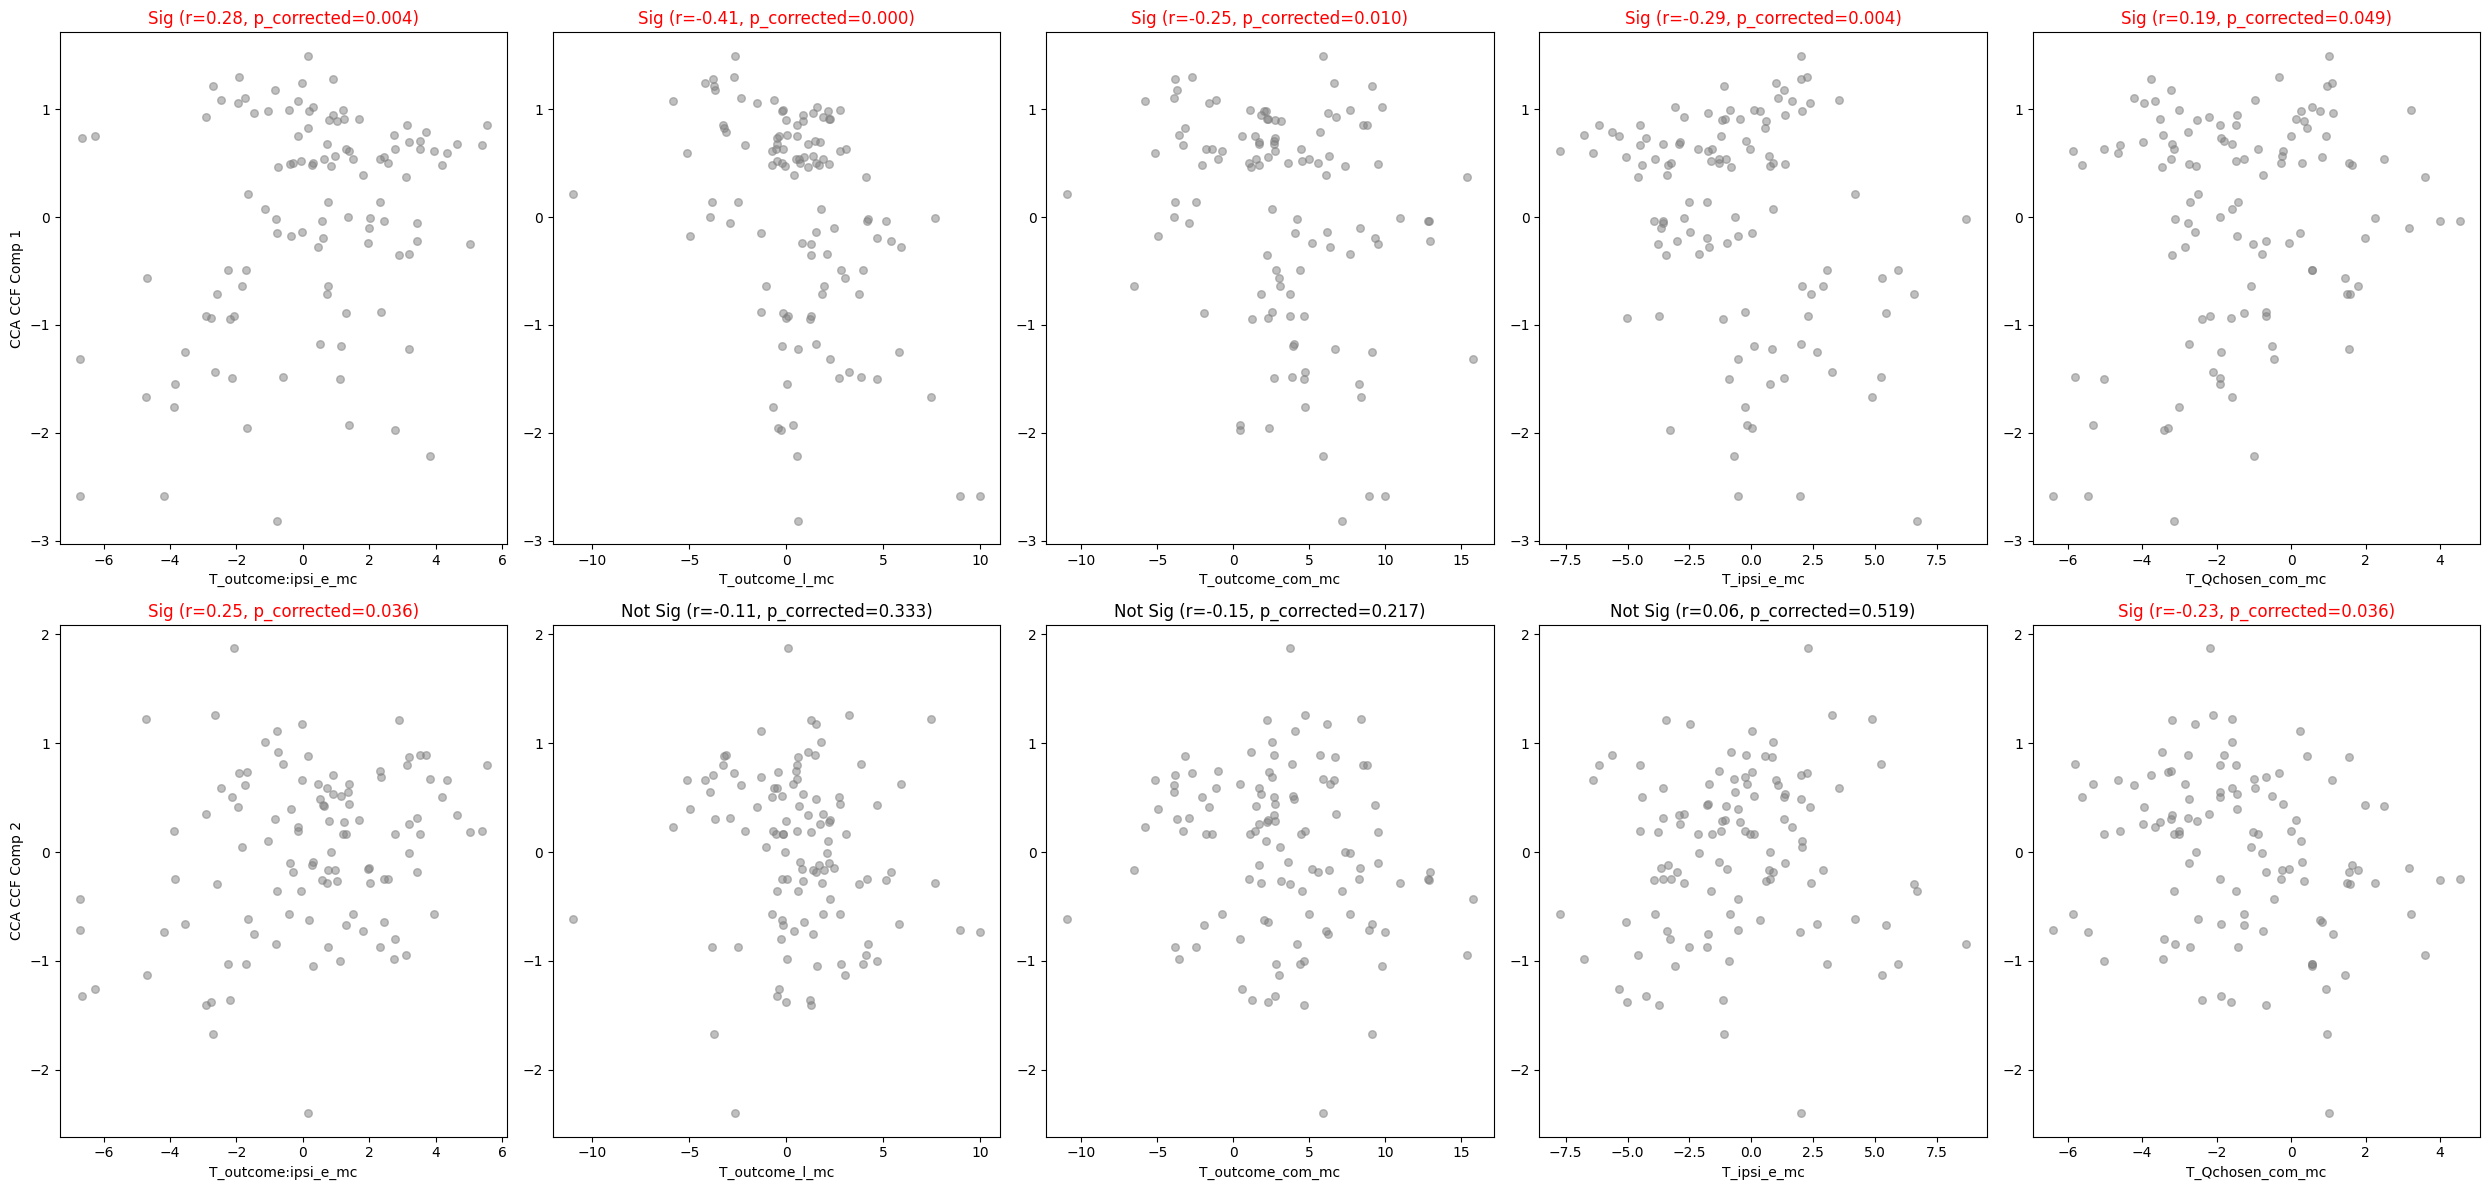

In [213]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# --- create figure with 3 rows (CCA components) and one column per feature ---
fig, axes = plt.subplots(2, len(focus_features_cca), figsize=(5*len(focus_features_cca), 12))

for j in range(2):  # iterate over CCA components
    cca_ccf_values = cca_result_ccf[:, j]
    all_p = []
    all_coef = []
    for i, feature in enumerate(focus_features_cca):
        ax = axes[j, i]
        feature_values = features_combined[feature].values[filter][~nan_ind_cca]

        # scatter plot
        ax.scatter(feature_values, cca_ccf_values, c='gray', alpha=0.5, s=30)
        ax.set_xlabel(feature)
        if i == 0:
            ax.set_ylabel(f'CCA CCF Comp {j+1}')

        # compute correlation
        corr_coef, p_value = pearsonr(feature_values, cca_ccf_values)
        all_p.append(p_value)
        all_coef.append(corr_coef)

    # adjust for multiple comparisons 
    reject, pvals_corrected, _, _ = multipletests(all_p, method='fdr_bh', alpha=0.05)
    for i, ax in enumerate(axes[j, :]):
        if reject[i]:
            ax.set_title(f'Sig (r={all_coef[i]:.2f}, p_corrected={pvals_corrected[i]:.3f})', color='red')
        else:
            ax.set_title(f'Not Sig (r={all_coef[i]:.2f}, p_corrected={pvals_corrected[i]:.3f})', color='black')



plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_beh_CCF_scatter_by_component.pdf'),
    bbox_inches='tight', dpi=300
)
plt.show()

In [231]:
all_p

[np.float64(0.007591255233760323),
 np.float64(0.26600035738176425),
 np.float64(0.13046121536373076),
 np.float64(0.5185925591242087),
 np.float64(0.014593347642691046)]

Text(0, 0.5, 'T_outcome_l_mc')

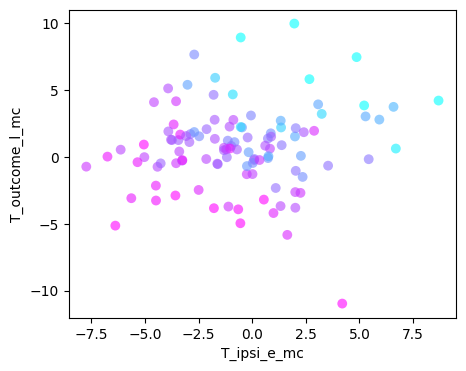

In [232]:
x_val = 'T_ipsi_e_mc'
y_yal = 'T_outcome_l_mc'
color_code = cca_result_be
cca_values = cca_result_be[:, 0]
# clip to 2.5-97.5 percentile
top_90 = np.nanquantile(cca_values, 0.95)
bottom_10 = np.nanquantile(cca_values, 0.05)
cca_values_nl = np.clip(cca_values, bottom_10, top_90)
cca_values_nl = (cca_values_nl - bottom_10) / (top_90 - bottom_10)
cca_values_nl[np.isnan(cca_values_nl)] = 0.0
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(
    features_combined[x_val].values[filter][~nan_ind_cca],
    features_combined[y_yal].values[filter][~nan_ind_cca],
    c=cca_values_nl, cmap = custom_cmaps[0], s=50, edgecolor='none', alpha=0.6
)

ax.set_xlabel(x_val)
ax.set_ylabel(y_yal)



Text(0, 0.5, 'T_outcome:ipsi_com_mc')

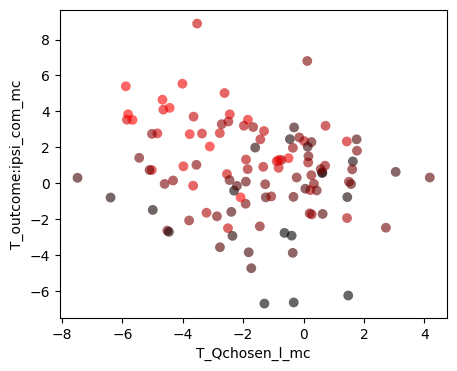

In [217]:
x_val = 'T_Qchosen_l_mc'
y_yal = 'T_outcome:ipsi_com_mc'
color_code = cca_result_be
cca_values = cca_result_be[:, 1]
# clip to 2.5-97.5 percentile
top_90 = np.nanquantile(cca_values, 0.95)
bottom_10 = np.nanquantile(cca_values, 0.05)
cca_values_nl = np.clip(cca_values, bottom_10, top_90)
cca_values_nl = (cca_values_nl - bottom_10) / (top_90 - bottom_10)
cca_values_nl[np.isnan(cca_values_nl)] = 0.0
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(
    features_combined[x_val].values[filter][~nan_ind_cca],
    features_combined[y_yal].values[filter][~nan_ind_cca],
    c=cca_values_nl, cmap = custom_cmaps[1], s=50, edgecolor='none', alpha=0.6
)

ax.set_xlabel(x_val)
ax.set_ylabel(y_yal)



##  Shuffling

In [504]:
focus_features = ['T_outcome:ipsi_e_mc',
                'T_outcome_l_mc',
                # 'T_outcome_com_mc',
                'T_ipsi_e_mc',
                # 'T_ipsi_com_mc',
                'T_baseline_hit',
                'T_response_hit',
                # 'T_baseline_svs',
                'T_response_svs']

In [218]:
# create a functions that takes in cca_be_mat and ccf_mat and performs the entire cca with bootstrap and returns the cca results with ci
# outputs: cca_result_be, cca_result_ccf, xw_low, xw_high, yw_low, yw_high, boot_xw, boot_yw, cca_x_weights, cca_y_weights
from sklearn.cross_decomposition import CCA
import numpy as np
from collections import defaultdict
def perform_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=5000, n_boot=1000, alpha=0.05, return_all=False):
    # Fit original CCA
    cca = CCA(n_components=2)
    cca.fit(cca_be_mat, ccf_mat)
    xw = cca.x_weights_
    yw = cca.y_weights_

    cca_result_be, cca_result_ccf = cca.fit_transform(cca_be_mat, ccf_mat)

    cca_vecs = yw / np.linalg.norm(yw, axis=0, keepdims=True)

    # Bin data into 3D voxels
    coords = ccf_mat
    n_bins_xyz = (3, 3, 4)
    bins = [
        np.linspace(coords[:, i].min()-0.1, coords[:, i].max()+0.1, n_bins_xyz[i] + 1)
        for i in range(3)
    ]
    xbin = np.digitize(coords[:, 0], bins[0]) - 1
    ybin = np.digitize(coords[:, 1], bins[1]) - 1
    zbin = np.digitize(coords[:, 2], bins[2]) - 1

    voxel_map = defaultdict(list)
    for i in range(len(coords)):
        v = (xbin[i], ybin[i], zbin[i])
        voxel_map[v].append(i)

    valid_voxels = [v for v in voxel_map if len(voxel_map[v]) > 0]
    counts = np.array([len(voxel_map[v]) for v in valid_voxels])
    total_count = counts.sum()
    samples_per_voxel = np.maximum(1, np.floor((counts / total_count) * n_samples).astype(int))

    # Bootstrap loop
    rng = np.random.default_rng(4)
    boot_xw = np.zeros((n_boot, cca_be_mat.shape[1], 2))
    boot_yw = np.zeros((n_boot, 3, 2))

    for b in range(n_boot):
        indices = []
        for vox_idx, voxel in enumerate(valid_voxels):
            n_draw = voxel_map[voxel].__len__()
            picked = rng.choice(
                voxel_map[voxel],
                size=n_draw,
                replace=True
            )
            indices.extend(picked)
        indices = np.array(indices)
        Xb = cca_be_mat[indices]
        Yb = ccf_mat[indices]
        cca_b = CCA(n_components=2)
        cca_b.fit(Xb, Yb)
        boot_xw[b] = cca_b.x_weights_
        boot_yw[b] = cca_b.y_weights_
        # for comp in range(2):
        #     xw = cca_b.x_weights_[:, comp]
        #     yw = cca_b.y_weights_[:, comp]
        #     xw /= np.linalg.norm(xw)
        #     yw /= np.linalg.norm(yw)
        #     boot_xw[b, :, comp] = xw
        #     boot_yw[b, :, comp] = yw
        # xw = cca_b.x_weights_[:, 0]
        # yw = cca_b.y_weights_[:, 0]
        # xw /= np.linalg.norm(xw)
        # yw /= np.linalg.norm(yw)
        # boot_xw[b, :, 0] = xw
        # boot_yw[b, :, 0] = yw
        # # # second component (optional)
        # xw = cca_b.x_weights_[:, 1]
        # yw = cca_b.y_weights_[:, 1]
        # xw /= np.linalg.norm(xw)
        # yw /= np.linalg.norm(yw)
        # boot_xw[b, :, 1] = xw
        # boot_yw[b, :, 1] = yw
        # Xb_res = Xb - (Xb @ xw[:, 0][:, None]) * xw[:, 0][None, :]
        # Yb_res = Yb - (Yb @ yw[:, 0][:, None]) * yw[:, 0][None, :]
        # cca_b2 = CCA(n_components=1)
        # cca_b2.fit(Xb_res, Yb_res)
        # xw_2 = cca_b2.x_weights_[:, 0]
        # yw_2 = cca_b2.y_weights_[:, 0]
        # boot_xw[b, :, 1] = xw_2
        # boot_yw[b, :, 1] = yw_2
    # Sign alignment
    boot_yw_aligned = boot_yw.copy()
    boot_xw_aligned = boot_xw.copy()

    boot_yw_norm = (
        boot_yw_aligned /
        np.linalg.norm(boot_yw_aligned, axis=1, keepdims=True)
    )

    for comp in range(2):
        ref = cca_vecs[:, comp]
        for b in range(n_boot):
            if np.dot(boot_yw_norm[b, :, comp], ref) < 0:
                boot_yw_aligned[b, :, comp] *= -1
                boot_xw_aligned[b, :, comp] *= -1




    boot_yw = boot_yw_aligned
    boot_xw = boot_xw_aligned

    boot_yw = (
        boot_yw /
        np.linalg.norm(boot_yw, axis=1, keepdims=True)
    )

    # compute CI bounds
    xw_low  = np.percentile(boot_xw, 100 * alpha/2, axis=0)
    xw_high = np.percentile(boot_xw, 100 * (1 - alpha/2), axis=0)
    yw_low  = np.percentile(boot_yw, 100 * alpha/2, axis=0)
    yw_high = np.percentile(boot_yw, 100 * (1 - alpha/2), axis=0)

    # save correlation of cca results
    corrs = np.corrcoef(cca_result_be.T, cca_result_ccf.T)
    corrs = np.diag(corrs[:2, 2:])

    # Compute angles 
    phi_boot = np.zeros((n_boot, 2))
    theta_boot = np.zeros((n_boot, 2))
    # mean vector
    v_mean = np.nanmean(boot_yw, axis=0)
    ang_mean_0 = np.arctan2(v_mean[1, 0], v_mean[0, 0])
    # ang_mean_1 = np.arctan2(v_mean[1, 1], v_mean[0, 1])
    # for comp 0
    comp = 0
    for b in range(n_boot):
        v = boot_yw[b, :, comp]
        phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v, off_set=np.pi-ang_mean_0)
    # for comp 1
    comp = 1
    v_proj = np.zeros((n_boot, 3))
    for b in range(n_boot):
        # project v onto plane orthogonal to component 0
        v_proj[b, :], R = express_in_basis(boot_yw[b, :, comp], cca_vecs[:, 0])
        # convert projected 2D vector to angles
    # mean vector
    v_mean_1 = np.nanmean(v_proj, axis=0)
    ang_mean_1 = np.arctan2(v_mean_1[1], v_mean_1[0])
    for b in range(n_boot):
        phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v_proj[b, :], off_set=np.pi - ang_mean_1)

    # compute angles for original CCA vectors
    phi_orig = np.zeros(2)
    theta_orig = np.zeros(2)
    # for comp 0
    comp = 0
    v0 = cca_vecs[:, comp]   # normalized
    phi_orig[comp], theta_orig[comp] = vector_to_angles(v0, off_set=-0.5)
    # for comp 1
    comp = 1
    v1 = cca_vecs[:, comp]
    v1_proj, R = express_in_basis(v1, cca_vecs[:, 0])
    phi_orig[comp], theta_orig[comp] = vector_to_angles(v1_proj, off_set=1)


    # variance for directions:
    cov_matrix_comp0 = np.cov((boot_yw[:, :, 0]).T)
    cov_matrix_comp1 = np.cov((boot_yw[:, :, 1]).T)
    # eigen decomposition
    eigvals_vec_0, eigvecs_vec_0 = np.linalg.eig(cov_matrix_comp0)
    max_idx0 = np.argmax(eigvals_vec_0)
    principal_dir0_vec = eigvecs_vec_0[:, max_idx0]
    principal_var0_vec = eigvals_vec_0[max_idx0]

    eigvals_vec_1, eigvecs_vec_1 = np.linalg.eig(cov_matrix_comp1)
    max_idx1 = np.argmax(eigvals_vec_1)
    principal_dir1_vec = eigvecs_vec_1[:, max_idx1]
    principal_var1_vec = eigvals_vec_1[max_idx1]

    # variance for angles:
    # calcuate covariance of phi and theta
    cov_matrix_comp0 = np.cov(theta_boot[:, 0], phi_boot[:, 0])
    cov_matrix_comp1 = np.cov(theta_boot[:, 1], phi_boot[:, 1])
    # eigen decomposition
    # For component 0
    eigvals_ang_0, eigvecs_ang_0 = np.linalg.eig(cov_matrix_comp0)
    max_idx0 = np.argmax(eigvals_ang_0)
    principal_dir0_ang = eigvecs_ang_0[:, max_idx0]
    principal_var0_ang = eigvals_ang_0[max_idx0]

    # For component 1
    eigvals_ang_1, eigvecs_ang_1 = np.linalg.eig(cov_matrix_comp1)
    max_idx1 = np.argmax(eigvals_ang_1)
    principal_dir1_ang = eigvecs_ang_1[:, max_idx1]
    principal_var1_ang = eigvals_ang_1[max_idx1]
    result = {'corrs': corrs,
                # 'cca_result_be': cca_result_be,
                # 'cca_result_ccf': cca_result_ccf,
                # 'xw_low': xw_low,
                # 'xw_high': xw_high,
                # 'yw_low': yw_low,
                # 'yw_high': yw_high,
                # 'boot_xw': boot_xw,
                # 'boot_yw': boot_yw,
                'cca_x_weights': cca.x_weights_,
                'cca_y_weights': cca.y_weights_,
                'cca_vecs': cca_vecs,
                # 'phi_boot': phi_boot,
                # 'theta_boot': theta_boot,
                'phi_orig': phi_orig,
                'theta_orig': theta_orig,
                # 'var_phi': var_phi,
                # 'var_theta': var_theta,
                'eigvals_vec_0': np.sort(eigvals_vec_0)[::-1],
                # 'eigvecs_vec_0': eigvecs_vec_0,
                'eigvals_vec_1': np.sort(eigvals_vec_1)[::-1], 
                # 'eigvecs_vec_1': eigvecs_vec_1,
                'eigvals_ang_0': np.sort(eigvals_ang_0)[::-1],
                # 'eigvecs_ang_0': eigvecs_ang_0,
                'eigvals_ang_1': np.sort(eigvals_ang_1)[::-1],
                # 'eigvecs_ang_1': eigvecs_ang_1,
                }
    if not return_all:
        return result
    else:
        result.update({
            'boot_xw': boot_xw,
            'boot_yw': boot_yw,
            'phi_boot': phi_boot,
            'theta_boot': theta_boot,
        })
        return result
        
        
def shuffle_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=5000, n_boot=1000, alpha=0.05):
    # shuffle the cca_be_mat
    shuffled_cca_be_mat = cca_be_mat.copy()
    np.random.shuffle(shuffled_cca_be_mat)
    # perform cca with bootstrap
    results = perform_cca_with_bootstrap(shuffled_cca_be_mat, ccf_mat, n_samples, n_boot, alpha, return_all=False)
    return results

In [219]:
focus_features_cca = focus_features
# focus_features_cca = focus_features+['beh_umap_1', 'beh_umap_2']
filter = features_combined['be_filter'].values
cca_be_mat = features_combined[focus_features_cca].values[filter]

bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = -np.abs(ccf_mat[:, ml])  # Mirror ML to left

# remove nan
nan_ind_cca = np.isnan(cca_be_mat).any(axis=1) | np.isnan(ccf_mat).any(axis=1)
cca_be_mat = cca_be_mat[~nan_ind_cca]
ccf_mat = ccf_mat[~nan_ind_cca]

# Convert to ranked values column-wise
ccf_mat_ranked = np.zeros_like(ccf_mat)
for i in range(ccf_mat.shape[1]):
    ccf_mat_ranked[:, i] = rankdata(ccf_mat[:, i], method='average')
# ccf_mat = ccf_mat_ranked
# zscore
cca_be_mat = zscore(cca_be_mat, axis=0, nan_policy='omit')
# ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter][~nan_ind_cca]
result_ori = perform_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=ccf_mat.shape[0], n_boot=1500, alpha=0.05, return_all=True)
# result = shuffle_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=1000, n_boot=1000, alpha=0.05)

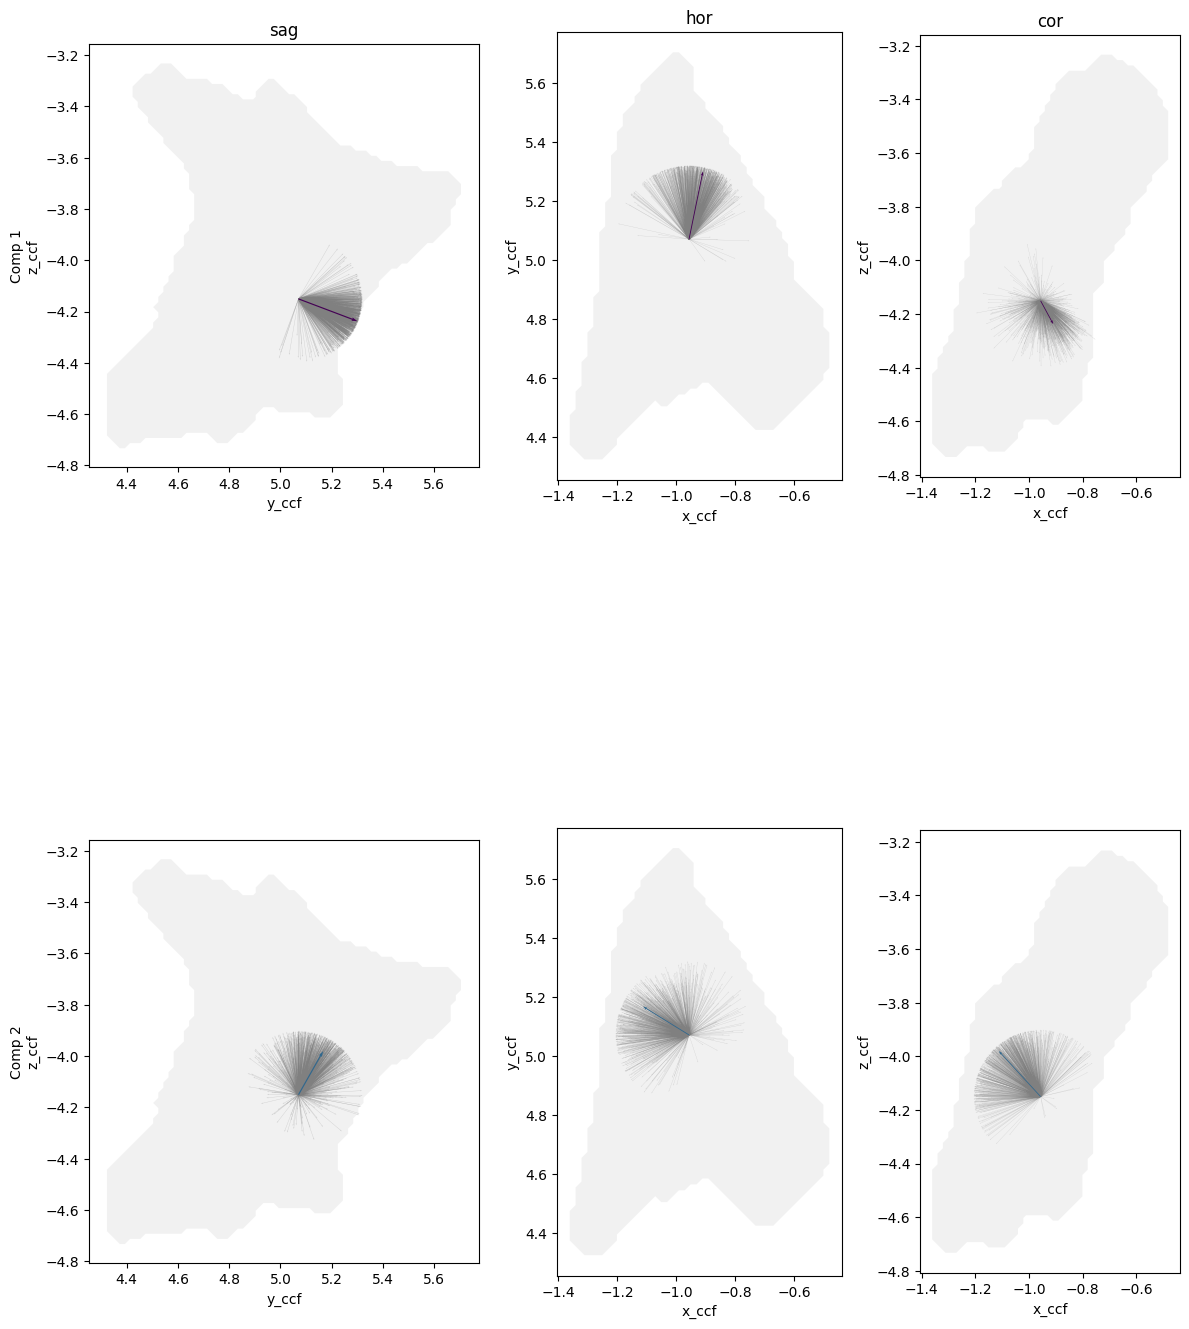

In [191]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# ----- Setup 3 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 18), width_ratios=[1.5, 1.1, 1])

# Extract and normalize CCA component vectors
cca_vecs = result_ori['cca_y_weights'].copy()
cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

# Optional: mean of CCF as the origin
# origin = np.nanmean(ccf_mat, axis=0)

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']

for comp in range(2):   # row index → component number
    for plane_ind, plane in enumerate(planes.keys()):  # column index → plane
        ax = axes[comp, plane_ind]

        ix, iy = planes[plane]

        # anatomical mesh
        # ax.scatter(
        #     mesh_vertices_lps[:, ix],
        #     mesh_vertices_lps[:, iy],
        #     color='lightgray',
        #     alpha=0.1,
        #     s=0.2
        # )
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
        #     vec[planes[plane][0]], vec[planes[plane][1]],
        #     angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=cm.viridis(i/3))

        # ---------- BOOTSTRAP VECTOR CLOUD ----------
        for b in range(n_boot):
            vec = result_ori['boot_yw'][b, :, comp]

            ax.quiver(
                origin[ix], origin[iy],
                vec[ix], vec[iy],
                angles='xy',
                scale_units='xy',
                scale=1/0.25,
                color=[0.5, 0.5, 0.5],
                alpha=0.3,      # transparent bootstrap vectors
                width=0.001,
                linewidth=0.01
            )

        # ---------- ORIGINAL CCA VECTOR (THICK) ----------
        vec0 = cca_vecs[:, comp]

        ax.quiver(
            origin[ix], origin[iy],
            vec0[ix], vec0[iy],
            angles='xy',
            scale_units='xy',
            scale=1/0.25,
            color=cm.viridis(comp / 3),
            width=0.003,
            linewidth=0.25,
            label=f'Comp {comp+1}'
        )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        # ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_CCF_components_bootstrap_3x3.pdf'),
    bbox_inches='tight'
)
plt.show()


In [181]:
result_ori

{'corrs': array([0.60470575, 0.42350031]),
 'cca_x_weights': array([[ 0.12258918,  0.71952589],
        [-0.31095116, -0.53461547],
        [-0.22241989, -0.19027877],
        [-0.32379858,  0.09523341],
        [ 0.19390953, -0.15058187],
        [-0.46786528,  0.31805379],
        [ 0.55189661, -0.16522334],
        [ 0.41578414,  0.00784315]]),
 'cca_y_weights': array([[ 0.18791537, -0.62417352],
        [ 0.91866683,  0.38484996],
        [-0.34747527,  0.67992494]]),
 'cca_vecs': array([[ 0.18791537, -0.62417352],
        [ 0.91866683,  0.38484996],
        [-0.34747527,  0.67992494]]),
 'phi_orig': array([0.86902745, 5.02373989]),
 'theta_orig': array([-3.54877249e-01, -2.11479336e-16]),
 'eigvals_vec_0': array([0.11902628, 0.0621937 , 0.01566114]),
 'eigvals_vec_1': array([0.22403891, 0.1168084 , 0.04773647]),
 'eigvals_ang_0': array([0.18781451, 0.06903709]),
 'eigvals_ang_1': array([0.35559249, 0.14052285]),
 'boot_xw': array([[[ 0.17318619,  0.64624081],
         [-0.23158132

In [220]:
from joblib import Parallel, delayed
parallel_results = Parallel(n_jobs=10)(
    delayed(shuffle_cca_with_bootstrap)(cca_be_mat, ccf_mat, n_samples=ccf_mat.shape[0], n_boot=1500, alpha=0.05)
    for _ in range(500)
)

/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [221]:
# make results into df
shuffle_eigvals_vec_0 = np.array([res['eigvals_vec_0'] for res in parallel_results])
shuffle_eigvals_vec_1 = np.array([res['eigvals_vec_1'] for res in parallel_results])
shuffle_eigvals_ang_0 = np.array([res['eigvals_ang_0'] for res in parallel_results])
shuffle_eigvals_ang_1 = np.array([res['eigvals_ang_1'] for res in parallel_results])
shuffle_corr_0 = np.array([res['corrs'][0] for res in parallel_results])
shuffle_corr_1 = np.array([res['corrs'][1] for res in parallel_results])
import pandas as pd
shuffle_results_df = pd.DataFrame({
    'eigvals_vec_0_1': shuffle_eigvals_vec_0[:, 0],
    'eigvals_vec_0_2': shuffle_eigvals_vec_0[:, 1],
    'eigvals_vec_1_1': shuffle_eigvals_vec_1[:, 0],
    'eigvals_vec_1_2': shuffle_eigvals_vec_1[:, 1],
    'eigvals_ang_0_1': shuffle_eigvals_ang_0[:, 0],
    'eigvals_ang_0_2': shuffle_eigvals_ang_0[:, 1],
    'eigvals_ang_1_1': shuffle_eigvals_ang_1[:, 0],
    'eigvals_ang_1_2': shuffle_eigvals_ang_1[:, 1],
    'corr_0': shuffle_corr_0,
    'corr_1': shuffle_corr_1
})


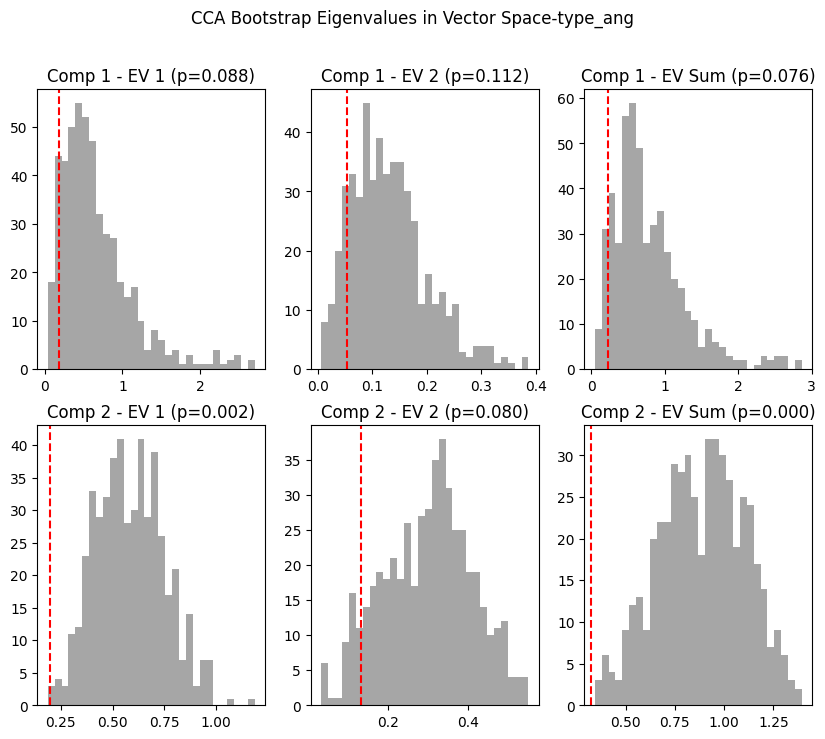

In [227]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
# Plot eigenvalue distributions for vector space
type = 'ang'
for comp in range(2):
    for eigen_int in range(2):
        ax = axes[comp, eigen_int]
        ax.hist(
            shuffle_results_df[f'eigvals_{type}_{comp}_{eigen_int+1}'],
            bins=30, color='gray', alpha=0.7
        )
        ax.axvline(
            x=result_ori[f'eigvals_{type}_{comp}'][eigen_int],
            color='red', linestyle='--',
            label='Original CCA'
        )
        p_value = np.mean(
            shuffle_results_df[f'eigvals_{type}_{comp}_{eigen_int+1}'] <=
            result_ori[f'eigvals_{type}_{comp}'][eigen_int]
        )
        ax.set_title(f'Comp {comp+1} - EV {eigen_int+1} (p={p_value:.3f})')
    eigen_sum = result_ori[f'eigvals_{type}_{comp}'].sum()
    eigen_sum_shuffle = shuffle_results_df[[f'eigvals_{type}_{comp}_1', f'eigvals_{type}_{comp}_2']].sum(axis=1)
    p_value = np.mean(eigen_sum_shuffle <= eigen_sum)
    axes[comp, 2].hist(
        eigen_sum_shuffle,
        bins=30, color='gray', alpha=0.7
    )
    axes[comp, 2].axvline(
        x=eigen_sum,
        color='red', linestyle='--',
        label='Original CCA'
    )
    axes[comp, 2].set_title(f'Comp {comp+1} - EV Sum (p={p_value:.3f})')
plt.suptitle(f'CCA Bootstrap Eigenvalues in Vector Space-type_{type}')
# plt.sca(axes[0, 0])
plt.savefig(
    os.path.join(target_folder, f'CCA_shuffle_variance_by_eigenvalues_{type}.pdf'),
    bbox_inches='tight'
)

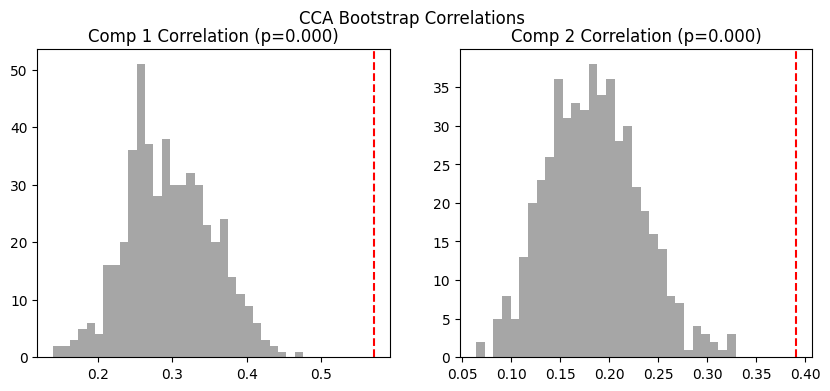

In [230]:
# plot the same for corr
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for comp in range(2):
    ax = axes[comp]
    ax.hist(
        shuffle_results_df[f'corr_{comp}'],
        bins=30, color='gray', alpha=0.7
    )
    ax.axvline(
        x=result_ori['corrs'][comp],
        color='red', linestyle='--',
        label='Original CCA'
    )
    p_value = np.mean(
        shuffle_results_df[f'corr_{comp}'] >=
        result_ori['corrs'][comp]
    )
    ax.set_title(f'Comp {comp+1} Correlation (p={p_value:.3f})')
plt.suptitle(f'CCA Bootstrap Correlations')
plt.savefig(
    os.path.join(target_folder, f'CCA_shuffle_correlation.pdf'),
    bbox_inches='tight'
)

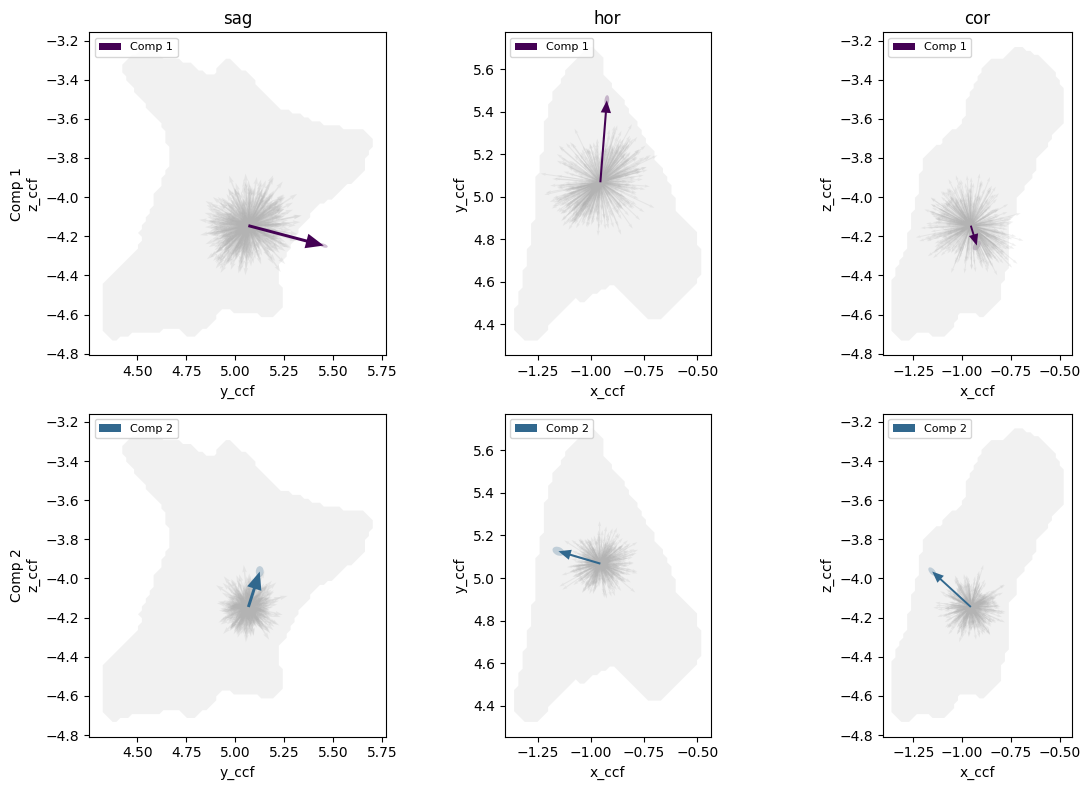

In [229]:
# plot shuffled cca vectors in 2D planes with cones
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Ellipse

# ----- Setup 2 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Normalize CCA vectors
cca_vecs = result_ori['cca_y_weights'].copy()
cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

boot_yw = result_ori['boot_yw']
boot_yw = boot_yw / np.linalg.norm(boot_yw, axis=1, keepdims=True)

n_boot = boot_yw.shape[0]

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']
n_se = 3  # 1 standard error ellipse
for comp in range(2):   # rows
    for plane_ind, plane in enumerate(planes.keys()):  # columns
        ax = axes[comp, plane_ind]
        ix, iy = planes[plane]

        # Draw anatomical background
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ----------------------------
        # BOOTSTRAP VECTOR VARIABILITY
        # ----------------------------
        # Collect bootstrap vectors for this component
        boot_vecs = boot_yw[:, :, comp]
        # Mean vector
        mean_vec = np.nanmean(boot_vecs, axis=0)
        mean_vec /= np.linalg.norm(mean_vec)

        # Project all bootstrap vectors to the plane (ix, iy)
        vecs_2d = boot_vecs[:, [ix, iy]]
        mean_2d = mean_vec[[ix, iy]]

        # Compute 2D covariance for cone/ellipse (bootstrapped spread)
        cov = np.cov(vecs_2d.T)

        # Convert covariance to *standard error* ellipse
        eigvals, eigvecs = np.linalg.eigh(cov / n_boot)  # divide by n_boot for SE

        # Scale by desired number of SEs (e.g., 1 → 1 SE, 2 → 95% CI)
        width, height = 2 * n_se * np.sqrt(eigvals)
        angle = np.degrees(np.arctan2(*eigvecs[:, 1][::-1]))

        scale = (1/result_ori['corrs'][comp])*1/0.7  # scaling factor for arrow length
        end_x = origin[ix] + mean_2d[0] / scale
        end_y = origin[iy] + mean_2d[1] / scale

        # Ellipse centered at arrow tip
        ellipse = Ellipse(
            xy=(end_x, end_y),
            width=width, height=height, angle=angle,
            edgecolor=None,
            facecolor=cm.viridis(comp / 3),
            alpha=0.25, lw=1.2
        )
        ax.add_patch(ellipse)



        # ----------------------------
        # All shuffle vectors (transparent)
        # ----------------------------
        for shu in parallel_results:
            shu_vec = shu['cca_y_weights'][:, comp]
            shu_vec /= np.linalg.norm(shu_vec)
            scale = (1/(shu['corrs'][comp]))*1/0.7
            ax.quiver(
                origin[ix], origin[iy],
                shu_vec[ix], shu_vec[iy],
                angles='xy', scale_units='xy', scale=scale,
                color=[0.7, 0.7, 0.7],
                alpha=0.2,
                width=0.005,
                linewidth=0.01
            )
        # ----------------------------
        # MEAN VECTOR (CENTRAL AXIS)
        # ----------------------------
        scale = (1/result_ori['corrs'][comp])*1/0.7  # scaling factor for arrow length
        ax.quiver(
            origin[ix], origin[iy],
            mean_2d[0], mean_2d[1],
            angles='xy', scale_units='xy', scale=scale,
            color=cm.viridis(comp / 3),
            width=0.01,            # ⬅️ thicker arrow shaft (was 0.004)
            linewidth=1.5,         # ⬅️ slightly heavier outline
            headwidth=5,          # ⬅️ makes arrowhead wider
            headlength=6,         # ⬅️ makes arrowhead longer
            headaxislength=6,     # ⬅️ makes axis-aligned portion of head larger
            label=f'Comp {comp+1}'
        )


        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_CCF_components_bootstrap&shuffle_SE_cones.pdf'),
    bbox_inches='tight'
)
plt.show()


In [ ]:
results = perform_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=5000, n_boot=1000, alpha=0.05)

# Compare with waveform features

In [26]:
features_wf = wf_features.columns.to_list()
features_wf.remove('session')
features_wf.remove('unit_id')
features_wf.remove('wf')
# features_wf.remove('gmm_label')
# features_wf.remove('kmeans_label')
# features_wf.remove('gmm_conf')
features_wf.remove('y_loc')
features_wf.remove('probe')
features_wf.remove('peak')
features_wf.remove('amp')

ValueError: list.remove(x): x not in list

In [ ]:
# compare all values in features_be with features_wf
filter = features_combined['be_filter']
fig = plt.figure(figsize=(len(features_beh) * 3, 3 * len(features_wf)))
gs = gridspec.GridSpec(len(features_wf), len(features_beh))
for i, feature in enumerate(features_wf):
    for j, feature_be in enumerate(features_beh):
        ax = fig.add_subplot(gs[i, j])
        ax.scatter(features_combined[feature_be][filter], features_combined[feature][filter], c=features_combined['cluster'][filter], cmap='viridis', s=40, alpha=0.7, edgecolor='none')
        
        ax.set_xlabel(feature_be)
        ax.set_ylabel(feature)
        # correlation 
        x = features_combined[feature_be][filter]
        y = features_combined[feature][filter]
        corr, p = stats.pearsonr(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)])
        ax.set_title(f'r={corr:.2f} p={p:.2f}')
        if p < 0.05:
            ax.set_title(f'r={corr:.2f} p={p:.2e}', color='red')
plt.tight_layout()
plt.savefig(os.path.join(beh_folder, f'compare_beh_wf_features_{criteria_name}_{waveform_criteria}{waveform_type}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(beh_folder, f'compare_beh_wf_features_{criteria_name}_{waveform_criteria}{waveform_type}.png'), bbox_inches='tight')

# Compare with basic properties

In [226]:
basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
features_be = basic_ephys_df.columns.to_list()
features_be.remove('session')
features_be.remove('unit_id')
features_be.remove('acg')
features_be.remove('acg_bl')
features_be.remove('be_filter')

In [ ]:
# compare all values in features_be with features_wf
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
fig = plt.figure(figsize=(len(features_beh) * 3, 3 * len(features_be)))
gs = gridspec.GridSpec(len(features_be), len(features_beh))
for i, feature in enumerate(features_be):
    for j, feature_be in enumerate(features_beh):
        ax = fig.add_subplot(gs[i, j])
        ax.scatter(features_combined[feature_be][filter], features_combined[feature][filter], c=features_combined['cluster'][filter], cmap='viridis', s=40, alpha=0.7, edgecolor='none')
        
        ax.set_xlabel(feature_be)
        ax.set_ylabel(feature)
        # correlation 
        x = features_combined[feature_be][filter].values
        y = features_combined[feature][filter].values
        corr, p = stats.pearsonr(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)])
        ax.set_title(f'r={corr:.2f} p={p:.2f}')
        if p < 0.05:
            ax.set_title(f'r={corr:.2f} p={p:.2e}', color='red')
plt.tight_layout()
plt.savefig(os.path.join(beh_folder, f'compare_beh_basicephys_features_{criteria_name}_{waveform_criteria}{waveform_type}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(beh_folder, f'compare_beh_basicephys_features_{criteria_name}_{waveform_criteria}{waveform_type}.png'), bbox_inches='tight')


# Compare outcome and go cue response

In [136]:
lm = LinearRegression()
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool) 
features_combined['be_filter'] = filter
focus_feature = 'response_rate'
X = features_combined[['pc_1', 'pc_2',  'pc_3']].values[filter]
y = features_combined[focus_feature].values[filter]

In [137]:
nan_filter = np.isnan(y) | np.isnan(X[:, 0])
lm.fit(X[~nan_filter], y[~nan_filter])
lm.coef_, lm.intercept_
focus_feature_predicted = np.full(np.sum(filter), np.nan)
focus_feature_predicted[~nan_filter] = lm.predict(X[~nan_filter])

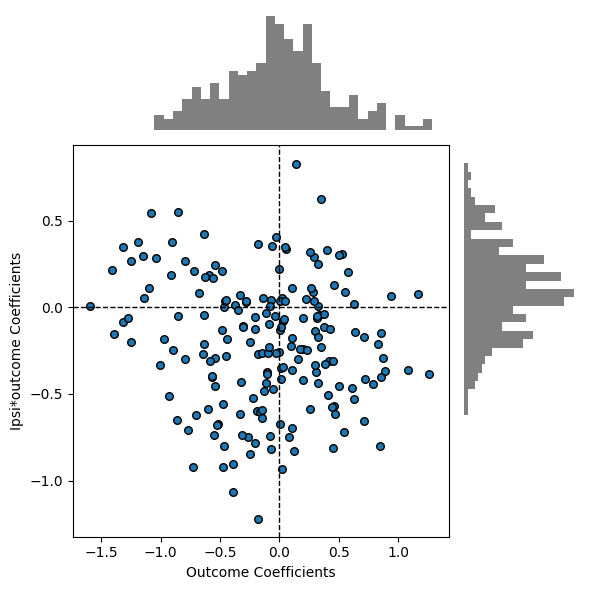

In [138]:
# scatter and polar of 'outcome' and 'Qchosen'
period = 'l'
verion = 'mc'  # 'ori' or 'mc'
c_or_t = 'T'
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)

curr_p_int = features_combined[f'p_outcome:ipsi_{period}_{verion}'].values
curr_coefs_int = features_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 


curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values

curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values  # get the p-values for the reward outcome

color_code = 'response_rate'
color_code_var = features_combined[color_code].values.astype(float)
color_top = np.quantile(color_code_var[~np.isnan(color_code_var)], 0.85)
color_bottom = np.quantile(color_code_var[~np.isnan(color_code_var)], 0.05)
color_code_var[color_code_var >= color_top] = color_top
color_code_var[color_code_var <= color_bottom] = color_bottom                                                                                                                               
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(curr_coefs_outcome[filter]-curr_coefs_int[filter], curr_coefs_q[filter], edgecolors='k', s=30, label='outcome p<0.05')
ax_scatter.axhline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.axvline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.set_xlabel('Outcome Coefficients')
ax_scatter.set_ylabel('Ipsi*outcome Coefficients')
# plt.colorbar(im)

# Histogram for X-axis
ax_histx.hist(curr_coefs_outcome, bins=30, color='gray')
ax_histx.axis('off')  # hide ticks and labels

# Histogram for Y-axis (horizontal)
ax_histy.hist(curr_coefs_int, bins=30, color='gray', orientation='horizontal')
ax_histy.axis('off')  # hide ticks and labels

plt.tight_layout()
plt.show()


In [139]:
thresh =0.05
all_vec = np.column_stack((curr_coefs_outcome[filter], curr_coefs_q[filter]))  # combine the coefficients for the reward outcome and Qchosen
all_vec = all_vec.astype(float)
# Convert Cartesian coordinates to polar coordinates
theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
bound_1 = -(1/4)*np.pi
bound_2 = np.pi
bound_3 = -np.pi
theta_scaled_dis  = np.full(len(theta), np.nan)
for ind, angle_curr in enumerate(theta):
    if bound_1 < angle_curr <= bound_2:
        theta_scaled_dis[ind] = (angle_curr-bound_1)/(bound_2-bound_1)
    else:
        theta_scaled_dis[ind] = (bound_1-angle_curr)/(bound_1-bound_3)
theta_scaled_dis_all = np.full(len(features_combined), np.nan)
theta_scaled_dis_all[filter] = theta_scaled_dis
features_combined['theta_scaled_dis'] = theta_scaled_dis_all

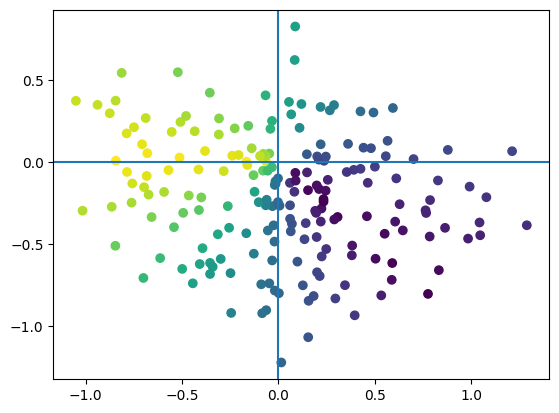

In [35]:
plt.scatter(curr_coefs_outcome[filter], curr_coefs_q[filter], c=theta_scaled_dis)
plt.axhline(0)
plt.axvline(0)

TypeError: '<' not supported between instances of 'float' and 'str'

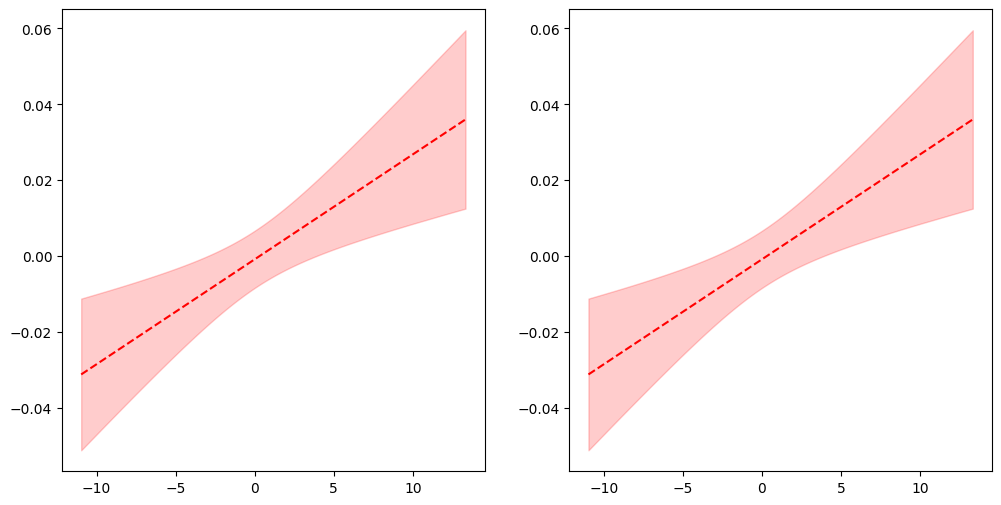

In [28]:
from scipy.stats import t, pearsonr
from sklearn.linear_model import LinearRegression
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
x_label = 'T_outcome_l_mc' #'response_rate' 
y_label = 'pc_2'
color_code = 'probe'
tier = 'tier_1'
num_bins = 3
filter = np.array([True]*len(features_combined))
filter = np.array(filter, dtype=bool)
filter = filter & (features_combined['be_filter'].values)
# filter = filter & (features_combined['selected'])
# filter = filter & (features_combined['probe'] == 'tt')
# filter = filter & (features_combined['T_outcome_com_mc'].values <= 30)
nan_mask = features_combined[filter][x_label].isnull() | features_combined[filter][y_label].isnull()
# bin_edges = np.linspace(np.nanmin(features_combined[x_label].values[filter]), np.nanmax(features_combined[x_label].values[filter]), num_bins+1)
# # bin_edges = np.quantile(features_combined[x_label].values[filter][~nan_mask], np.linspace(0, 1, num_bins+1))
# mean_x = np.zeros(num_bins)
# mean_y = np.zeros(num_bins)
# se_y = np.zeros(num_bins)

# for i in range(num_bins):
#     bin_mask = (features_combined[x_label].values[filter] >= bin_edges[i]) & (features_combined[x_label].values[filter] < bin_edges[i+1])
#     mean_x[i] = np.nanmean(features_combined[x_label].values[filter][bin_mask])
#     mean_y[i] = np.nanmean(features_combined[y_label].values[filter][bin_mask])
#     se_y[i] = stats.sem(features_combined[y_label].values[filter][bin_mask], nan_policy='omit')
# fit a regression line and add it to the plot
# Reshape for sklearn
x_vals = features_combined[x_label].values[filter][~nan_mask].astype(float)
y_vals = features_combined[y_label].values[filter][~nan_mask].astype(float)

X = x_vals.reshape(-1, 1)

# Fit model
lm = LinearRegression()
lm.fit(X, y_vals)
y_pred = lm.predict(X)

# Calculate residuals and standard error
residuals = y_vals - y_pred
dof = len(x_vals) - 2  # degrees of freedom
residual_std_error = np.sqrt(np.sum(residuals**2) / dof)

# Confidence interval (95%)
t_val = t.ppf(0.975, dof)

# Prediction standard error at each x
se_pred = residual_std_error * np.sqrt(1/len(x_vals) + (x_vals - np.mean(x_vals))**2 / np.sum((x_vals - np.mean(x_vals))**2))

# Upper and lower CI
y_upper = y_pred + t_val * se_pred
y_lower = y_pred - t_val * se_pred

# Sort for nice line plot
sorted_idx = np.argsort(x_vals)
x_sorted = x_vals[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_upper_sorted = y_upper[sorted_idx]
y_lower_sorted = y_lower[sorted_idx]

# Plot regression line
axes[0].plot(x_sorted, y_pred_sorted, color='r', linestyle='--', label='Regression line')

# Plot confidence band
axes[0].fill_between(x_sorted, y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% CI')


# Plot regression line
axes[1].plot(x_sorted, y_pred_sorted, color='r', linestyle='--', label='Regression line')

# Plot confidence band
axes[1].fill_between(x_sorted, y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% CI')

if color_code == 'probe':
    probe_types = np.unique(features_combined['probe'].values)
    probe_color_map = {probe: idx for idx, probe in enumerate(probe_types)}
    color_code_values = features_combined[color_code].values[filter][~nan_mask]
    color_code_values = np.array([probe_color_map[probe] for probe in color_code_values])
else:
    color_code_values = features_combined[color_code].values[filter][~nan_mask].astype(float)
color_code_5 = np.quantile(color_code_values[~np.isnan(color_code_values)], 0.01)
color_code_95 = np.quantile(color_code_values[~np.isnan(color_code_values)], 0.90)
color_code_values[color_code_values>=color_code_95]=color_code_95
color_code_values[color_code_values<=color_code_5]=color_code_5
im = axes[0].scatter(x_vals, y_vals, c = color_code_values, alpha = 0.8, edgecolors='k', s = 100, linewidths=2, cmap = 'Greys_r')
axes[0].set_xlabel(x_label)
axes[0].set_ylabel(y_label)
plt.colorbar(im, label=color_code)
# axes[0].errorbar(mean_x, mean_y, yerr=se_y, fmt='-o', color='k', label='Mean with SE')
# corr, p = pearsonr(features_combined[x_label].values[filter][~nan_mask].astype(float), features_combined[y_label].values[filter][~nan_mask].astype(float))
corr, p = pearsonr(x_vals, y_vals)
axes[0].set_title(f'Correlation: {corr:.2f} p-value: {p:.5f}')


im = axes[1].scatter(x_vals, y_vals, c = color_code_values, alpha = 0.8, edgecolors='k', s = 100, linewidths=2, cmap = 'Greys_r')
axes[1].set_xlabel(x_label)
axes[1].set_ylabel(y_label)
plt.colorbar(im, label=color_code)

# # anti cells
# anti_thresh = 2
features_combined_anti = features_combined[(features_combined[tier].astype(bool)) & (features_combined['be_filter'])]

# nan_mask = features_combined_anti[filter_anti][x_label].isnull() | features_combined_anti[filter_anti][y_label].isnull()
# x_vals = features_combined_anti[x_label].values[filter][~nan_mask].astype(float)
# y_vals = features_combined_anti[y_label].values[filter][~nan_mask].astype(float)

axes[1].scatter(features_combined_anti[x_label].values, features_combined_anti[y_label].values, color = 'r', alpha = 0.8, edgecolors='none', s = 100, linewidths=2)

fig.savefig(fname=os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.svg'), bbox_inches='tight')

In [29]:
test = features_combined[features_combined['probe'].isna()]

In [30]:
test

session unit_id  T_Qchosen_e_ori  \
14  behavior_751004_2024-12-21_13-28-28     195              NaN   

    T_outcome_e_ori  T_ipsi_e_ori  T_outcome:ipsi_e_ori  T_amp_abs_e_ori  \
14              NaN           NaN                   NaN              NaN   

    T_Qchosen_l_ori  T_outcome_l_ori  T_ipsi_l_ori  ...  \
14              NaN              NaN           NaN  ...   

    coef_response_Intercept  T_response_Intercept  p_response_Intercept  \
14                      NaN                   NaN                   NaN   

    probe  x_ccf  y_ccf  z_ccf  tier_1  tier_2  isi_violations  
14    NaN    NaN    NaN    NaN     NaN     NaN             NaN  

[1 rows x 207 columns]

In [ ]:
wf_features[wf_features['session'] == 'behavior_751004_2024-12-21_13-28-28']

session unit  coef_ratio_hit  T_ratio_hit  \
8   behavior_751004_2024-12-21_13-28-28    6        0.545699     2.752093   
9   behavior_751004_2024-12-21_13-28-28   22        0.794888     1.568958   
10  behavior_751004_2024-12-21_13-28-28   33        0.222185     0.747688   
11  behavior_751004_2024-12-21_13-28-28   48        0.135074     0.729745   

    p_ratio_hit  coef_baseline_hit  T_baseline_hit  p_baseline_hit  \
8      0.005922           0.017930        0.096562        0.923074   
9      0.116658          -0.060878       -0.252330        0.800786   
10     0.454648          -0.547748       -1.196588        0.231467   
11     0.465546          -0.524809       -1.821954        0.068462   

    coef_response_hit  T_response_hit  ...  coef_ratio_Intercept  \
8            1.790352        3.664472  ...              0.433027   
9            2.171046        4.002870  ...             -1.087353   
10           1.654997        1.578571  ...              2.656090   
11          -0.469393       -0.879699  ...              1.569018   

    T_ratio_Intercept  p_ratio_Intercept  coef_baseline_Intercept  \
8            0.229015           0.818857                 7.350866   
9           -0.807762           0.419228                 4.147683   
10           1.902648           0.057087                 5.449733   
11           1.756495           0.079004                 1.672725   

    T_baseline_Intercept  p_baseline_Intercept  coef_response_Intercept  \
8               4.151469          3.303479e-05                12.394392   
9               6.481783          9.064495e-11                 5.566325   
10              2.534245          1.126900e-02                13.760627   
11              1.203317          2.288538e-01                 6.082028   

    T_response_Intercept  p_response_Intercept  unit_id  
8               2.660340              0.007806        6  
9               3.869486              0.000109       22  
10              2.793925              0.005207       33  
11              2.361919              0.018181       48  

[4 rows x 48 columns]

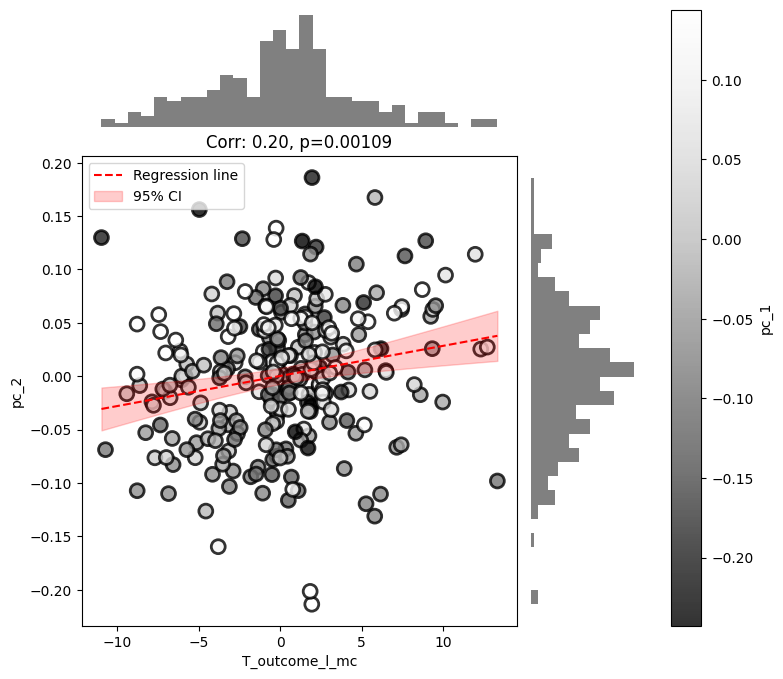

In [45]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.stats import t, pearsonr
from sklearn.linear_model import LinearRegression
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
# filter = filter & (features_combined['bl_mean'].values >= 2)
nan_mask = features_combined[filter][x_label].isnull() | features_combined[filter][y_label].isnull()
# Extract data
x_vals = features_combined[x_label].values[filter][~nan_mask].astype(float)
y_vals = features_combined[y_label].values[filter][~nan_mask].astype(float)
color_vals = features_combined[color_code].values[filter][~nan_mask].astype(float)

# Clip color range for better visualization
color_code_5 = np.nanquantile(color_vals, 0.01)
color_code_95 = np.nanquantile(color_vals, 0.90)
color_vals = np.clip(color_vals, color_code_5, color_code_95)

# Fit regression
X = x_vals.reshape(-1, 1)
lm = LinearRegression().fit(X, y_vals)
y_pred = lm.predict(X)

# Confidence interval
residuals = y_vals - y_pred
dof = len(x_vals) - 2
residual_std_error = np.sqrt(np.sum(residuals**2) / dof)
t_val = t.ppf(0.975, dof)
se_pred = residual_std_error * np.sqrt(1/len(x_vals) + (x_vals - np.mean(x_vals))**2 / np.sum((x_vals - np.mean(x_vals))**2))

y_upper = y_pred + t_val * se_pred
y_lower = y_pred - t_val * se_pred

# Sort for smooth CI band
sorted_idx = np.argsort(x_vals)
x_sorted = x_vals[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_upper_sorted = y_upper[sorted_idx]
y_lower_sorted = y_lower[sorted_idx]

# Create figure with gridspec
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.1, wspace=0.05)

# Main scatter plot
ax_main = fig.add_subplot(gs[1, 0])
sc = ax_main.scatter(x_vals, y_vals, c=color_vals, cmap='Greys_r', s=100, edgecolors='k', linewidths=2, alpha=0.8)
ax_main.plot(x_sorted, y_pred_sorted, 'r--', label='Regression line')
ax_main.fill_between(x_sorted, y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% CI')
ax_main.set_xlabel(x_label)
ax_main.set_ylabel(y_label)
corr, p = pearsonr(x_vals, y_vals)
ax_main.set_title(f'Corr: {corr:.2f}, p={p:.5f}')
ax_main.legend()

# Histogram on top (X axis)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_histx.hist(x_vals, bins=30, color='gray')
ax_histx.axis('off')

# Histogram on right (Y axis)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_histy.hist(y_vals, bins=30, orientation='horizontal', color='gray')
ax_histy.axis('off')

# Colorbar
cbar = fig.colorbar(sc, ax=[ax_main, ax_histx, ax_histy], orientation='vertical', fraction=0.05)
cbar.set_label(color_code)

# Save
fig.savefig(os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}_marginal_hist.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}_marginal_hist.svg'), bbox_inches='tight')

plt.show()


In [122]:
from sklearn.decomposition import PCA
import numpy as np

# Prepare data
x = features_combined[x_label].values[filter][~nan_mask].astype(float)
y = features_combined[y_label].values[filter][~nan_mask].astype(float)

# Stack into 2D array
X = np.column_stack([x, y])

# Fit PCA (1D line)
pca = PCA(n_components=1)
pca.fit(X)

# Mean and direction of best-fitting line
center = pca.mean_
direction = pca.components_[0]

# Project each point onto the line (2D projection)
proj_length = (X - center) @ direction      # signed coordinate along line
projected = center + np.outer(proj_length, direction)  # 2D projected coordinates

# Create "fitted line" samples for visualization (like x_fit/y_fit)
proj_min, proj_max = proj_length.min(), proj_length.max()
x_fit_line = np.linspace(proj_min, proj_max, 500)
curve = center + np.outer(x_fit_line, direction)
x_fit, y_fit = curve[:, 0], curve[:, 1]

# Normalize 1D coordinate along line
projected_1d = proj_length
projected_1d_norm = (projected_1d - projected_1d.min()) / (projected_1d.max() - projected_1d.min())


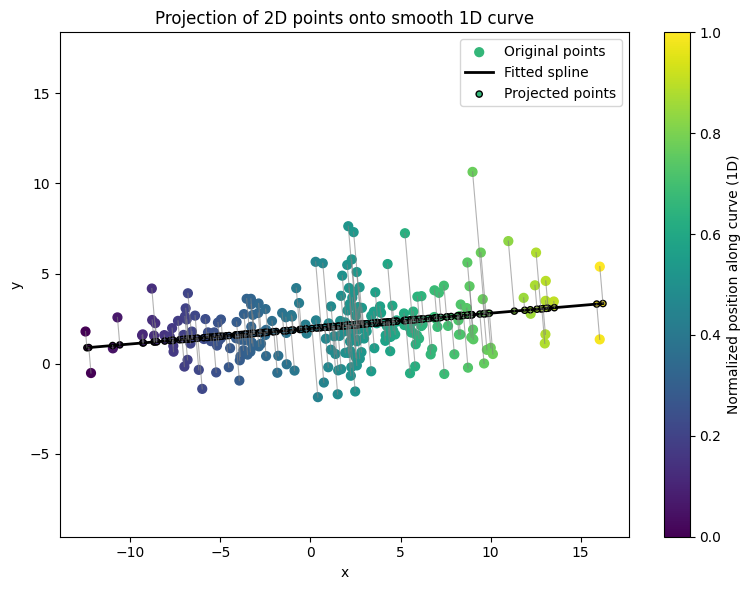

In [123]:
plt.figure(figsize=(8,6))

# Original scatter
plt.scatter(x, y, c=projected_1d_norm, cmap='viridis', s=40, label='Original points')

# Fitted spline
plt.plot(x_fit, y_fit, 'k-', lw=2, label='Fitted spline')

# Projections (lines from each point to curve)
x_proj, y_proj = projected[:, 0], projected[:, 1]
for xi, yi, xpi, ypi in zip(x, y, x_proj, y_proj):
    plt.plot([xi, xpi], [yi, ypi], 'gray', lw=0.8, alpha=0.6)

# Projected points
plt.scatter(x_proj, y_proj, c=projected_1d_norm, cmap='viridis', s=20, edgecolor='k', label='Projected points')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Projection of 2D points onto smooth 1D curve')
plt.legend()
plt.colorbar(label='Normalized position along curve (1D)')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [2]:
proj_1d_all = np.full(len(features_combined), np.nan)
proj_1d_all[filter][~nan_mask] = projected_1d_norm
features_combined['proj_1d'] = proj_1d_all

NameError: name 'np' is not defined

In [1]:
# from scipy.stats import t, pearsonr
# from sklearn.linear_model import LinearRegression
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# x_label = 'T_outcome_com_mc' #'response_rate' 
# y_label = 'T'
# color_code = 'pc_1'
# num_bins = 3
# filter = features_combined['be_filter'].values
# filter = np.array(filter, dtype=bool)
# # filter = filter & (features_combined['bl_mean'].values >= 2)
# nan_mask = features_combined[filter][x_label].isnull() | features_combined[filter][y_label].isnull()
# # bin_edges = np.linspace(np.nanmin(features_combined[x_label].values[filter]), np.nanmax(features_combined[x_label].values[filter]), num_bins+1)
# # # bin_edges = np.quantile(features_combined[x_label].values[filter][~nan_mask], np.linspace(0, 1, num_bins+1))
# # mean_x = np.zeros(num_bins)
# # mean_y = np.zeros(num_bins)
# # se_y = np.zeros(num_bins)

# # for i in range(num_bins):
# #     bin_mask = (features_combined[x_label].values[filter] >= bin_edges[i]) & (features_combined[x_label].values[filter] < bin_edges[i+1])
# #     mean_x[i] = np.nanmean(features_combined[x_label].values[filter][bin_mask])
# #     mean_y[i] = np.nanmean(features_combined[y_label].values[filter][bin_mask])
# #     se_y[i] = stats.sem(features_combined[y_label].values[filter][bin_mask], nan_policy='omit')
# # fit a regression line and add it to the plot
# # Reshape for sklearn
# x_vals = features_combined[x_label].values[filter][~nan_mask].astype(float)
# y_vals = features_combined[y_label].values[filter][~nan_mask].astype(float)

# X = x_vals.reshape(-1, 1)

# # Fit model
# lm = LinearRegression()
# lm.fit(X, y_vals)
# y_pred = lm.predict(X)

# # Calculate residuals and standard error
# residuals = y_vals - y_pred
# dof = len(x_vals) - 2  # degrees of freedom
# residual_std_error = np.sqrt(np.sum(residuals**2) / dof)

# # Confidence interval (95%)
# t_val = t.ppf(0.975, dof)

# # Prediction standard error at each x
# se_pred = residual_std_error * np.sqrt(1/len(x_vals) + (x_vals - np.mean(x_vals))**2 / np.sum((x_vals - np.mean(x_vals))**2))

# # Upper and lower CI
# y_upper = y_pred + t_val * se_pred
# y_lower = y_pred - t_val * se_pred

# # Sort for nice line plot
# sorted_idx = np.argsort(x_vals)
# x_sorted = x_vals[sorted_idx]
# y_pred_sorted = y_pred[sorted_idx]
# y_upper_sorted = y_upper[sorted_idx]
# y_lower_sorted = y_lower[sorted_idx]

# # Plot regression line
# axes[0].plot(x_sorted, y_pred_sorted, color='r', linestyle='--', label='Regression line')

# # Plot confidence band
# axes[0].fill_between(x_sorted, y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% CI')


# color_code_values = features_combined[color_code].values[filter].astype(float)
# color_code_5 = np.quantile(color_code_values[~np.isnan(color_code_values)], 0.01)
# color_code_95 = np.quantile(color_code_values[~np.isnan(color_code_values)], 0.90)
# color_code_values[color_code_values>=color_code_95]=color_code_95
# color_code_values[color_code_values<=color_code_5]=color_code_5
# im = axes[0].scatter(features_combined[x_label].values[filter], features_combined[y_label].values[filter], c = color_code_values, alpha = 0.8, edgecolors='k', s = 100, linewidths=2, cmap = 'Greys_r')
# axes[0].set_xlabel(x_label)
# axes[0].set_ylabel(y_label)
# plt.colorbar(im, label=color_code)
# # axes[0].errorbar(mean_x, mean_y, yerr=se_y, fmt='-o', color='k', label='Mean with SE')
# corr, p = pearsonr(features_combined[x_label].values[filter][~nan_mask].astype(float), features_combined[y_label].values[filter][~nan_mask].astype(float))
# axes[0].set_title(f'Correlation: {corr:.2f} p-value: {p:.5f}')


# im = axes[1].scatter(features_combined[x_label].values[filter], features_combined[y_label].values[filter], c = color_code_values, alpha = 0.8, edgecolors='k', s = 100, linewidths=2, cmap = 'Greys_r')
# axes[1].set_xlabel(x_label)
# axes[1].set_ylabel(y_label)
# plt.colorbar(im, label=color_code)

# # anti cells
# anti_thresh = 2
# filter_anti = features_combined_anti['be_filter'].values
# filter_anti = np.array(filter_anti, dtype=bool)
# filter_anti = filter_anti & (features_combined_anti['anti_resp'].values <= anti_thresh) & (features_combined_anti['anti_resp'].values >= 1)
# nan_mask = features_combined_anti[filter_anti][x_label].isnull() | features_combined_anti[filter_anti][y_label].isnull()
# x_vals = features_combined_anti[x_label].values[filter][~nan_mask].astype(float)
# y_vals = features_combined_anti[y_label].values[filter][~nan_mask].astype(float)

# axes[1].scatter(features_combined_anti[x_label].values[filter_anti], features_combined_anti[y_label].values[filter_anti], color = 'r', alpha = 0.8, edgecolors='none', s = 100, linewidths=2)

# fig.savefig(fname=os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.pdf'), bbox_inches='tight')
# fig.savefig(os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.svg'), bbox_inches='tight')

In [84]:
# scatter and polar of 'outcome' and 'Qchosen'
period = 'com'
verion = 'mc'  # 'ori' or 'mc'
c_or_t = 'T'
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)
if 'outcome:ipsi' in regressors_focus:
    curr_p_int = features_combined[f'p_outcome:ipsi_{period}_{verion}'].values
    curr_coefs_int = features_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 
    curr_T_int = features_combined[f'T_outcome:ipsi_{period}_{verion}'].values 
else:
    curr_coefs_int = np.zeros(len(model_combined))
    curr_p_int = np.ones(len(model_combined))

curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values

curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values  # get the p-values for the reward outcome

color_code = 'response_rate'
color_code_var = features_combined[color_code].values.astype(float)
color_top = np.quantile(color_code_var[~np.isnan(color_code_var)], 0.85)
color_bottom = np.quantile(color_code_var[~np.isnan(color_code_var)], 0.05)
color_code_var[color_code_var >= color_top] = color_top
color_code_var[color_code_var <= color_bottom] = color_bottom                                                                                                                               
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(curr_T_outcome[filter], curr_T_int[filter], edgecolors='k', s=30, label='outcome p<0.05')
ax_scatter.axhline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.axvline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.set_xlabel('Outcome Coefficients')
ax_scatter.set_ylabel('Ipsi*outcome Coefficients')
plt.colorbar(im)

# Histogram for X-axis
ax_histx.hist(curr_T_outcome, bins=30, color='gray')
ax_histx.axis('off')  # hide ticks and labels

# Histogram for Y-axis (horizontal)
ax_histy.hist(curr_T_int, bins=30, color='gray', orientation='horizontal')
ax_histy.axis('off')  # hide ticks and labels

plt.tight_layout()
plt.show()


NameError: name 'regressors_focus' is not defined

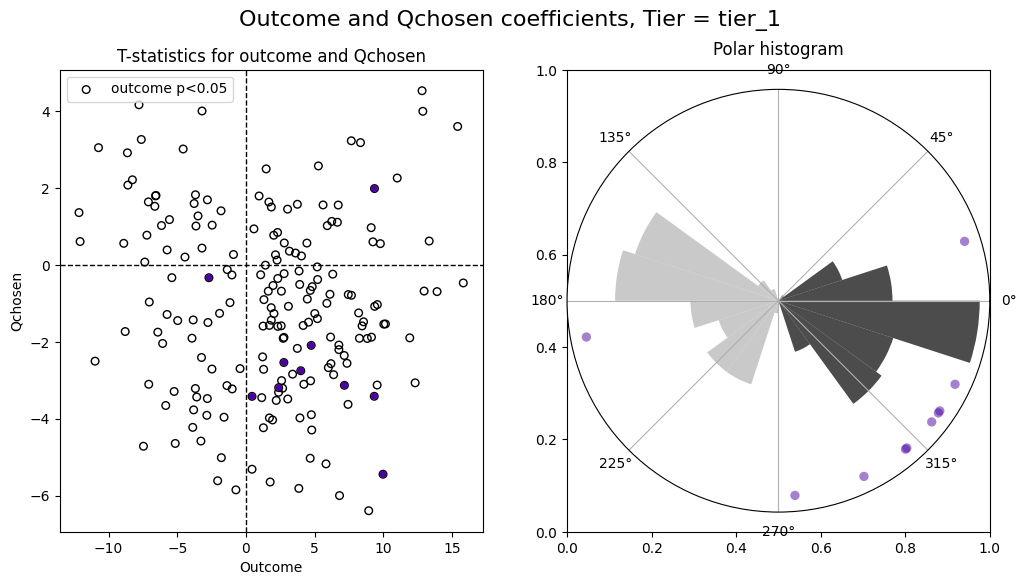

In [76]:
period = 'com'
verion = 'ori'  # 'ori' or 'mc'
c_or_t = 'T'
tier = 'tier_1'
thresh = 0.05
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)

curr_p_int = features_combined[f'p_outcome:ipsi_{period}_{verion}'].values
curr_coefs_int = features_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 
curr_T_int = features_combined[f'T_outcome:ipsi_{period}_{verion}'].values 

curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values[filter]
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values[filter]

curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values[filter]  # get the T-statistics for the reward outcome
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values[filter]  # get the T-statistics for the Qchosen
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values[filter]  # get the p-values for the reward outcome
# scatter of outcome and Qchosen coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
outcome_T_all = curr_T_outcome
qchosen_T_all = curr_T_q
outcome_coef_all = curr_coefs_outcome
qchosen_coef_all = curr_coefs_q
outcome_P_all = curr_p_outcome

axes[0].scatter(outcome_T_all, qchosen_T_all, color='none', edgecolors='k', s=30, label = 'outcome p<0.05')
# axes[0].scatter(outcome_T_all[outcome_P_all>=thresh], qchosen_T_all[curr_p_outcome>=thresh], color='none', edgecolors='lightgray', s=30, label = 'outcome p>=0.05')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Qchosen')
axes[0].set_title('T-statistics for outcome and Qchosen')
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].legend()

# polar
edges = np.linspace(-np.pi, np.pi, 4*5+1)
axes[1] = fig.add_subplot(122, polar=True)
all_vec = np.column_stack((outcome_coef_all[outcome_P_all<thresh], qchosen_coef_all[outcome_P_all<thresh]))  # combine the coefficients for the reward outcome and Qchosen
# Convert Cartesian coordinates to polar coordinates
cat_mask = outcome_coef_all[outcome_P_all<thresh]>0
# Create polar histogram
# positive
theta, rho = np.arctan2(all_vec[~cat_mask, 1], all_vec[~cat_mask, 0]), np.hypot(all_vec[~cat_mask, 1], all_vec[~cat_mask, 0])
axes[1].hist(theta, bins=edges, color=[0.7, 0.7, 0.7], alpha=0.7, edgecolor='none', density=True)
# negative
theta, rho = np.arctan2(all_vec[cat_mask, 1], all_vec[cat_mask, 0]), np.hypot(all_vec[cat_mask, 1], all_vec[cat_mask, 0])
axes[1].hist(theta, bins=edges, color=[0, 0, 0], alpha=0.7, edgecolor='none', density=True)
axes[1].set_yticks([])
axes[1].set_title('Polar histogram')
# antidromic ones:
mask = (features_combined[tier].astype(bool)) & (features_combined['be_filter'])
curr_coefs_outcome_anti = features_combined[f'coef_outcome_{period}_{verion}'].values[mask]
curr_T_outcome_anti = features_combined[f'T_outcome_{period}_{verion}'].values[mask]  # get the T-statistics for the reward outcome
curr_coefs_q_anti = features_combined[f'coef_Qchosen_{period}_{verion}'].values[mask]
curr_T_q_anti = features_combined[f'T_Qchosen_{period}_{verion}'].values[mask]  # get the T-statistics for the Qchosen
new_vec_anti = np.column_stack((curr_coefs_outcome_anti, curr_coefs_q_anti))  # combine the coefficients for the reward outcome and Qchosen
theta, rho = np.arctan2(new_vec_anti[:, 1], new_vec_anti[:, 0]), np.hypot(new_vec_anti[:, 1], new_vec_anti[:, 0])
axes[1].scatter(theta, 0.9 * np.ones_like(theta), color=(76/255, 2/255, 161/255), alpha=0.5, edgecolors='none', s=45)
# axes[1].hist(theta, bins=edges, color='red', alpha=0.7, edgecolor='none', density=True)
axes[0].scatter(curr_T_outcome_anti, curr_T_q_anti, color=(76/255, 2/255, 161/255), edgecolors='none', s=25, label='anti cells')
# set box and axis to be invisible
# axes[1].get_xaxis().set_visible(False)
# axes[1].get_yaxis().set_visible(False)
plt.suptitle(f'Outcome and Qchosen coefficients, Tier = {tier}', fontsize=16)
plt.savefig(os.path.join(beh_folder, f'Combined_Summary_outcome_Qchosen_coeffs_{criteria_name}_with_anti_at_{tier}.pdf'), bbox_inches='tight')

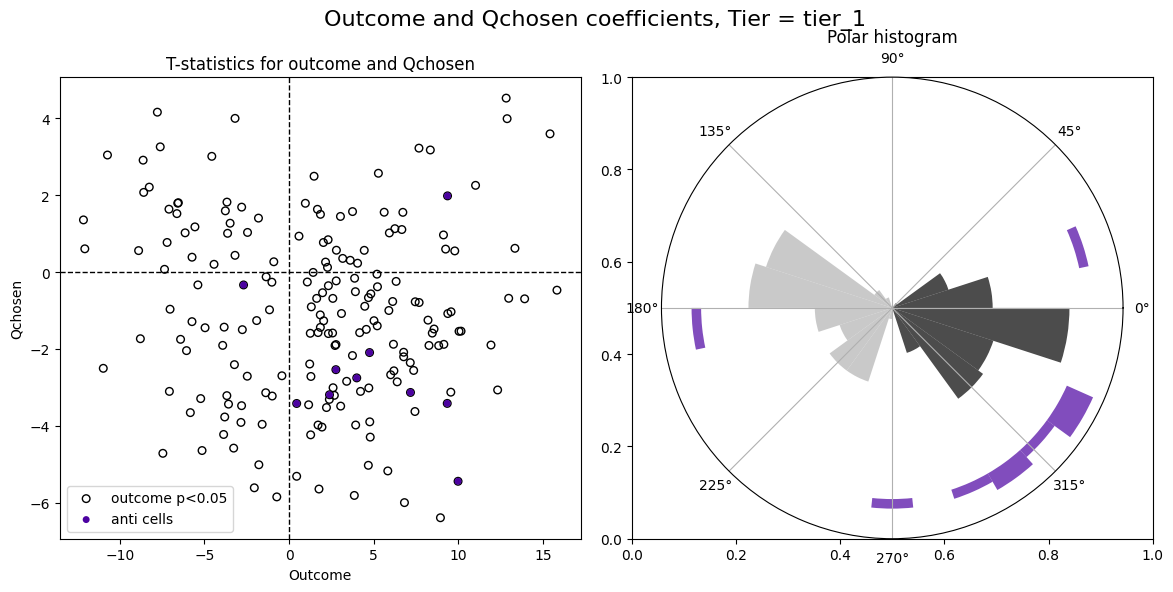

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os

period = 'com'
verion = 'ori'  # 'ori' or 'mc'
c_or_t = 'T'
tier = 'tier_1'
thresh = 0.05

# --- filtering ---
filter = np.array(features_combined['be_filter'].values, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)

# --- coefficients and stats ---
curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values[filter]
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values[filter]
curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values[filter]
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values[filter]
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values[filter]

# --- figure setup ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
outcome_T_all, qchosen_T_all = curr_T_outcome, curr_T_q
outcome_coef_all, qchosen_coef_all = curr_coefs_outcome, curr_coefs_q
outcome_P_all = curr_p_outcome

# === Scatter of T-values ===
axes[0].scatter(outcome_T_all, qchosen_T_all, color='none', edgecolors='k', s=30, label='outcome p<0.05')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Qchosen')
axes[0].set_title('T-statistics for outcome and Qchosen')
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].legend()

# === Polar histogram (main background) ===
edges = np.linspace(-np.pi, np.pi, 4 * 5 + 1)
axes[1] = fig.add_subplot(122, polar=True)
all_vec = np.column_stack((
    outcome_coef_all[outcome_P_all < thresh],
    qchosen_coef_all[outcome_P_all < thresh]
))
cat_mask = outcome_coef_all[outcome_P_all < thresh] > 0

# positive (gray)
theta_pos = np.arctan2(all_vec[~cat_mask, 1], all_vec[~cat_mask, 0])
axes[1].hist(theta_pos, bins=edges, color=[0.7, 0.7, 0.7],
             alpha=0.7, edgecolor='none', density=True)
# negative (black)
theta_neg = np.arctan2(all_vec[cat_mask, 1], all_vec[cat_mask, 0])
axes[1].hist(theta_neg, bins=edges, color=[0, 0, 0],
             alpha=0.7, edgecolor='none', density=True)

axes[1].set_yticks([])
axes[1].set_title('Polar histogram')

# === Antidromic data (for outer circular histogram) ===
mask = (features_combined[tier].astype(bool)) & (features_combined['be_filter'])
curr_coefs_outcome_anti = features_combined[f'coef_outcome_{period}_{verion}'].values[mask]
curr_coefs_q_anti = features_combined[f'coef_Qchosen_{period}_{verion}'].values[mask]
curr_T_outcome_anti = features_combined[f'T_outcome_{period}_{verion}'].values[mask]
curr_T_q_anti = features_combined[f'T_Qchosen_{period}_{verion}'].values[mask]

new_vec_anti = np.column_stack((curr_coefs_outcome_anti, curr_coefs_q_anti))
theta = np.arctan2(new_vec_anti[:, 1], new_vec_anti[:, 0])

# --- add circular histogram around the edge ---
num_bins = 30
counts, bin_edges = np.histogram(theta, bins=num_bins, range=(-np.pi, np.pi), density=False)
counts = counts / counts.max()  # normalize for visualization

color_anti = np.array([76/255, 2/255, 161/255])
r_base = 1.0  # radius of outer circle
r_height = 0.15  # height of histogram bars

# plot bars as radial rectangles
for i in range(num_bins):
    theta_start = bin_edges[i]
    theta_end = bin_edges[i + 1]
    theta_center = 0.5 * (theta_start + theta_end)
    width = theta_end - theta_start
    height = r_height * counts[i]
    axes[1].bar(theta_center, height, width=width,
                bottom=r_base, color=color_anti, alpha=0.7, edgecolor='none', linewidth=0)

# overlay antidromic scatter on T–T plot
axes[0].scatter(curr_T_outcome_anti, curr_T_q_anti,
                color=color_anti, edgecolors='none', s=25, label='anti cells')

plt.suptitle(f'Outcome and Qchosen coefficients, Tier = {tier}', fontsize=16)
axes[0].legend()
plt.tight_layout()
plt.savefig(os.path.join(
    beh_folder,
    f'Combined_Summary_outcome_Qchosen_coeffs_{criteria_name}_with_anti_at_{tier}.pdf'
), bbox_inches='tight')
plt.show()


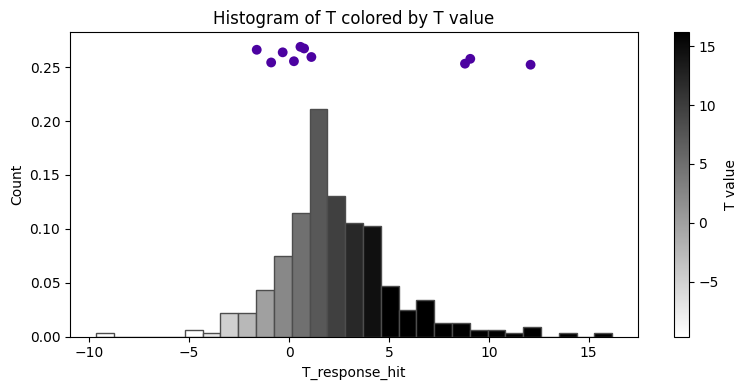

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Example variable
focus_feature = 'T_response_hit'
T = features_combined[focus_feature].values

# Drop NaNs
T = T[~np.isnan(T)]

# Define histogram bins
edges = np.linspace(np.nanmin(T), np.nanmax(T), 30)
counts, _ = np.histogram(T, bins=edges)
counts = counts/len(T)

# Compute bin centers
centers = 0.5 * (edges[:-1] + edges[1:])
amp = np.quantile(T, 0.85)
centers_c = np.clip(centers, -amp, amp)
centers_c = (centers_c + amp)/(2*amp)  # shift to positive for color mapping
# centers = np.clip(centers, -amp, amp)

# Normalize bin centers (T values) for color mapping
norm = Normalize(vmin=np.nanmin(T), vmax=np.nanmax(T))
custom_cmap = LinearSegmentedColormap.from_list(
    'blue_white_red', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
)
custom_cmap = LinearSegmentedColormap.from_list(
    'whites', [(0.0, 'white'), (1.0, 'black')]
)
colors = custom_cmap(centers_c)
# Plot histogram manually (each bar has its own color)
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(len(edges) - 1):
    ax.bar(
        centers[i],
        counts[i],
        width=(edges[i+1] - edges[i]),
        color=colors[i],
        edgecolor=[0.3, 0.3, 0.3],
        align='center'
    )


# Add colorbar to show T value mapping
sm = ScalarMappable(norm=norm, cmap=custom_cmap)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='T value')

ax.set_xlabel(focus_feature)
ax.set_ylabel('Count')
ax.set_title('Histogram of T colored by T value')

anti_mask = features_combined['tier_1'].astype(bool) & features_combined['be_filter'] & (features_combined['isi_violations'] < 0.1)
ax.scatter(
    features_combined[focus_feature].values[anti_mask],
    np.full(np.sum(anti_mask), 0.25) + 0.02 * np.random.rand(np.sum(anti_mask)),
    c=np.array([[76/255, 2/255, 161/255]]),
    edgecolors='none',
    s=50
)

plt.tight_layout()
fig.savefig(os.path.join(beh_folder, f'{focus_feature}_antidromic_{criteria_name}_hist.svg'), bbox_inches='tight')
fig.savefig(os.path.join(beh_folder, f'{focus_feature}_antidromic_{criteria_name}_hist.pdf'), bbox_inches='tight')

In [80]:
os.path.join(beh_folder, f'{focus_feature}_antidromic_{criteria_name}_hist.svg')

'/root/capsule/scratch/combined/beh_plots/beh_all/T_outcome_com_mc_antidromic_beh_all_hist.svg'